# Developing a Women's Pro Hockey Expected Goals (xG) Model

#### Brian Johns, February 2026

## Notebook #4: Even Strength Modelling

I did my first round of modeling in notebook #2, using Logistic Regression and XGBoost models to predict goals.  The conclusion of that modeling showed that multi-colinearity was a likely issue, and that conducting the modeling on all strength states (Even Strength, Power Play and Shorthanded) was problematic.  Lastly, a known issue with this data is that many shots did not have an appropriate `shot_type`, listing it as 'default'.

Here I will conduct another round of modelling in an attempt to solved these issues.  I will only look at Even Strength shots, filter out shots that did not have an appropriate `shot_type` label and drop features that have known multi-colinearity issues. discovered through this process.  I will re-run Logistic Regression and XGBoost models and continue to evaluate the them using Log Loss and AUC to pick the most accurate method to build the xG model.

In this notebook, I will do the following:

1. [Load Data and Set-Up](#loading)
2. [Logistic Regression Modelling](#logreg)
3. [XGBoost Modelling](#xgboost)
4. [Even Strength Modelling Summary](#summary)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (accuracy_score, log_loss, classification_report,
                              confusion_matrix, roc_auc_score, roc_curve,
                              precision_recall_curve, average_precision_score)
from sklearn.calibration import calibration_curve
from xgboost import plot_importance
import warnings

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
PWHL = {
    "purple":    "#6B3FA0",
    "purple_lt": "#9B6FD0",
    "purple_dk": "#3D1F6B",
    "gold":      "#C4952A",
    "goal_red":  "#C0394A",
    "silver":    "#4A4460",
    "muted":     "#C8C2D8",
    "bg":        "#EDEAF2",
    "bg2":       "#F7F5FA",
    "white":     "#FFFFFF",
}

def pwhl_theme():
    """Apply PWHL seaborn theme globally."""
    sns.set_theme(style="whitegrid", rc={
        "axes.facecolor":    PWHL["bg2"],
        "figure.facecolor":  PWHL["bg"],
        "axes.edgecolor":    PWHL["muted"],
        "axes.labelcolor":   PWHL["silver"],
        "grid.color":        PWHL["muted"],
        "grid.linewidth":    0.6,
        "xtick.color":       PWHL["silver"],
        "ytick.color":       PWHL["silver"],
        "text.color":        PWHL["silver"],
        "font.family":       "monospace",
        "axes.spines.top":   False,
        "axes.spines.right": False,
    })

<a id = 'loading'></a>

## 1. Load Data and Set-Up

In [3]:
df = pd.read_csv('player_data.csv')

Here is where I will adjust the data to only include Even Strength shots, and drop shots that are in the 'Other' category.

In [4]:
player_df = df[(df['es'] == 1) & (df['other'] == 0)]

Lastly, I will selected the features that have known multi-colinearity issues.
- Either `x_ft`, `dist_ft` should be kept, or only `arc_length`.  Here we will keep drop `arc_length`.
- `period` and `game_time` and `late_game` all have overlap.  We will only keep `game_time`.
- `home_team_skaters`, `away_team_skaters` and `'skater_diff` are all unnecessary as we are only looking at Even Strength shots anyway.
- `shooter_quality` + `shooter_career_quality` are related, as well as `goalie_save_pct` and `goalie_career_save_pct` but the career stats were more correlated so those will be kept.  It should be noted for this that the career quality features were developed through the data itself, this could present an issue where information is injected at the start (chronologically) of the data when that data is not actually known at that time.  However, given its predicted value, and the unlikelihood that these stats would change significantly given the time span (2.5 years of hockey seasons) I have decided to go ahead to keep only the career quality features.
- Not an issue present yet `home_score`, `away_score`, `goal_diff`, `losing`, `winning`, `tied` and `close_game` can combine to make the same data.  I will simplify this to include only `losing`, `winning` and `close_game`.  Combined, this will create 5 states (blowout losing, close losing, close neither winning or losing (tied), close winning and blowout winning).  If there is any predictive value, it will be more easily deciphered with this structure.
- `es`, `pp`, `sh`, `other` will all be dropped as they are no longer necessary
- Shot types, `rebound`, `slot`, `is_forward`, `pwhl` will all be kept as they are all unique and have no issues of multicolinearity.

In [5]:
df_es = player_df[['game_time', 'x_ft', 'y_abs', 'dist_ft', 'angle_deg', 'shooter_career_quality',
               'goalie_career_save_pct', 'losing', 'winning', 'rebound', 'backhand', 'slap', 'snap',
               'tip', 'wrist', 'slot', 'close_game', 'is_forward', 'pwhl', 'is_goal']]

In [6]:
df_es.shape

(10011, 20)

This trims the data down to just 10,000 shots.  As a basis for comparison, NHL models typically have have well over 100,000 shots, some close to a million, over the course of 10+ seasons of data.  Having a Women's specific xG model will still be challenging in relation.

In [7]:
y = df_es['is_goal']
X = df_es.drop(['is_goal'], axis = 1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=29,
                                                    stratify=y)

In [9]:
X_train.head(3)

game_time       x_ft      y_abs  dist_ft  angle_deg  \
6906       77.0  67.666667   9.692982     23.4       24.4   
9981     3556.0  75.000000   4.324561     14.7       17.2   
295       346.2  85.705788  17.347044     17.7       79.2   

      shooter_career_quality  goalie_career_save_pct  losing  winning  \
6906                0.085836                0.928881       0        0   
9981                0.094710                0.918870       0        1   
295                 0.121368                0.913491       0        0   

      rebound  backhand  slap  snap  tip  wrist  slot  close_game  is_forward  \
6906        0         0     0     1    0      0     1           1           1   
9981        0         1     0     0    0      0     1           0           1   
295         0         0     0     0    0      1     0           1           1   

      pwhl  
6906     1  
9981     1  
295      0

In [10]:
X_test.head(3)

game_time  x_ft      y_abs  dist_ft  angle_deg  shooter_career_quality  \
9483       753.0  61.0  38.622807     47.7       54.1                0.077358   
2720      2361.0  44.0  30.868421     54.6       34.4                0.035310   
15533      679.0  73.0  24.008772     28.9       56.3                0.062505   

       goalie_career_save_pct  losing  winning  rebound  backhand  slap  snap  \
9483                 0.926386       0        1        0         0     0     0   
2720                 0.923653       1        0        1         0     0     0   
15533                0.920784       0        0        0         1     0     0   

       tip  wrist  slot  close_game  is_forward  pwhl  
9483     0      1     0           1           0     1  
2720     0      1     0           1           0     1  
15533    0      0     0           1           1     1

In [11]:
y_train[:3]

6906    0
9981    0
295     0
Name: is_goal, dtype: int64

In [12]:
y_test[:3]

9483     0
2720     0
15533    0
Name: is_goal, dtype: int64

Based on the previous modelling and the data that we kept, we know that the data will still eed to be scaled.

In [13]:
print(f"The Overall Save Percentage is {round(100-df_es['is_goal'].mean()*100, 2)}\n\
So guessing Save for EVERY shot would be at least this accurate.\n\
Our models should stay close to this throughout.")

The Overall Save Percentage is 91.17
So guessing Save for EVERY shot would be at least this accurate.
Our models should stay close to this throughout.


This is slightly lower than the full dataset, but will still give a good baseline to compare the overall accuracy of the models.  We will continue to use **AUC** and **Log Loss** when evaluating the quality of the models.  We will create a new list of models to compare this dataset against.

In [14]:
eval_list = []

def model_eval(model, X_test, y_test, model_name="Model", threshold=0.5):
    pwhl_theme()
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred       = (y_pred_proba >= threshold).astype(int)

    model_accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, _    = roc_curve(y_test, y_pred_proba)
    auc            = roc_auc_score(y_test, y_pred_proba)
    loss           = log_loss(y_test, y_pred_proba)
    ap             = average_precision_score(y_test, y_pred_proba)

    eval_list.append({
        'model':    model_name,
        'accuracy': round(model_accuracy, 4),
        'auc':      round(auc, 4),
        'log_loss': round(loss, 4),
        'avg_prec': round(ap, 4),
    })

    # --- Print summary ---
    baseline = round(100 - (df_es['is_goal'].mean() * 100), 2)
    print(f"\n{'='*40}")
    print(f"  {model_name}")
    print(f"{'='*40}")
    print(f"  Baseline (always predict save): {baseline}%")
    print(f"  Accuracy:                       {round(model_accuracy*100, 2)}%")
    print(f"  AUC:                            {round(auc, 3)}")
    print(f"  Log Loss:                       {round(loss, 3)}")
    print(f"  Avg Precision (PR-AUC):         {round(ap, 3)}")
    print(f"\n{classification_report(y_test, y_pred, target_names=['Save', 'Goal'])}")

    fig, axes = plt.subplots(1, 3, figsize=(24, 8), facecolor=PWHL["bg"])

    TITLE_FS  = 20
    LABEL_FS  = 16
    TICK_FS   = 12
    LEGEND_FS = 12
    ANNOT_FS  = 16

    # --- Confusion matrix ---
    ax = axes[0]
    cm = confusion_matrix(y_test, y_pred)
    purple_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "pwhl_purple", [PWHL["bg2"], PWHL["purple_lt"], PWHL["purple_dk"]]
    )
    sns.heatmap(cm, annot=True, fmt='d', cmap=purple_cmap, ax=ax,
                linewidths=0.5, linecolor=PWHL["muted"],
                xticklabels=['Save', 'Goal'],
                yticklabels=['Save', 'Goal'],
                annot_kws={"size": ANNOT_FS, "weight": "bold", "color": PWHL["gold"]})
    ax.set_facecolor(PWHL["bg2"])
    ax.set_xlabel("Predicted", color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_ylabel("Actual",    color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_title("Confusion Matrix", color=PWHL["purple_dk"],
                 fontfamily="monospace", fontweight="bold", fontsize=TITLE_FS)
    ax.tick_params(colors=PWHL["silver"], labelsize=TICK_FS)

    # --- ROC curve ---
    ax = axes[1]
    ax.set_facecolor(PWHL["bg2"])
    ax.plot(fpr, tpr, color=PWHL["purple"], linewidth=2.5,
            label=f"AUC = {round(auc, 3)}")
    ax.plot([0, 1], [0, 1], color=PWHL["muted"], linewidth=1,
            linestyle="--", label="Random")
    ax.set_xlabel("False Positive Rate", color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_ylabel("True Positive Rate",  color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_title("ROC Curve", color=PWHL["purple_dk"],
                 fontfamily="monospace", fontweight="bold", fontsize=TITLE_FS)
    ax.legend(facecolor=PWHL["white"], edgecolor=PWHL["muted"],
              labelcolor=PWHL["silver"], fontsize=LEGEND_FS)
    ax.tick_params(colors=PWHL["silver"], labelsize=TICK_FS)

    # --- Calibration plot ---
    ax = axes[2]
    ax.set_facecolor(PWHL["bg2"])
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
    ax.plot(prob_pred, prob_true, color=PWHL["purple"], linewidth=2.5,
            marker="o", markersize=6, label=model_name)
    ax.plot([0, 1], [0, 1], color=PWHL["gold"], linewidth=1.5,
            linestyle="--", label="Perfect calibration")
    ax.set_xlabel("Mean Predicted Probability", color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_ylabel("Fraction of Positives",      color=PWHL["silver"], fontfamily="monospace", fontsize=LABEL_FS)
    ax.set_title("Calibration Plot", color=PWHL["purple_dk"],
                 fontfamily="monospace", fontweight="bold", fontsize=TITLE_FS)
    ax.legend(facecolor=PWHL["white"], edgecolor=PWHL["muted"],
              labelcolor=PWHL["silver"], fontsize=LEGEND_FS)
    ax.tick_params(colors=PWHL["silver"], labelsize=TICK_FS)

    fig.suptitle(model_name, color=PWHL["purple_dk"],
                 fontfamily="monospace", fontsize=24, fontweight="bold", y=1.02)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.tight_layout()

    display(fig)
    plt.close(fig)

<a id = 'logreg'></a>

## 2. Logistic Regression Modelling

In [15]:
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)


  Base Logistic Regression
  Baseline (always predict save): 91.17%
  Accuracy:                       91.11%
  AUC:                            0.729
  Log Loss:                       0.271
  Avg Precision (PR-AUC):         0.218

              precision    recall  f1-score   support

        Save       0.91      1.00      0.95      1826
        Goal       0.00      0.00      0.00       177

    accuracy                           0.91      2003
   macro avg       0.46      0.50      0.48      2003
weighted avg       0.83      0.91      0.87      2003



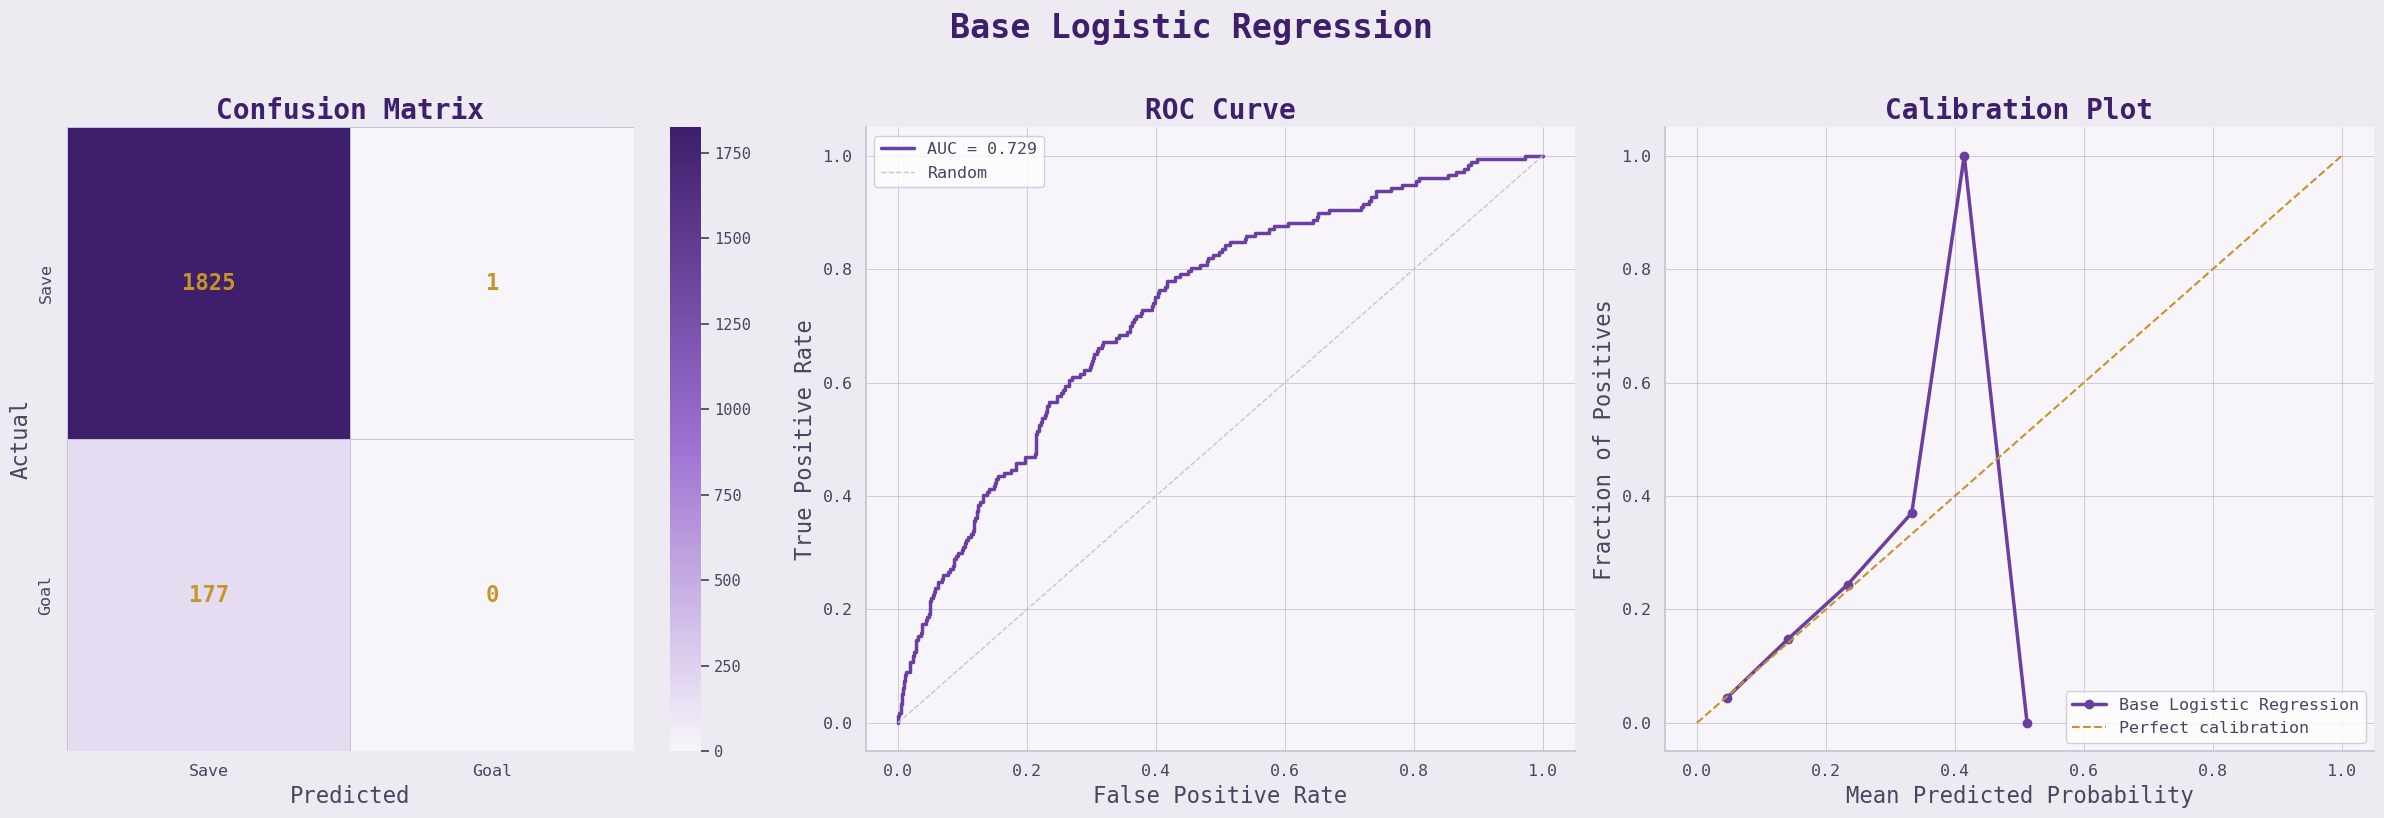

In [16]:
model_eval(logreg, X_test, y_test, "Base Logistic Regression")

The baseline starts lower than the baseline with the original dataset.  However, there should be less co-linearity in this model and should be a more 'true' dataset removing the 'other' `shot_type`.

I will still try the more minimalist features that showed the highest predictive values.  We'll see if the results are any better with the adjustments to the dataset.  Again, this will use only `x_ft`, `y_abs`, `rebound`, `slot`, `shooter_career_quality` and `goalie_career_save_pct`.

In [17]:
selected_cols = ['x_ft', 'y_abs', 'rebound', 'slot', 'shooter_career_quality', 'goalie_career_save_pct']

In [18]:
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(X_train[selected_cols], y_train)
y_pred = logreg.predict(X_test[selected_cols])


  Selected Logistic Regression
  Baseline (always predict save): 91.17%
  Accuracy:                       91.16%
  AUC:                            0.725
  Log Loss:                       0.272
  Avg Precision (PR-AUC):         0.221

              precision    recall  f1-score   support

        Save       0.91      1.00      0.95      1826
        Goal       0.00      0.00      0.00       177

    accuracy                           0.91      2003
   macro avg       0.46      0.50      0.48      2003
weighted avg       0.83      0.91      0.87      2003



/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

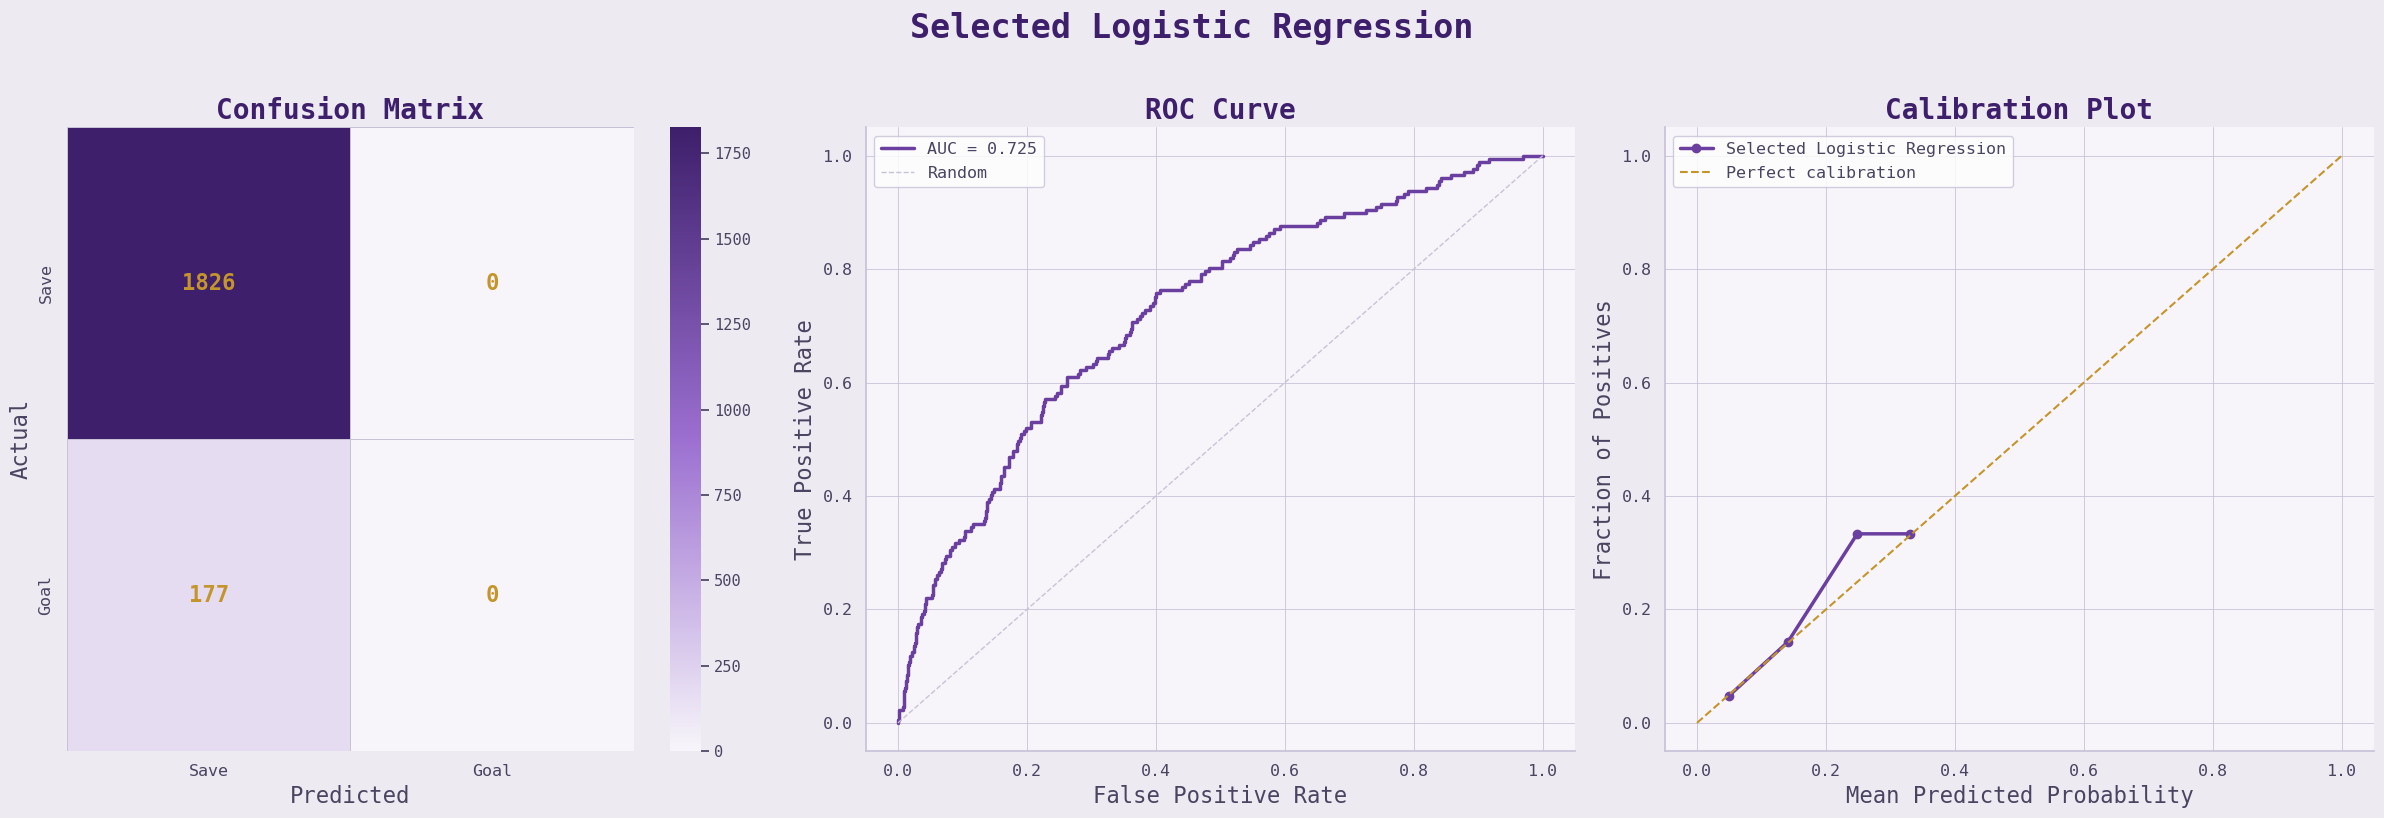

In [19]:
model_eval(logreg, X_test[selected_cols], y_test, "Selected Logistic Regression")

Both base models still guessed 'Save' for everything, so it is clear that scaling will be required to get a more meaningful model.

It is interesting to note that the drop-off between the Full feature set and the Selected features between the Base and the Even Strength datasets is different.

| DataSet | Accuracy | AUC | Log Loss |
| :------- | :------: | :------: | -------: |
| Full Data Base | 91.85% | .748 | .252 |
| Selected Data Base | 91.88% | .715 | .260 |
| Full Data Even Strength| 91.11% | .729 | .271 |
| Selected Data Even Strength| 91.16% | .725 | .272 |

This suggests that the strength state had some predictive value, but perhaps within each strength state the 6 selected features (at least for even strength) may be enough information for the modelling.

Following my previous flow, I am going to separate the continuous numerical columns and the boolean columns and experiment with using different scalers on the full dataset first, then on the selected features after.

In [20]:
continuous_col = ['game_time','x_ft', 'y_abs', 'dist_ft', 'angle_deg', 'shooter_career_quality',
                  'goalie_career_save_pct']

In [21]:
boolean_col = ['losing', 'winning', 'rebound', 'backhand', 'slap', 'snap', 'tip', 'wrist', 
               'slot', 'close_game', 'is_forward', 'pwhl']

In [22]:
X_train = X_train[continuous_col+boolean_col]
X_test = X_test[continuous_col+boolean_col]


  Log Reg — Full Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       91.16%
  AUC:                            0.738
  Log Loss:                       0.268
  Avg Precision (PR-AUC):         0.23

              precision    recall  f1-score   support

        Save       0.91      1.00      0.95      1826
        Goal       0.50      0.01      0.01       177

    accuracy                           0.91      2003
   macro avg       0.71      0.50      0.48      2003
weighted avg       0.88      0.91      0.87      2003



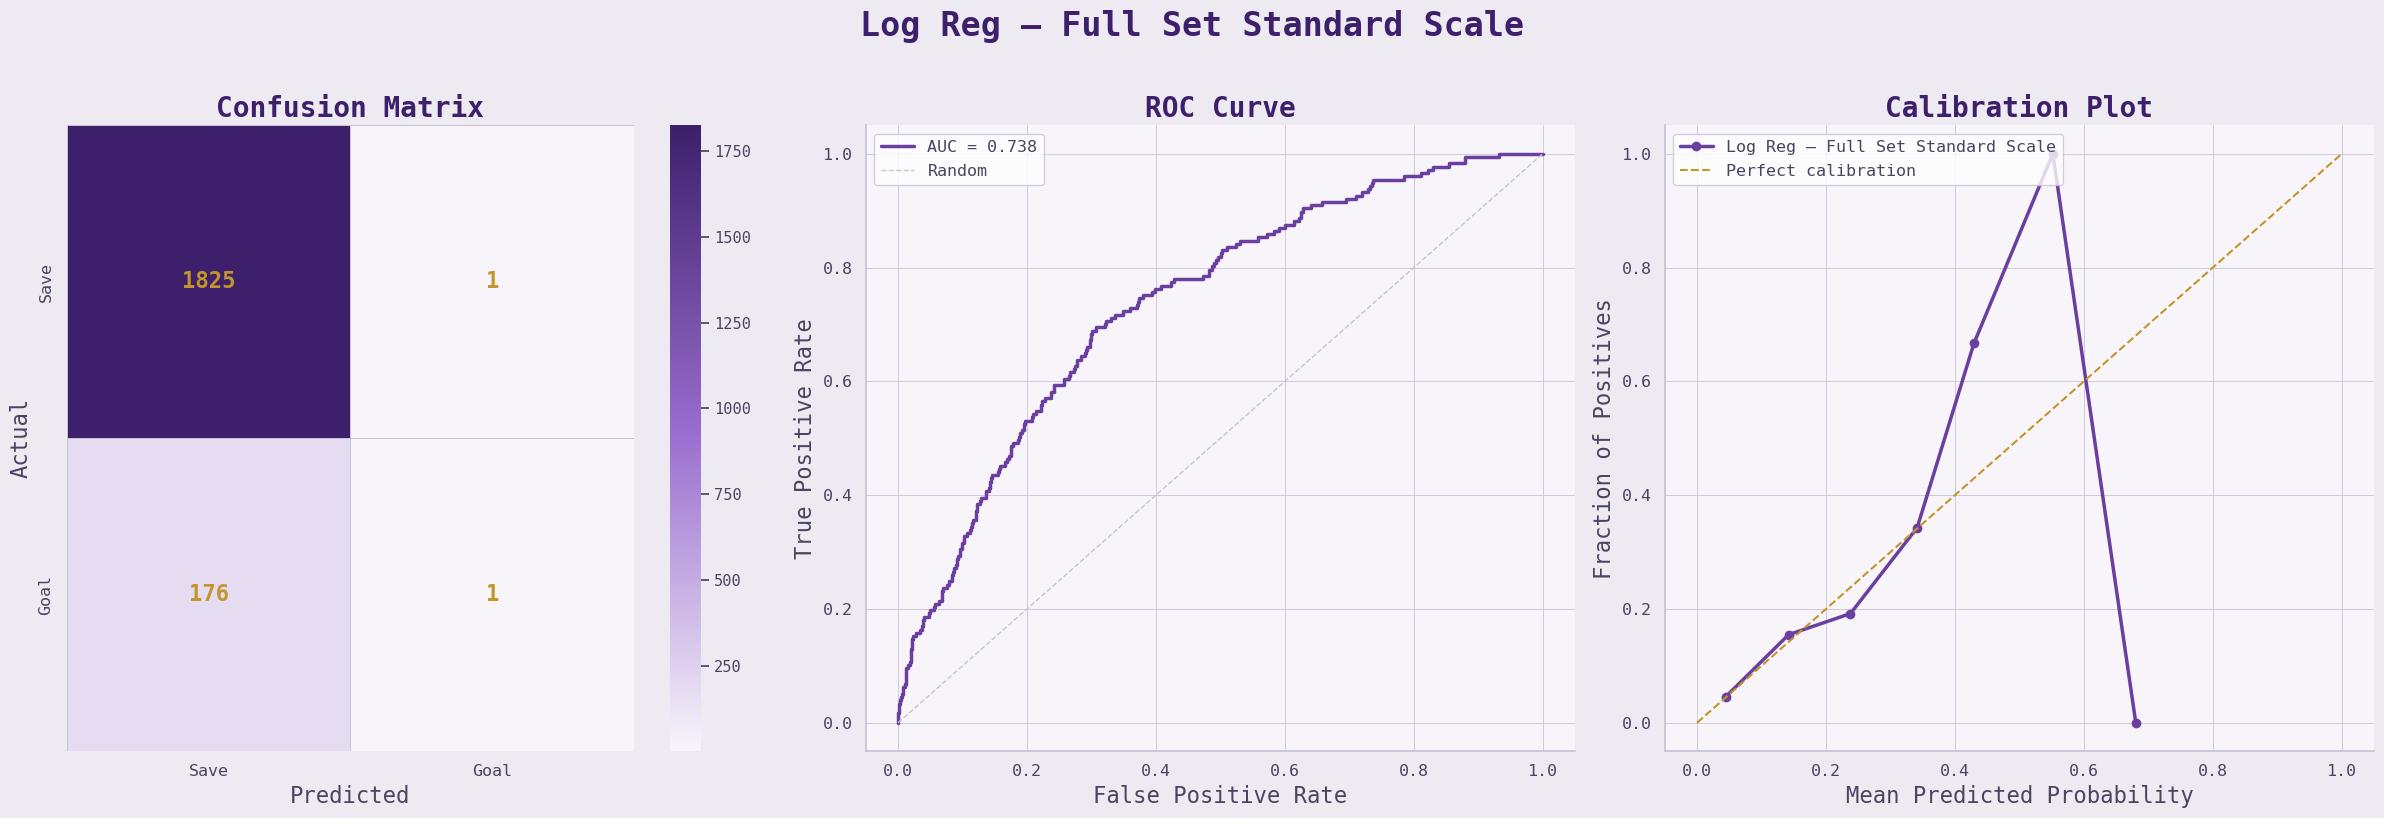

In [23]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(random_state=29))
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, model_name="Log Reg — Full Set Standard Scale")


  Log Reg - Full Set MinMax Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       91.16%
  AUC:                            0.735
  Log Loss:                       0.269
  Avg Precision (PR-AUC):         0.23

              precision    recall  f1-score   support

        Save       0.91      1.00      0.95      1826
        Goal       0.50      0.01      0.01       177

    accuracy                           0.91      2003
   macro avg       0.71      0.50      0.48      2003
weighted avg       0.88      0.91      0.87      2003



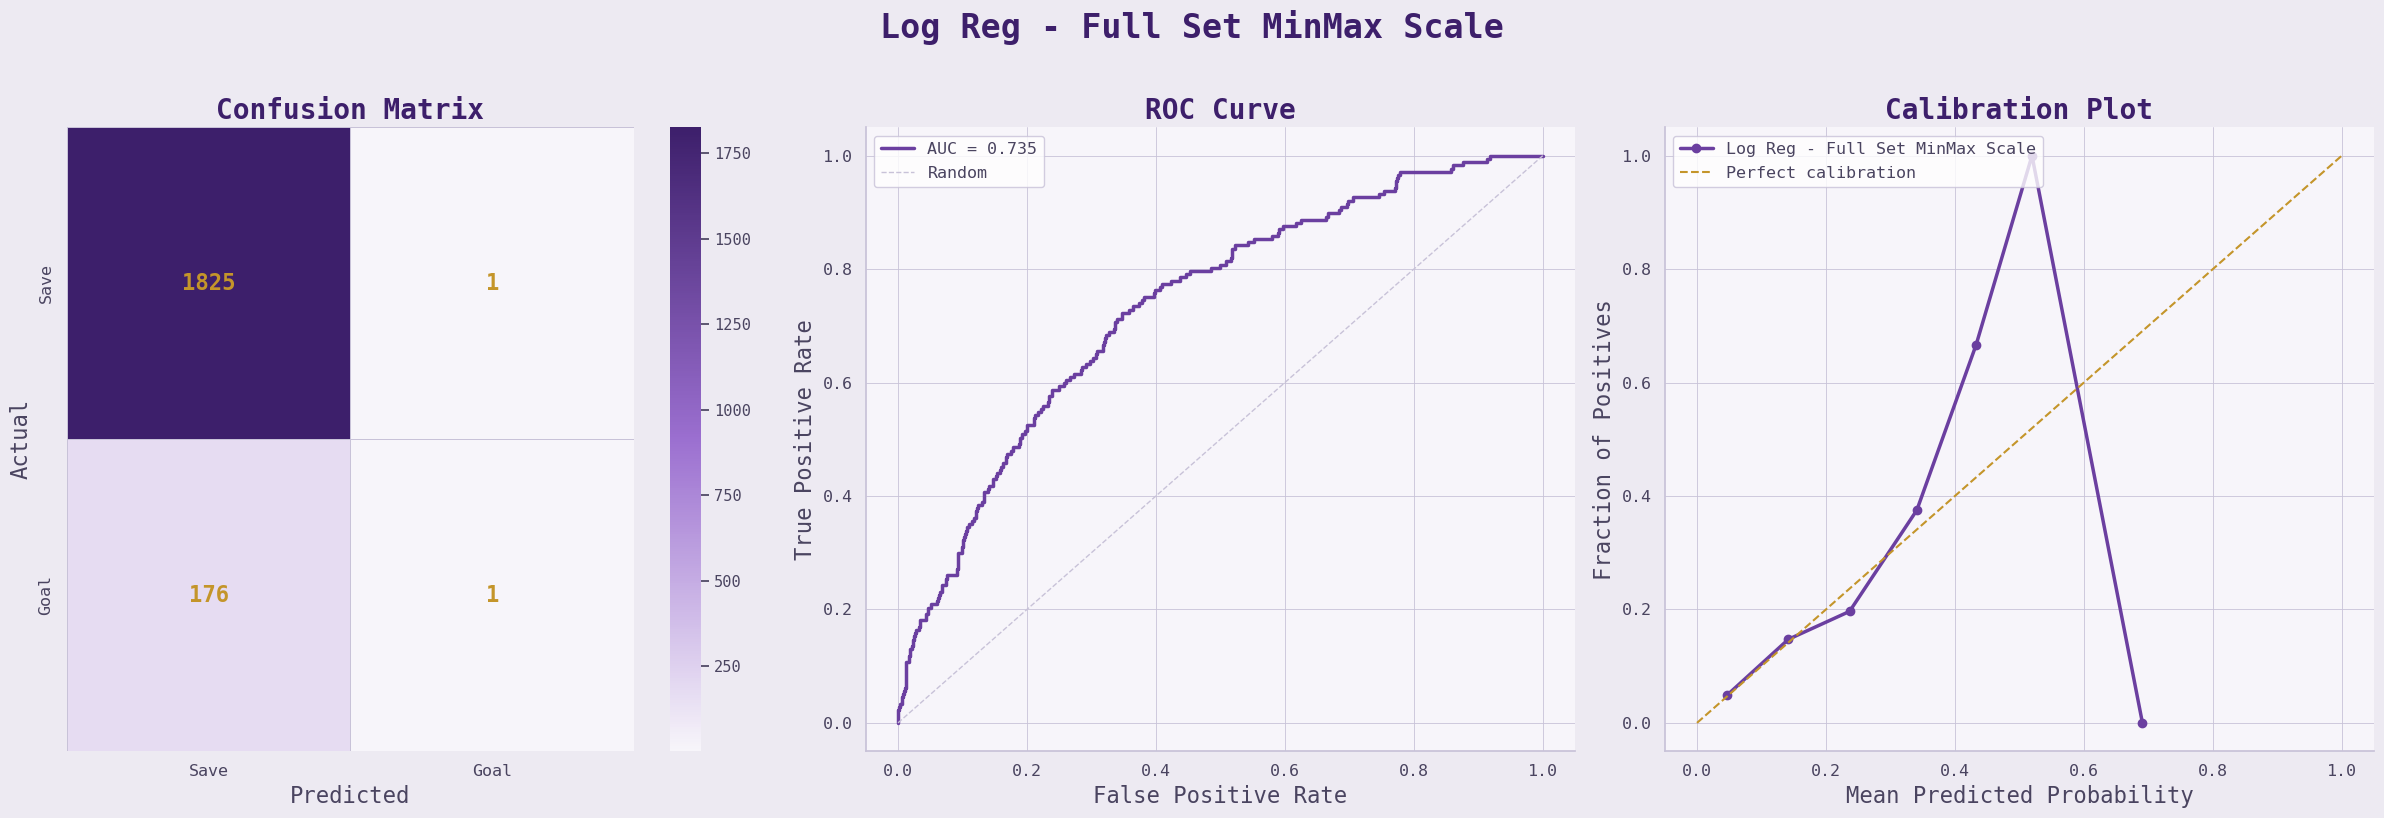

In [24]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(random_state=29))
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, "Log Reg - Full Set MinMax Scale")

In [25]:
continuous_col_sel = [c for c in continuous_col if c in selected_cols]
boolean_col_sel    = [c for c in boolean_col    if c in selected_cols]


  Selected Log Reg - Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       91.21%
  AUC:                            0.737
  Log Loss:                       0.269
  Avg Precision (PR-AUC):         0.229

              precision    recall  f1-score   support

        Save       0.91      1.00      0.95      1826
        Goal       1.00      0.01      0.01       177

    accuracy                           0.91      2003
   macro avg       0.96      0.50      0.48      2003
weighted avg       0.92      0.91      0.87      2003



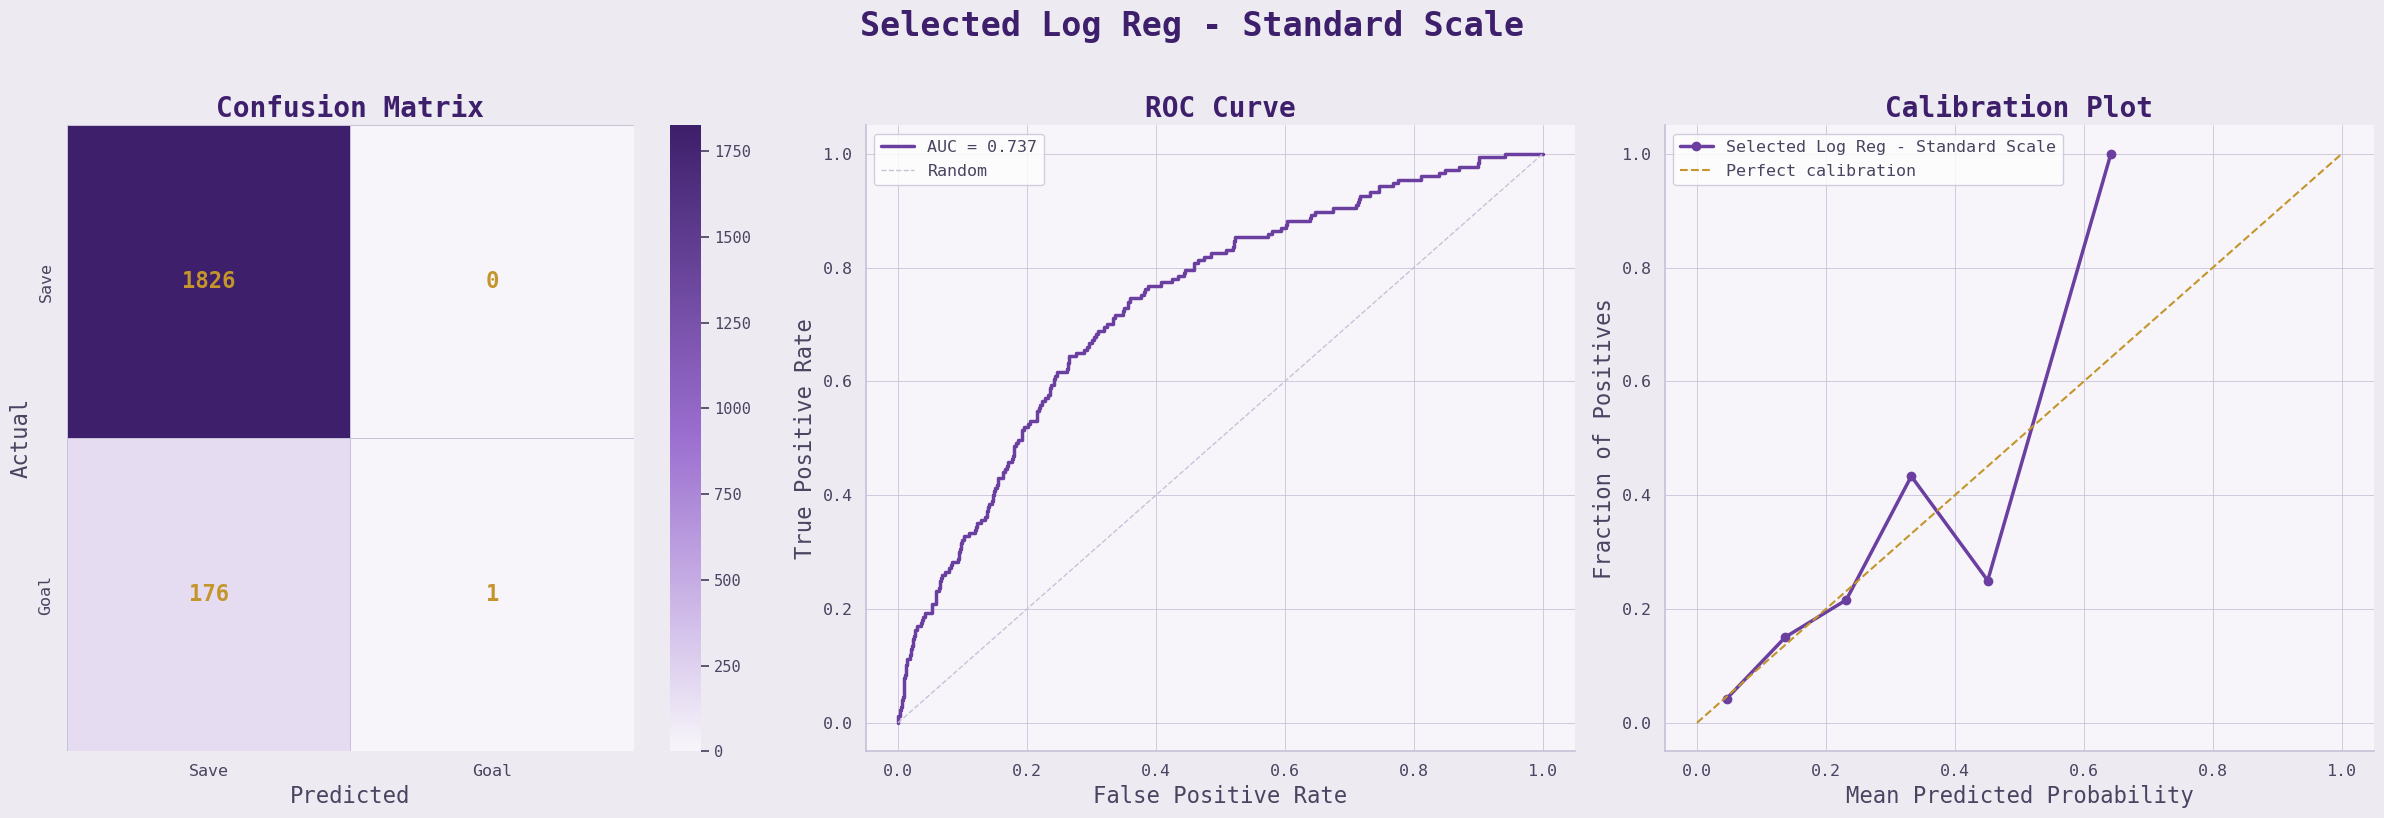

In [26]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(random_state=29))
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, "Selected Log Reg - Standard Scale")


  Selected Log Reg - MinMax Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       91.21%
  AUC:                            0.738
  Log Loss:                       0.269
  Avg Precision (PR-AUC):         0.23

              precision    recall  f1-score   support

        Save       0.91      1.00      0.95      1826
        Goal       1.00      0.01      0.01       177

    accuracy                           0.91      2003
   macro avg       0.96      0.50      0.48      2003
weighted avg       0.92      0.91      0.87      2003



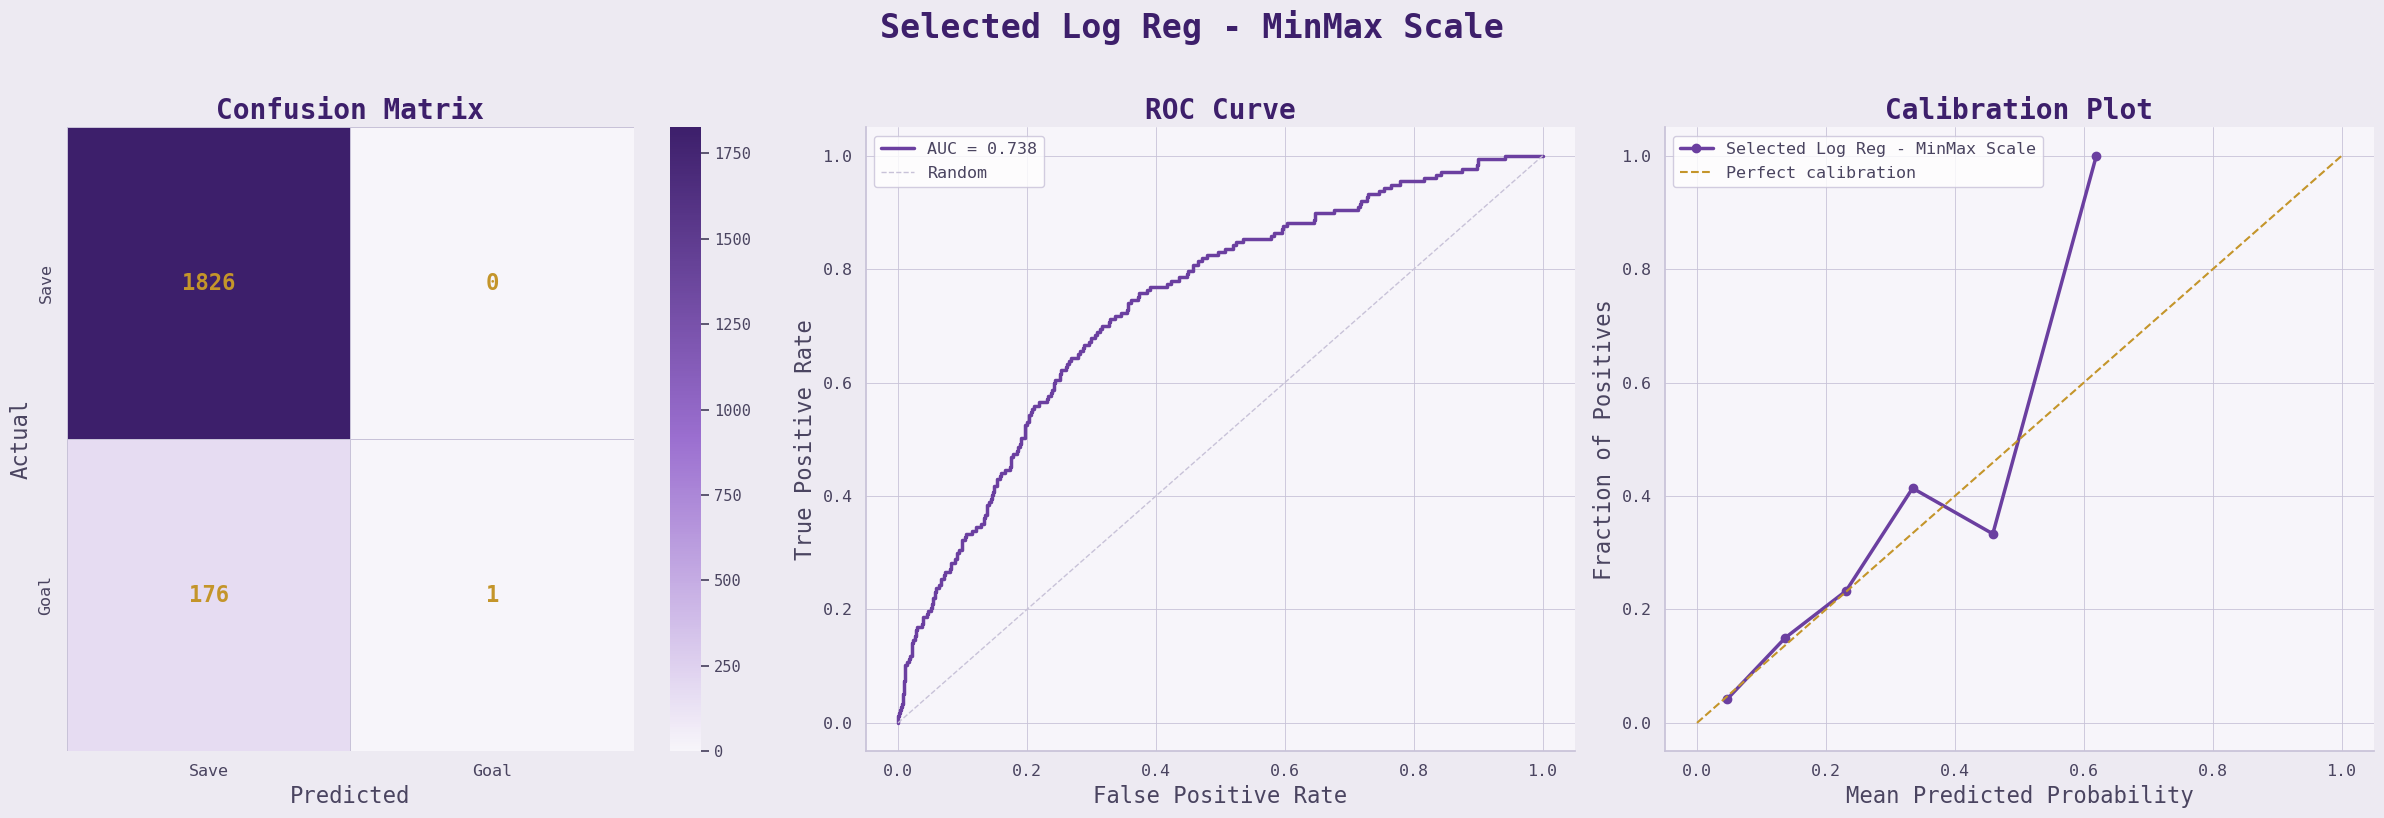

In [27]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(random_state=29))
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, "Selected Log Reg - MinMax Scale")

For the first time, we actually see an improvement on the models with the Selected features.  Although it wasn't much (the models guessed 'Goal' only once, but it was correct), this is still promising that the changes we've made may produce a more helpful outcome.

Next we will try to balance the data and see it it yields better results.


  Balanced Log Reg — Full Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       67.1%
  AUC:                            0.737
  Log Loss:                       0.588
  Avg Precision (PR-AUC):         0.224

              precision    recall  f1-score   support

        Save       0.96      0.67      0.79      1826
        Goal       0.17      0.70      0.27       177

    accuracy                           0.67      2003
   macro avg       0.56      0.68      0.53      2003
weighted avg       0.89      0.67      0.74      2003



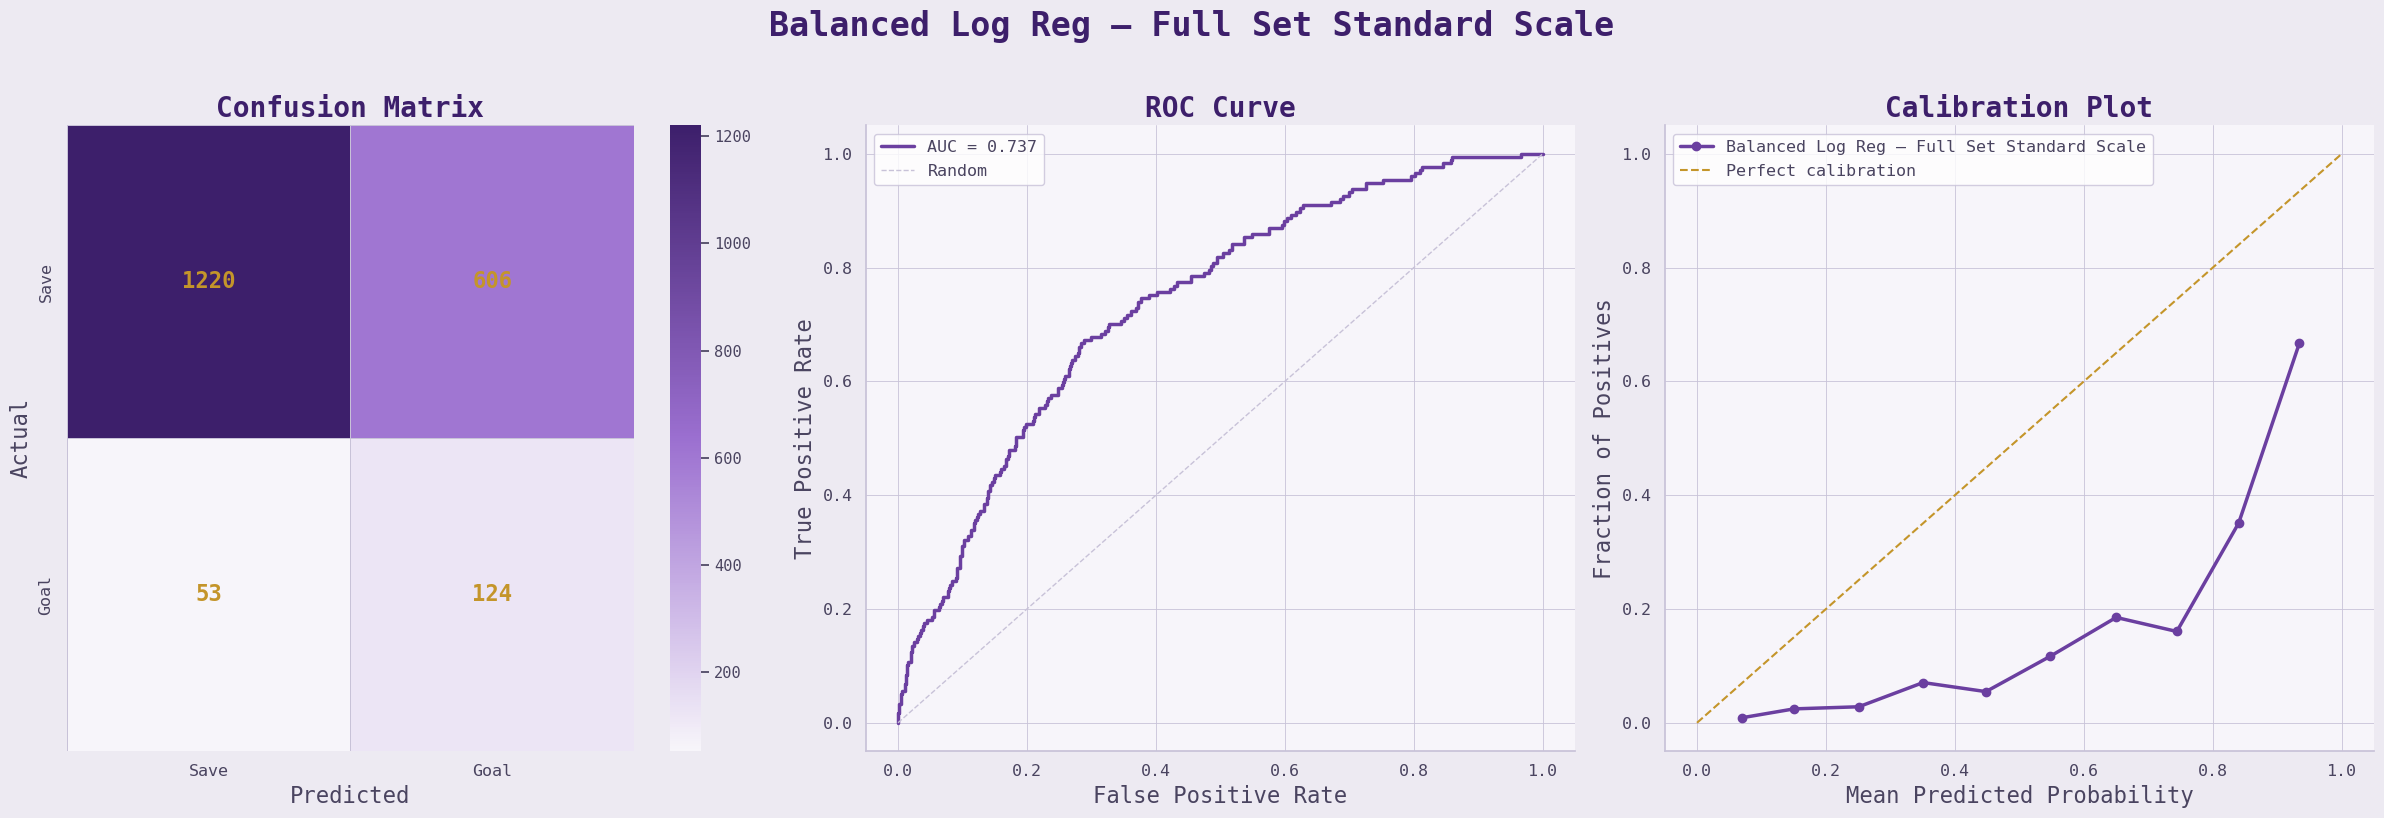

In [28]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(class_weight = 'balanced', random_state=29))
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, model_name="Balanced Log Reg — Full Set Standard Scale")


  Balanced Log Reg — Full Set MinMax Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       67.05%
  AUC:                            0.735
  Log Loss:                       0.59
  Avg Precision (PR-AUC):         0.226

              precision    recall  f1-score   support

        Save       0.96      0.67      0.79      1826
        Goal       0.17      0.68      0.27       177

    accuracy                           0.67      2003
   macro avg       0.56      0.68      0.53      2003
weighted avg       0.89      0.67      0.74      2003



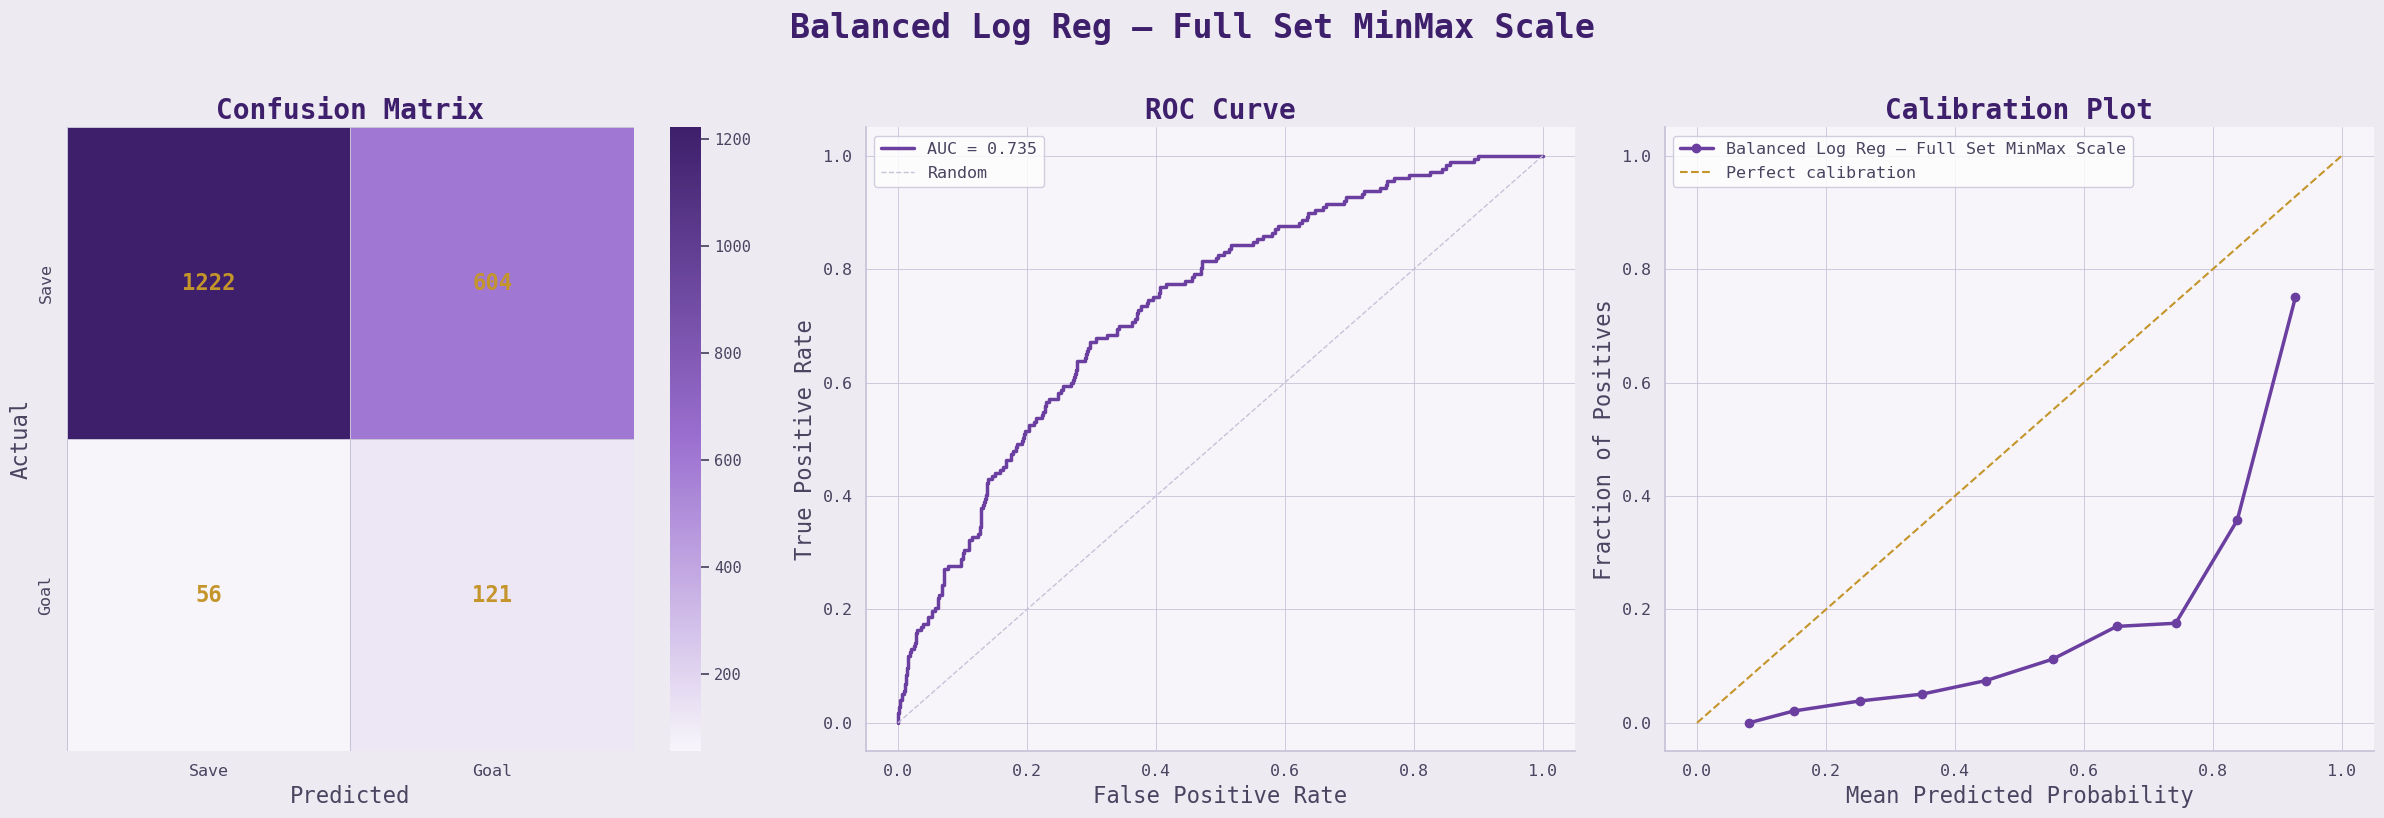

In [29]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(class_weight = 'balanced', random_state=29))
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, model_name="Balanced Log Reg — Full Set MinMax Scale")


  Balanced Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       65.6%
  AUC:                            0.738
  Log Loss:                       0.598
  Avg Precision (PR-AUC):         0.228

              precision    recall  f1-score   support

        Save       0.96      0.65      0.77      1826
        Goal       0.17      0.73      0.27       177

    accuracy                           0.66      2003
   macro avg       0.56      0.69      0.52      2003
weighted avg       0.89      0.66      0.73      2003



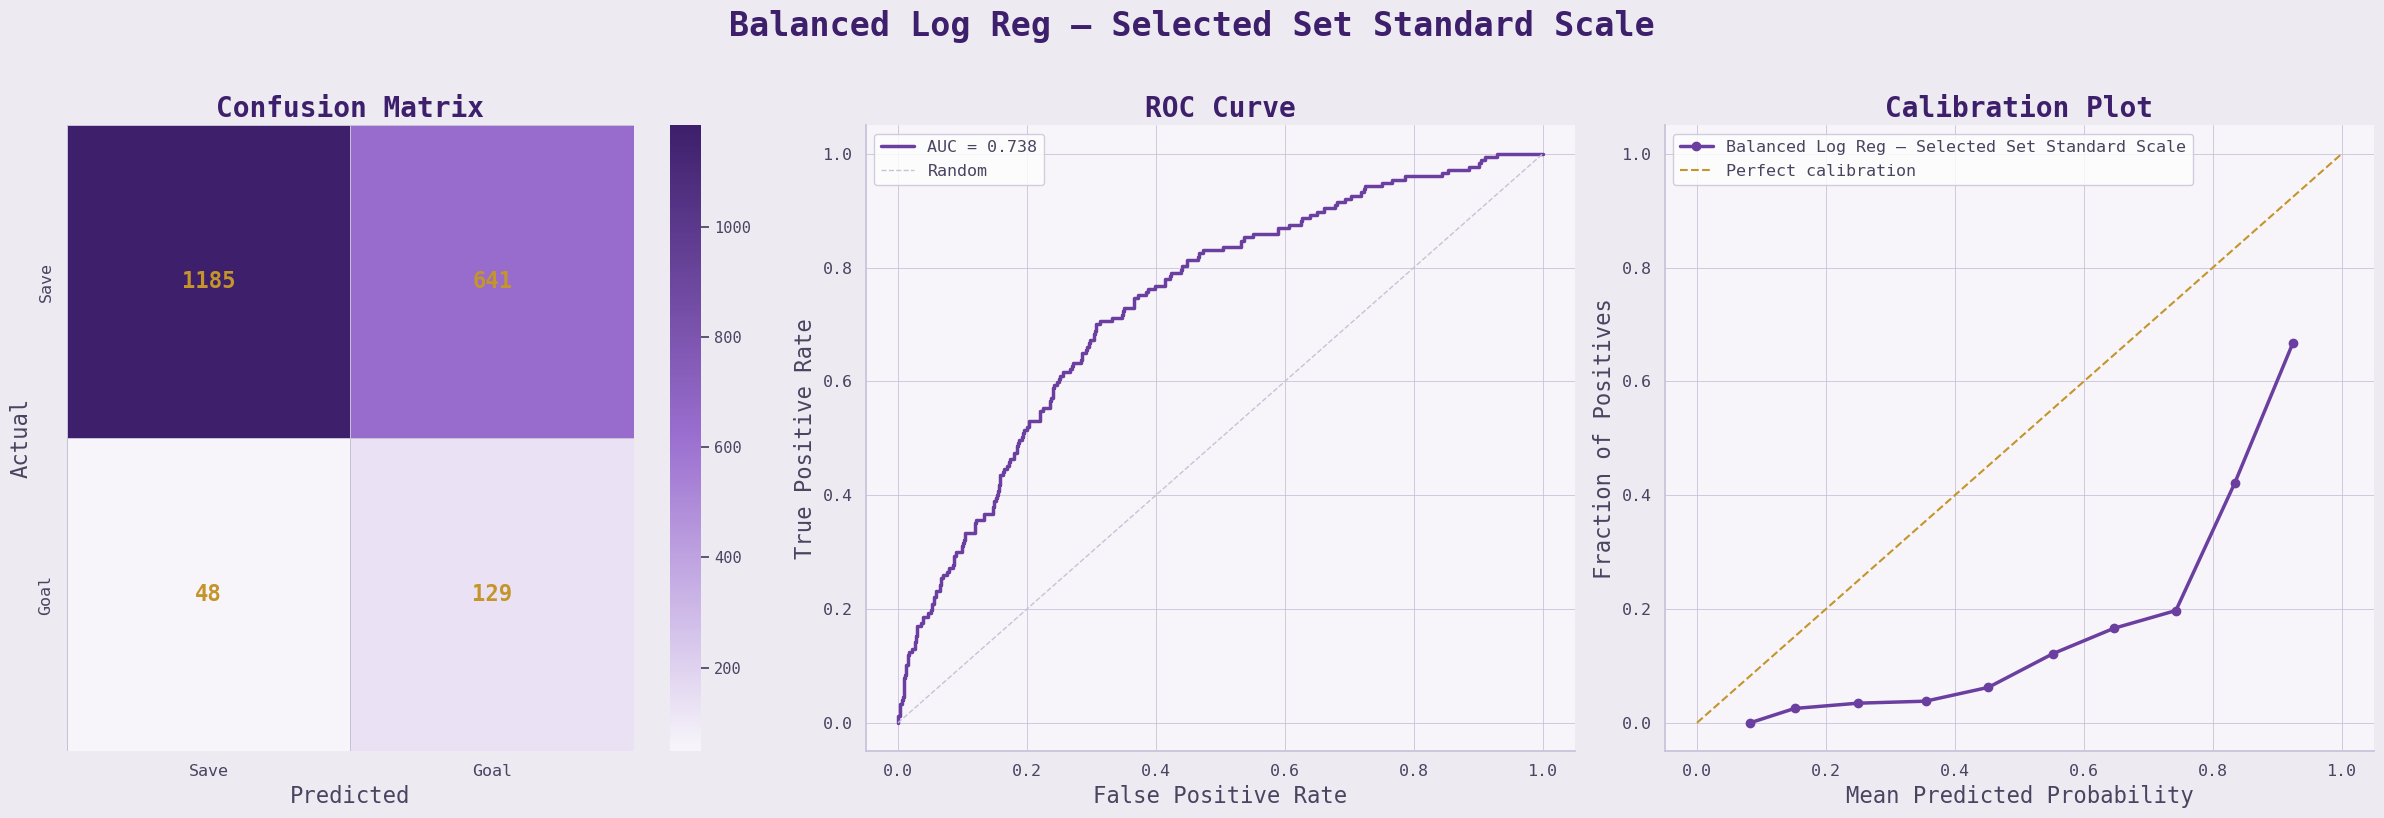

In [30]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(class_weight = 'balanced', random_state=29))
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, model_name="Balanced Log Reg — Selected Set Standard Scale")


  Balanced Log Reg — Selected Set MinMax Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       65.55%
  AUC:                            0.738
  Log Loss:                       0.598
  Avg Precision (PR-AUC):         0.229

              precision    recall  f1-score   support

        Save       0.96      0.65      0.77      1826
        Goal       0.17      0.73      0.27       177

    accuracy                           0.66      2003
   macro avg       0.56      0.69      0.52      2003
weighted avg       0.89      0.66      0.73      2003



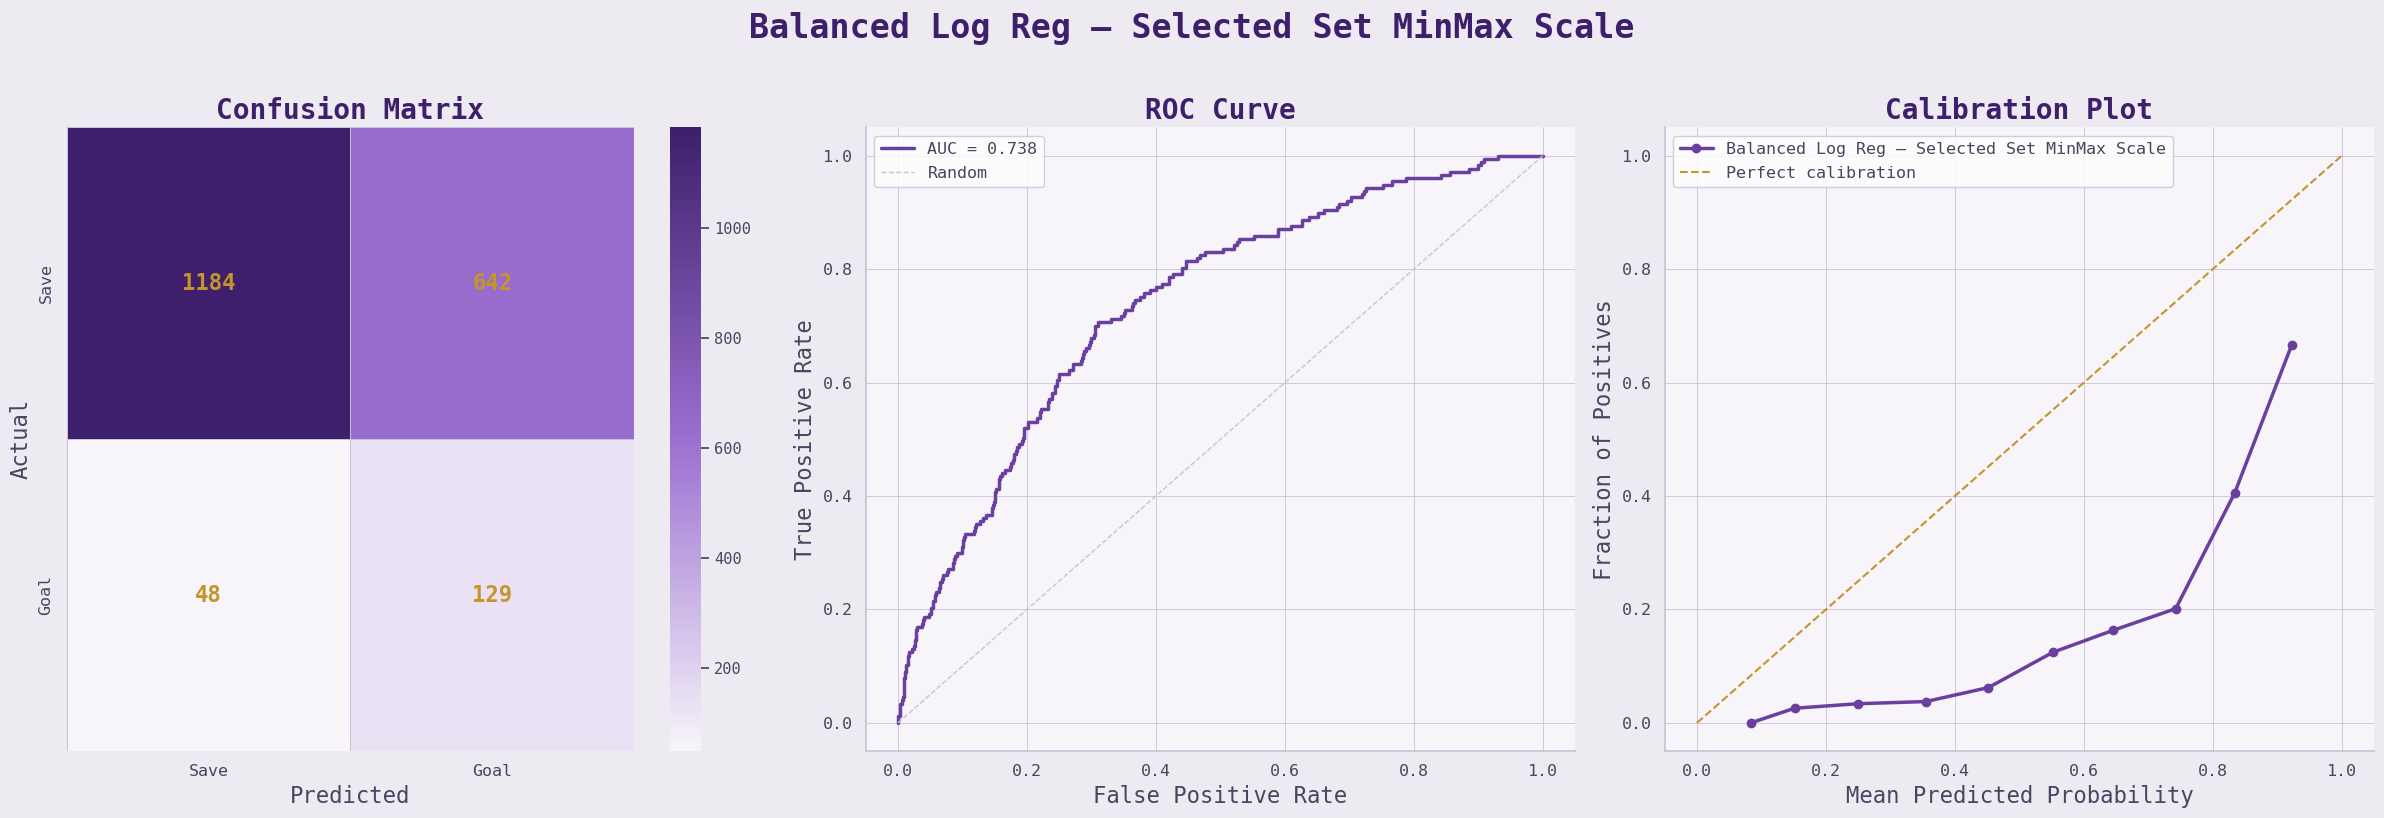

In [31]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(class_weight = 'balanced', random_state=29))
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, model_name="Balanced Log Reg — Selected Set MinMax Scale")

We again see the Selected features outperforming the full dataset, if only slightly.  However, the performance still dropped significantly once it started to guess for more goals.

Now I will try to use SMOTE instead to balance the data.


  SMOTE Log Reg — Full Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       67.55%
  AUC:                            0.732
  Log Loss:                       0.589
  Avg Precision (PR-AUC):         0.215

              precision    recall  f1-score   support

        Save       0.96      0.68      0.79      1826
        Goal       0.17      0.68      0.27       177

    accuracy                           0.68      2003
   macro avg       0.56      0.68      0.53      2003
weighted avg       0.89      0.68      0.75      2003



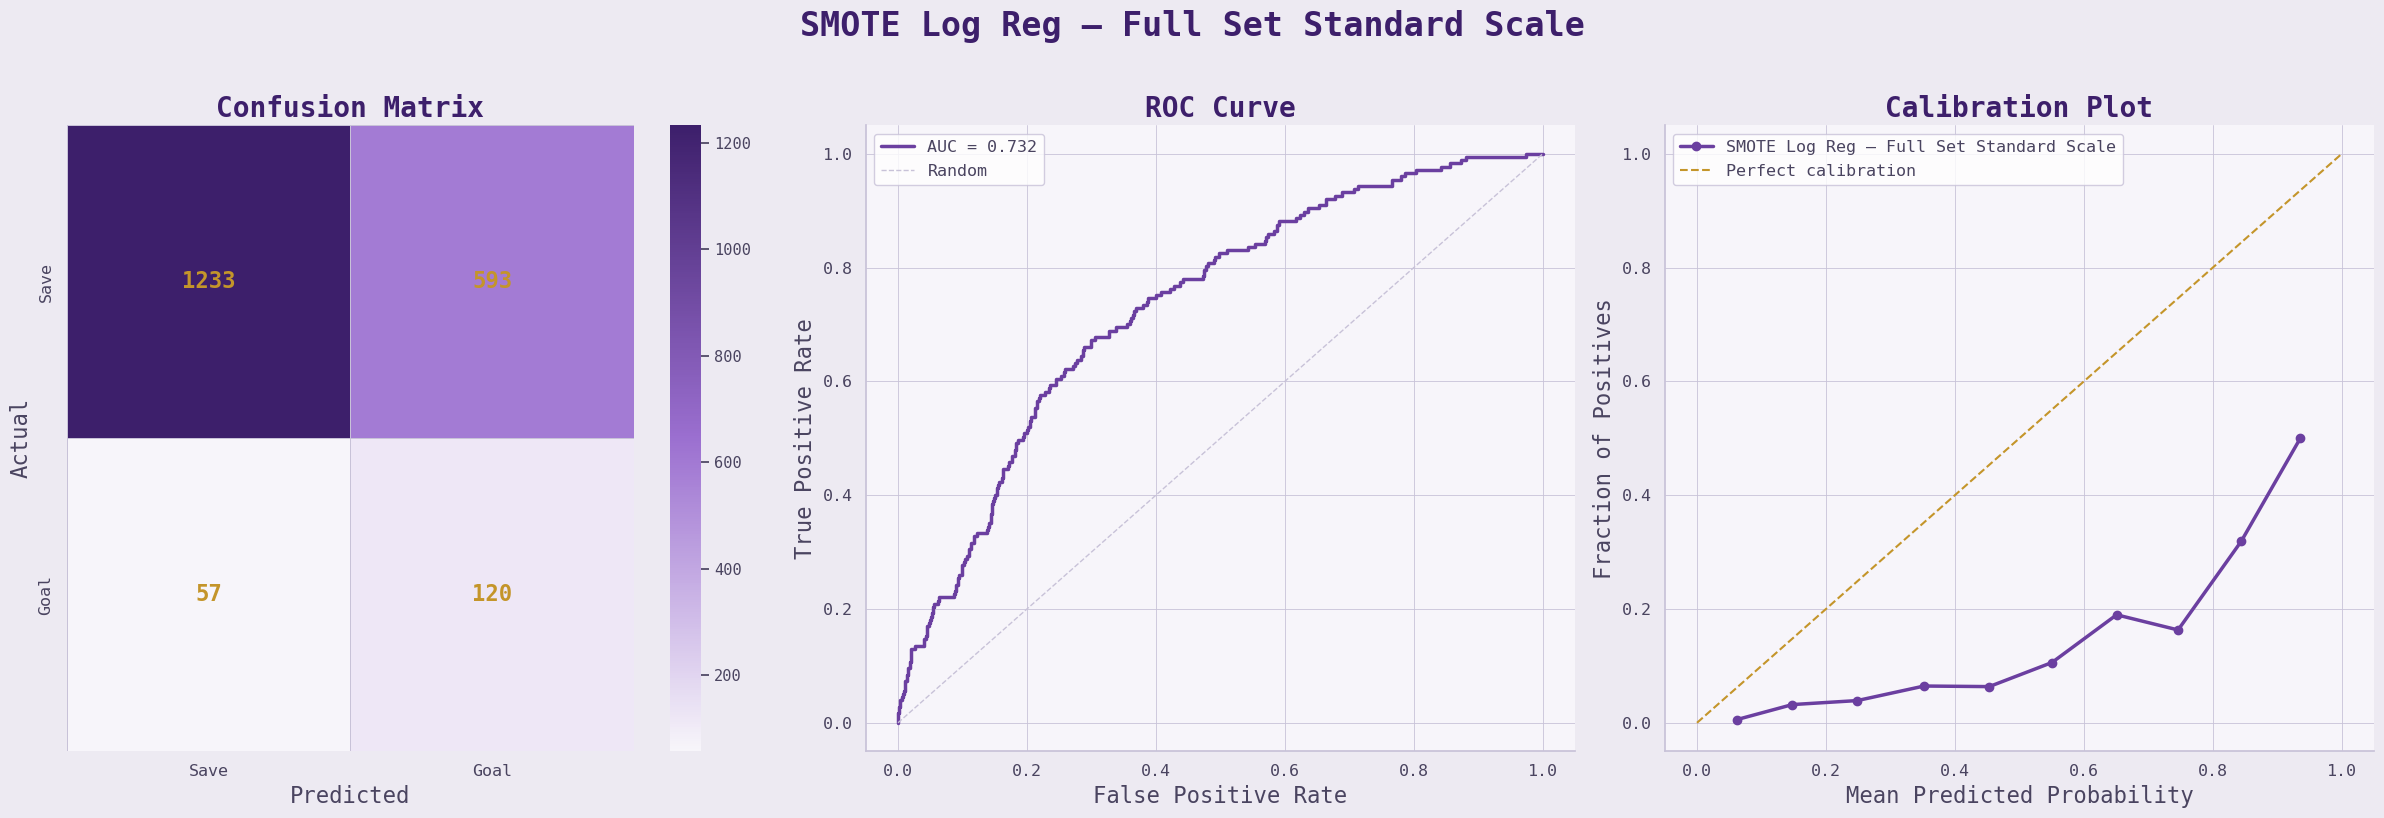

In [32]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote',        SMOTE(random_state=29)),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, model_name="SMOTE Log Reg — Full Set Standard Scale")


  SMOTE Log Reg — Full Set MinMax Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       66.65%
  AUC:                            0.731
  Log Loss:                       0.593
  Avg Precision (PR-AUC):         0.216

              precision    recall  f1-score   support

        Save       0.96      0.66      0.78      1826
        Goal       0.17      0.69      0.27       177

    accuracy                           0.67      2003
   macro avg       0.56      0.68      0.53      2003
weighted avg       0.89      0.67      0.74      2003



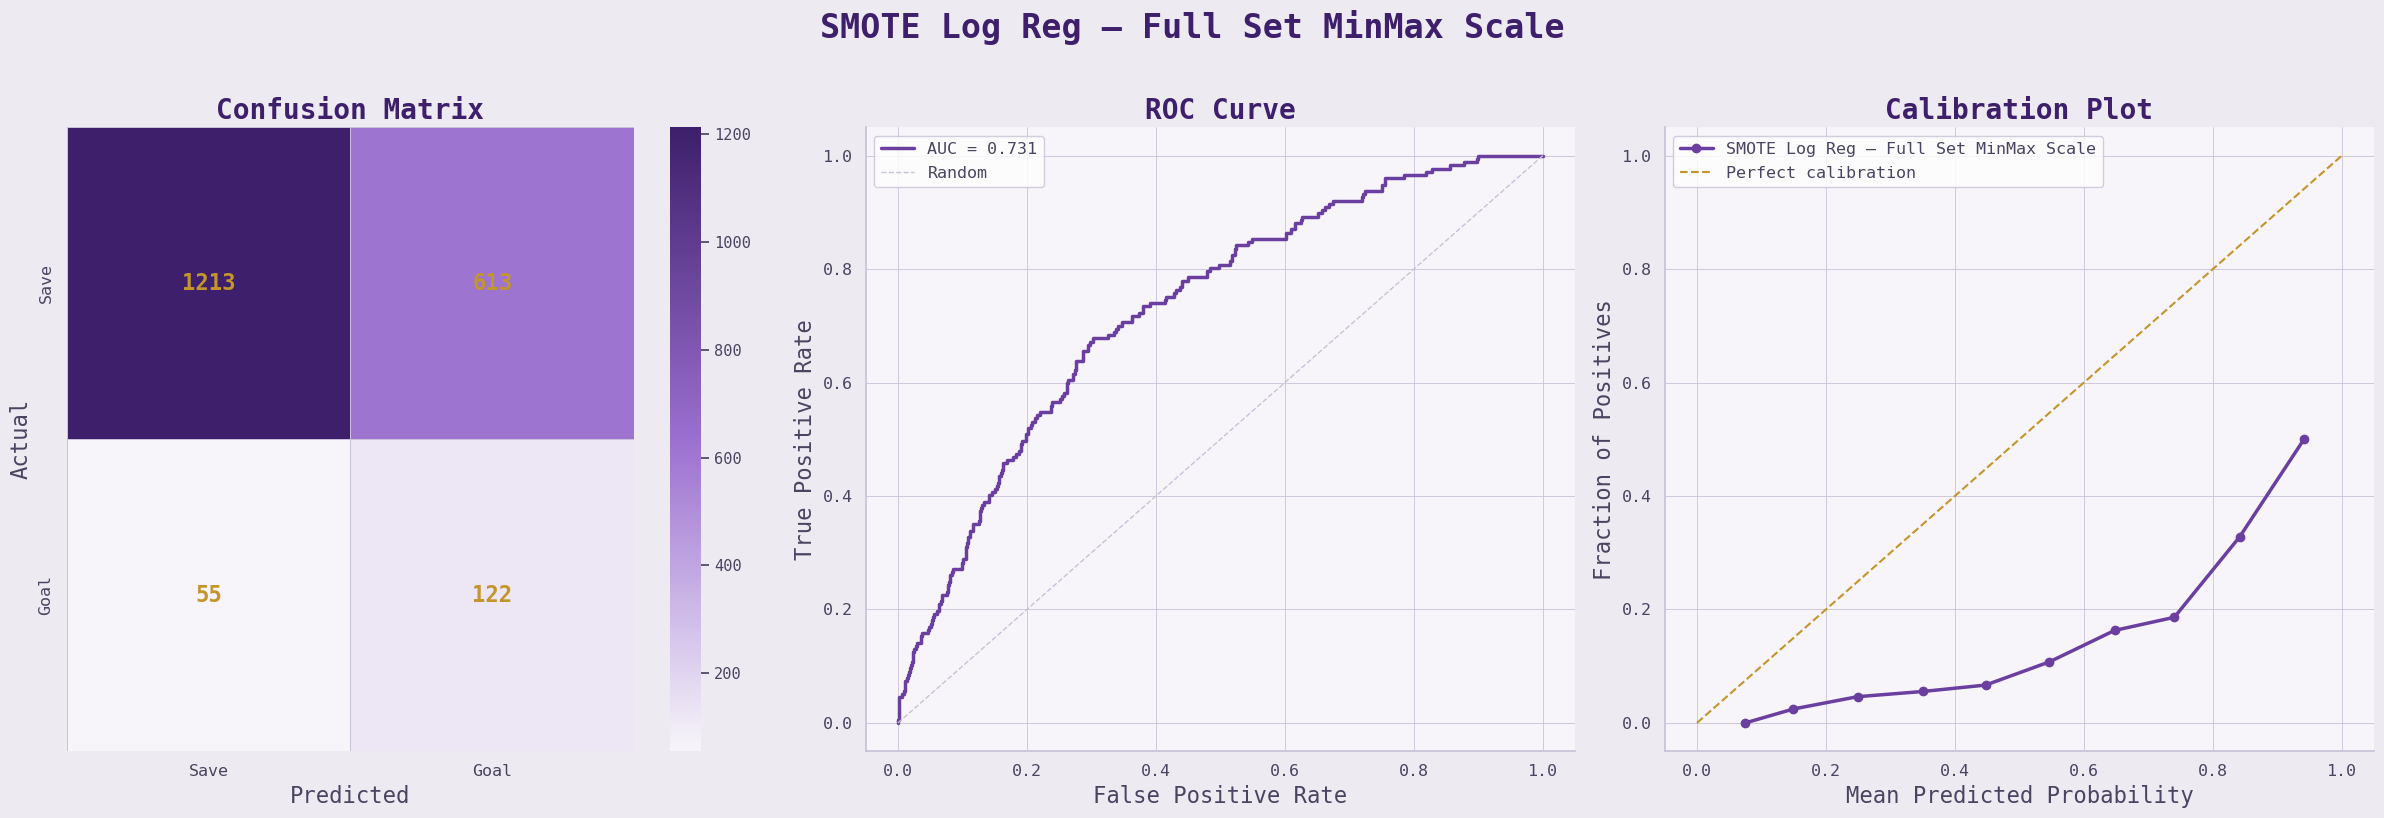

In [33]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote',        SMOTE(random_state=29)),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train, y_train)
model_eval(pipeline, X_test, y_test, model_name="SMOTE Log Reg — Full Set MinMax Scale")


  SMOTE Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       65.1%
  AUC:                            0.734
  Log Loss:                       0.6
  Avg Precision (PR-AUC):         0.224

              precision    recall  f1-score   support

        Save       0.96      0.64      0.77      1826
        Goal       0.17      0.73      0.27       177

    accuracy                           0.65      2003
   macro avg       0.56      0.69      0.52      2003
weighted avg       0.89      0.65      0.73      2003



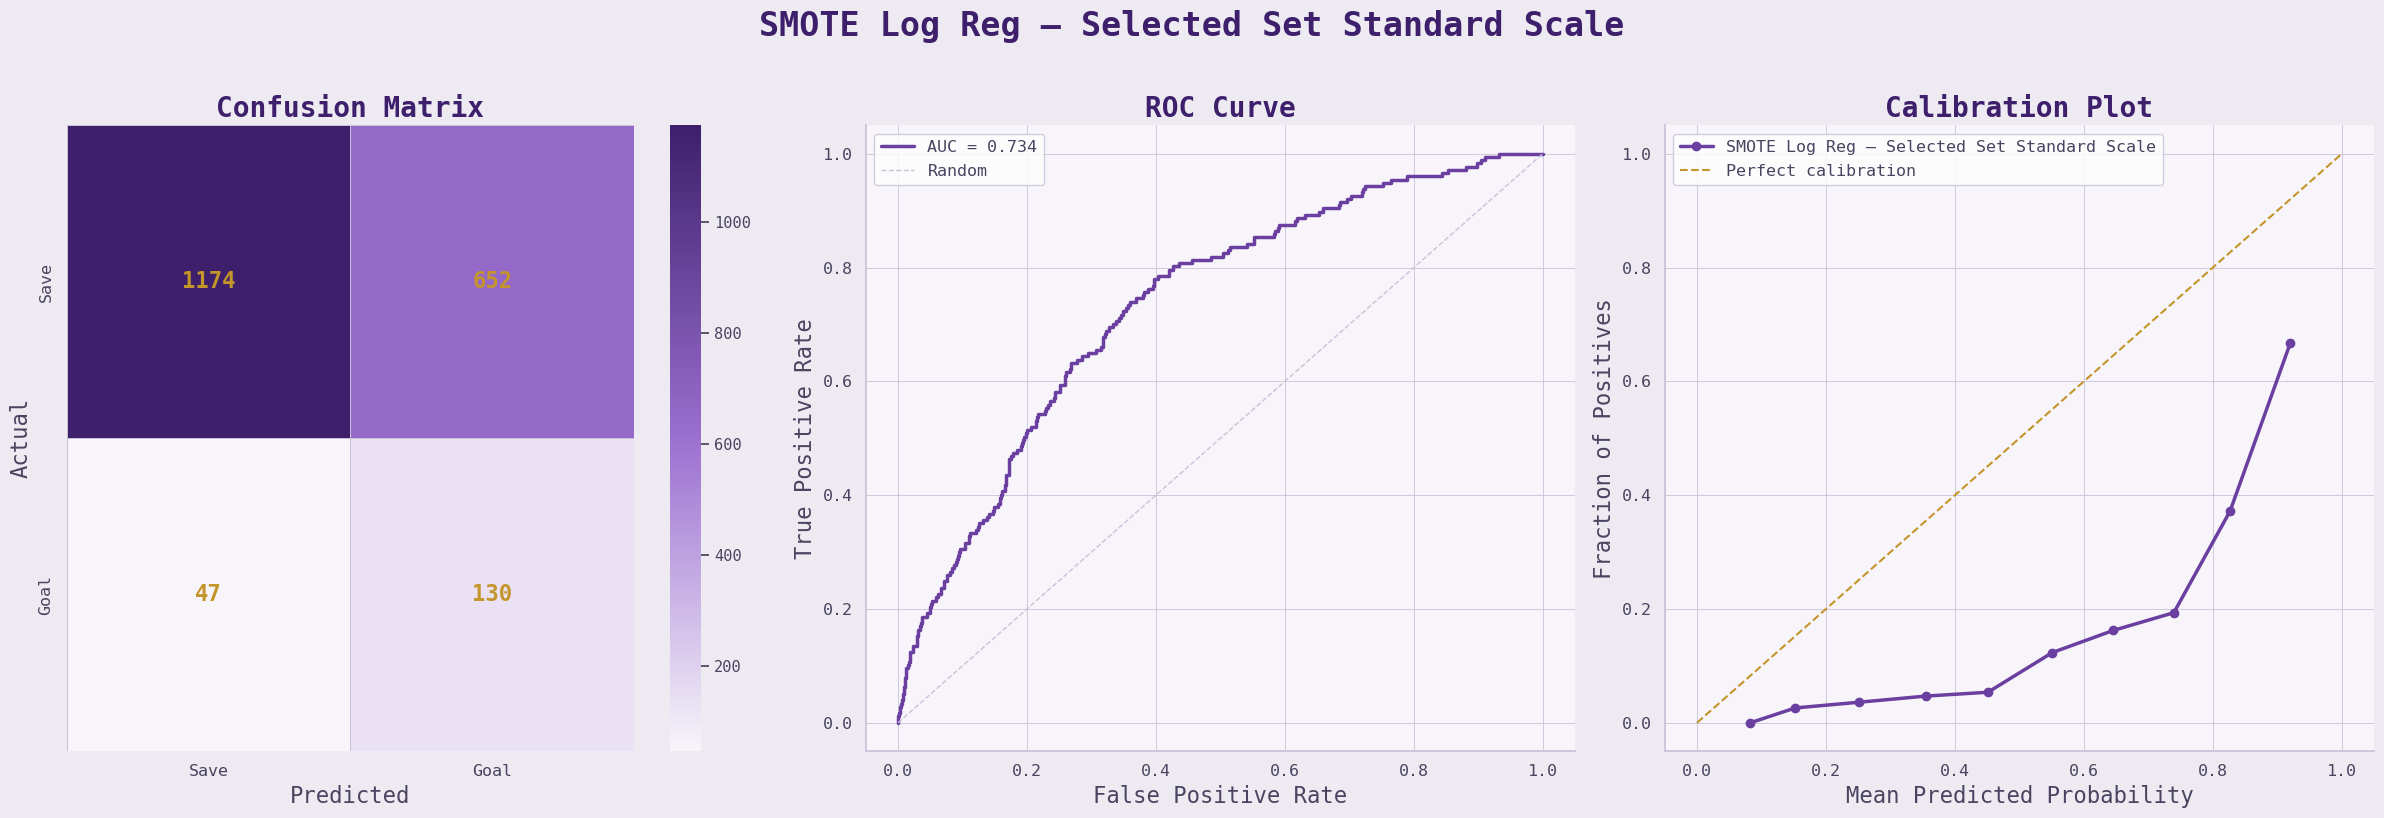

In [34]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote',        SMOTE(random_state=29)),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, model_name="SMOTE Log Reg — Selected Set Standard Scale")


  SMOTE Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       65.05%
  AUC:                            0.735
  Log Loss:                       0.6
  Avg Precision (PR-AUC):         0.225

              precision    recall  f1-score   support

        Save       0.96      0.64      0.77      1826
        Goal       0.17      0.74      0.27       177

    accuracy                           0.65      2003
   macro avg       0.56      0.69      0.52      2003
weighted avg       0.89      0.65      0.73      2003



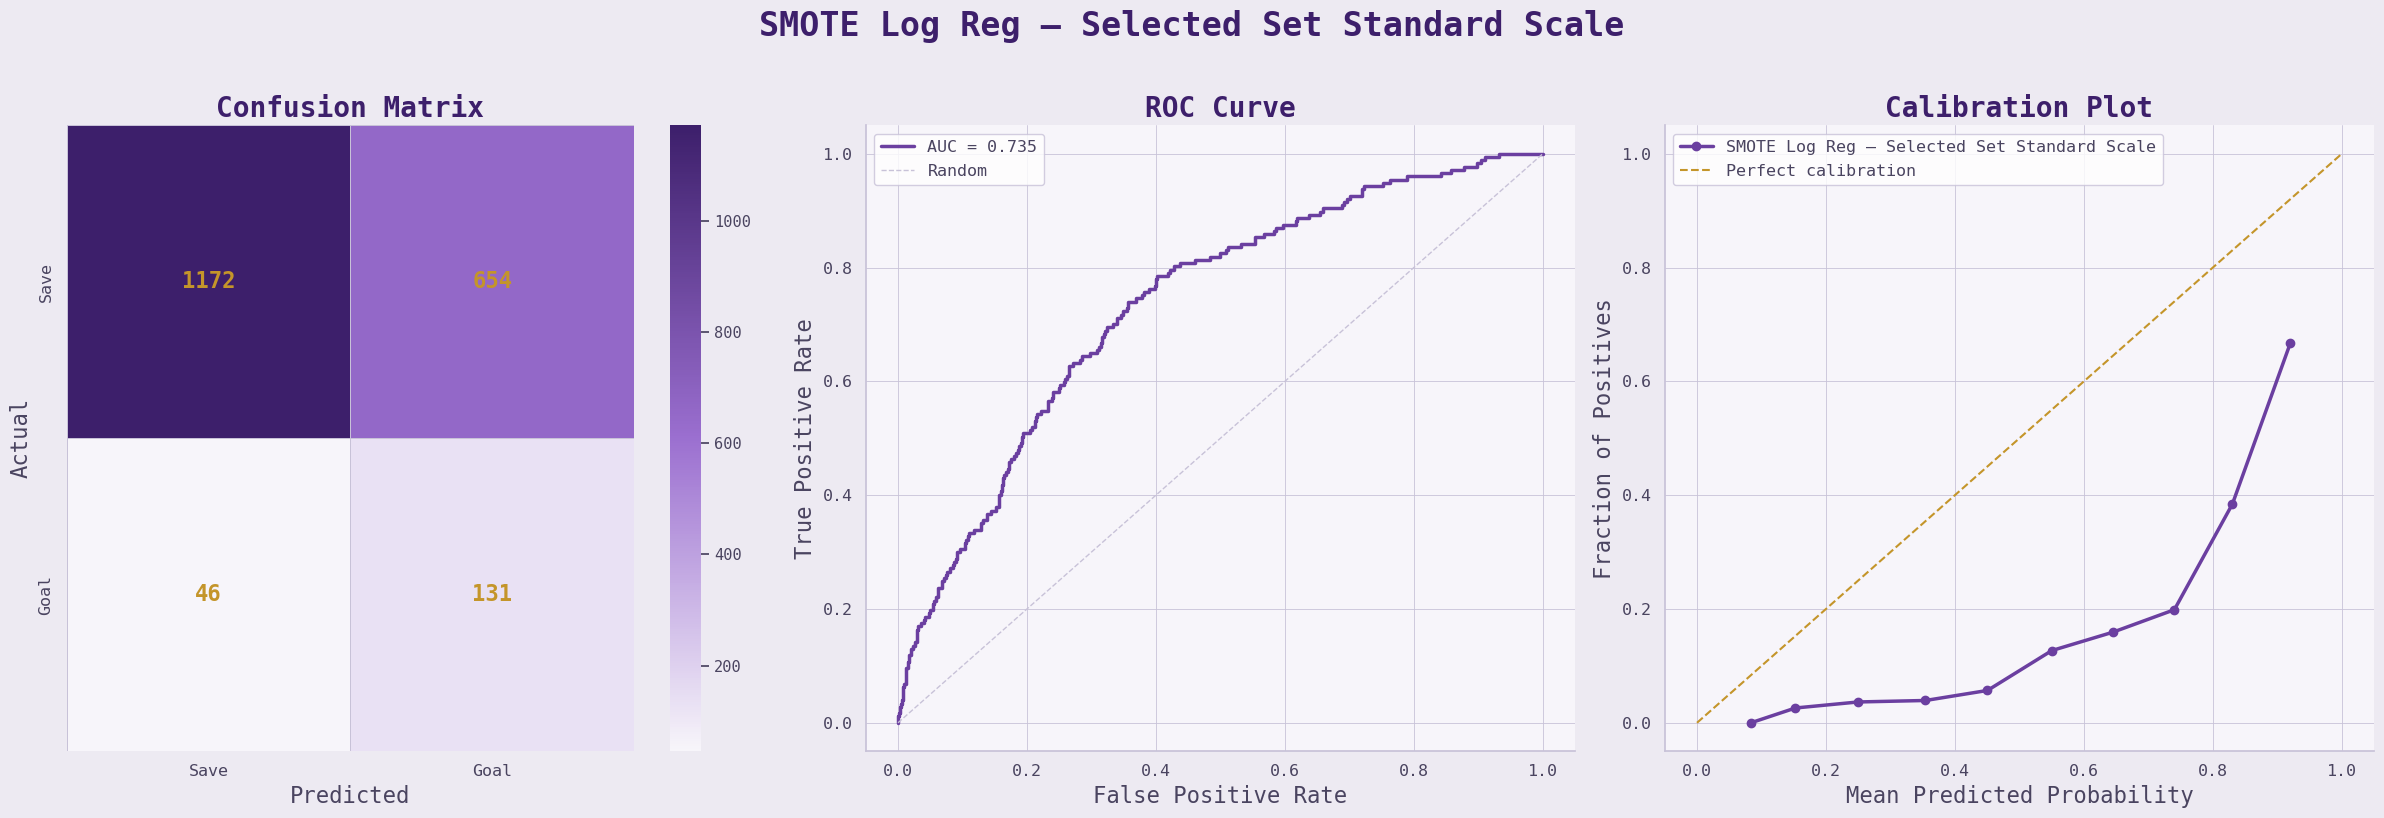

In [35]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote',        SMOTE(random_state=29)),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline, X_test[selected_cols], y_test, model_name="SMOTE Log Reg — Selected Set Standard Scale")

We are continuing to see a consistent pattern between the Base Dataset, the Even Strength dataset, the Full features and the Selected features:

- Full Base Data, performing best but with known issues
- Selected Even Strength Data, slightly outperforming...
- Full Even Strength Data
- Selected Base Data performing the worst overall

If this pattern continues to hold, the Even Strength Data using just the Selected features, while still not performing up to a necessary standard, may be the cleanest way to get an xG model that is simple and understandable.

Now I will lower the threshold for predicting a goal.  The hope is that the models will increase the number of guesses for goals, which may lower the accuracy of the model but improve its applicability.


   Lowered (0.25) Log Reg — Full Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       89.72%
  AUC:                            0.738
  Log Loss:                       0.268
  Avg Precision (PR-AUC):         0.23

              precision    recall  f1-score   support

        Save       0.92      0.97      0.94      1826
        Goal       0.33      0.16      0.21       177

    accuracy                           0.90      2003
   macro avg       0.63      0.56      0.58      2003
weighted avg       0.87      0.90      0.88      2003



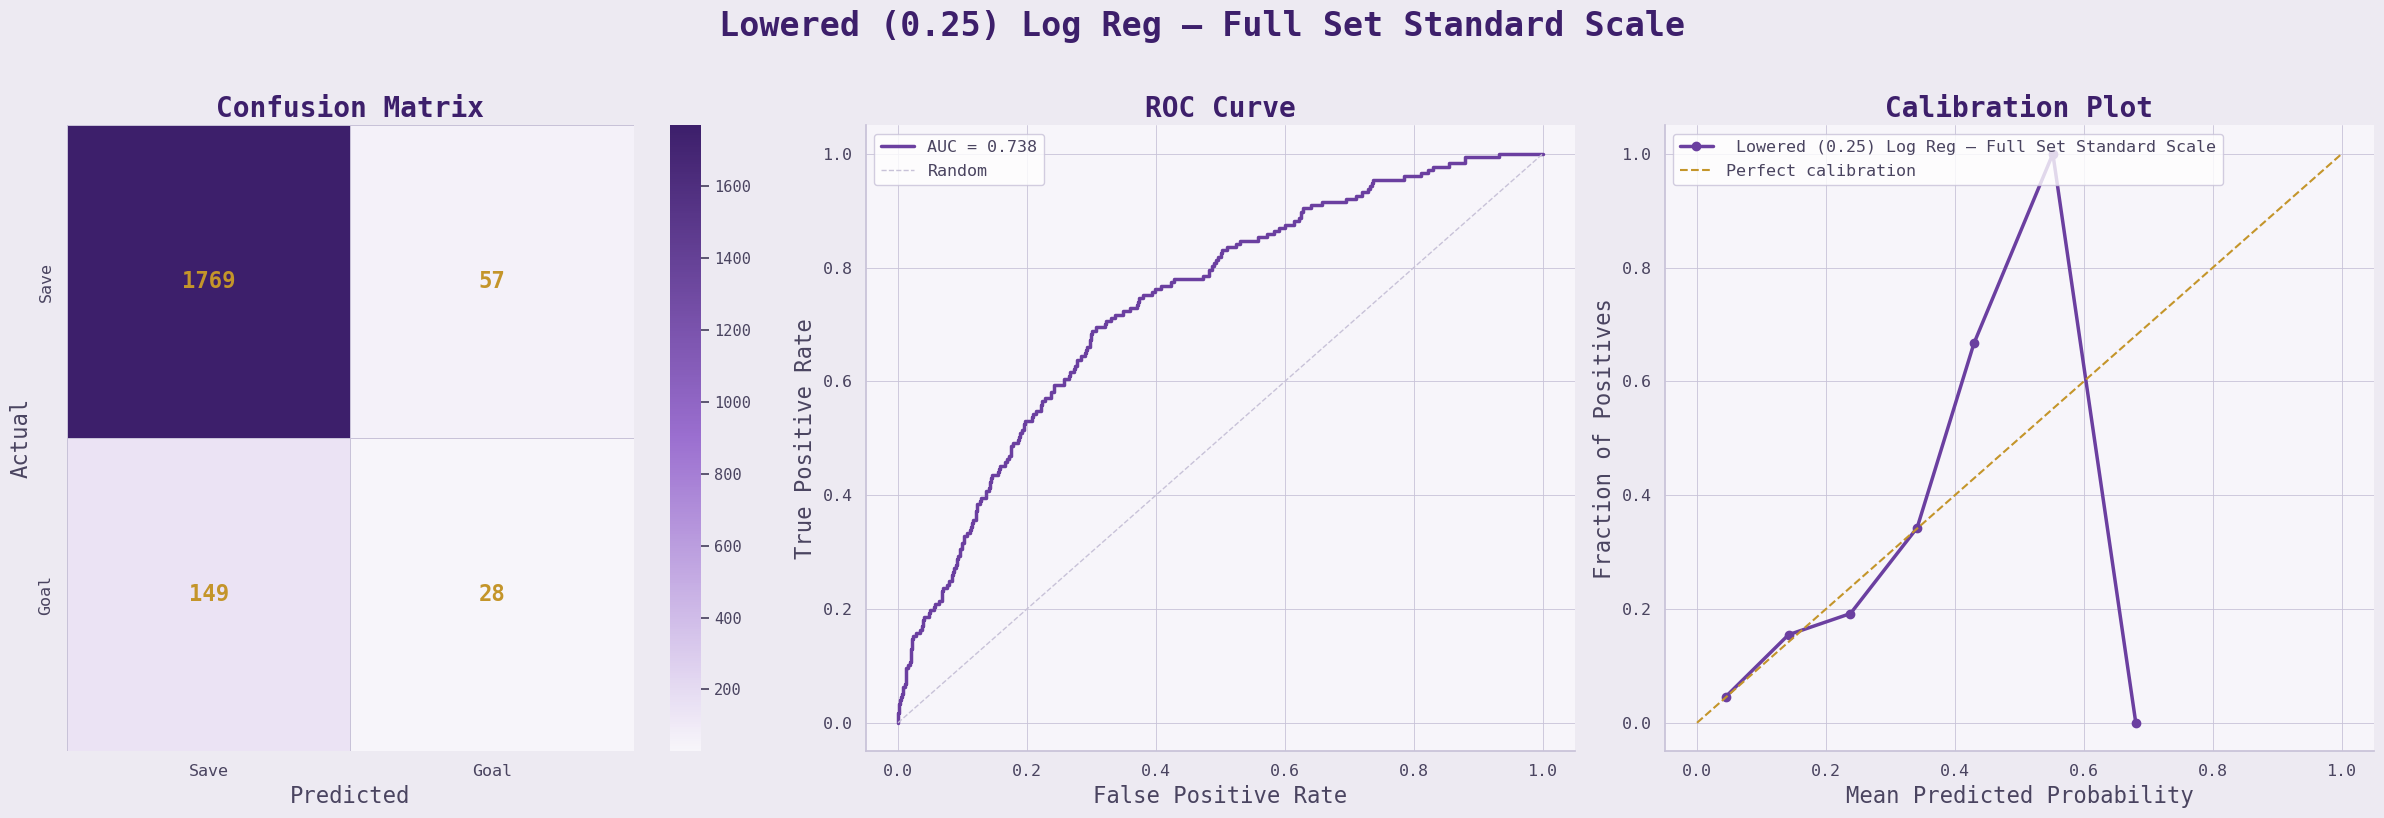

In [36]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train, y_train)
model_eval(pipeline,
           X_test,
           y_test,
           model_name=" Lowered (0.25) Log Reg — Full Set Standard Scale",
           threshold = 0.25)

We got more guesses for goals, the recall is still pretty low but it does outperform the recall using the Base dataset (from 0.30 to 0.33). I'll lower the threshold even lower to see the effect on the model.


   Lowered (0.1) Log Reg — Full Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       70.39%
  AUC:                            0.738
  Log Loss:                       0.268
  Avg Precision (PR-AUC):         0.23

              precision    recall  f1-score   support

        Save       0.95      0.71      0.81      1826
        Goal       0.18      0.65      0.28       177

    accuracy                           0.70      2003
   macro avg       0.57      0.68      0.55      2003
weighted avg       0.89      0.70      0.77      2003



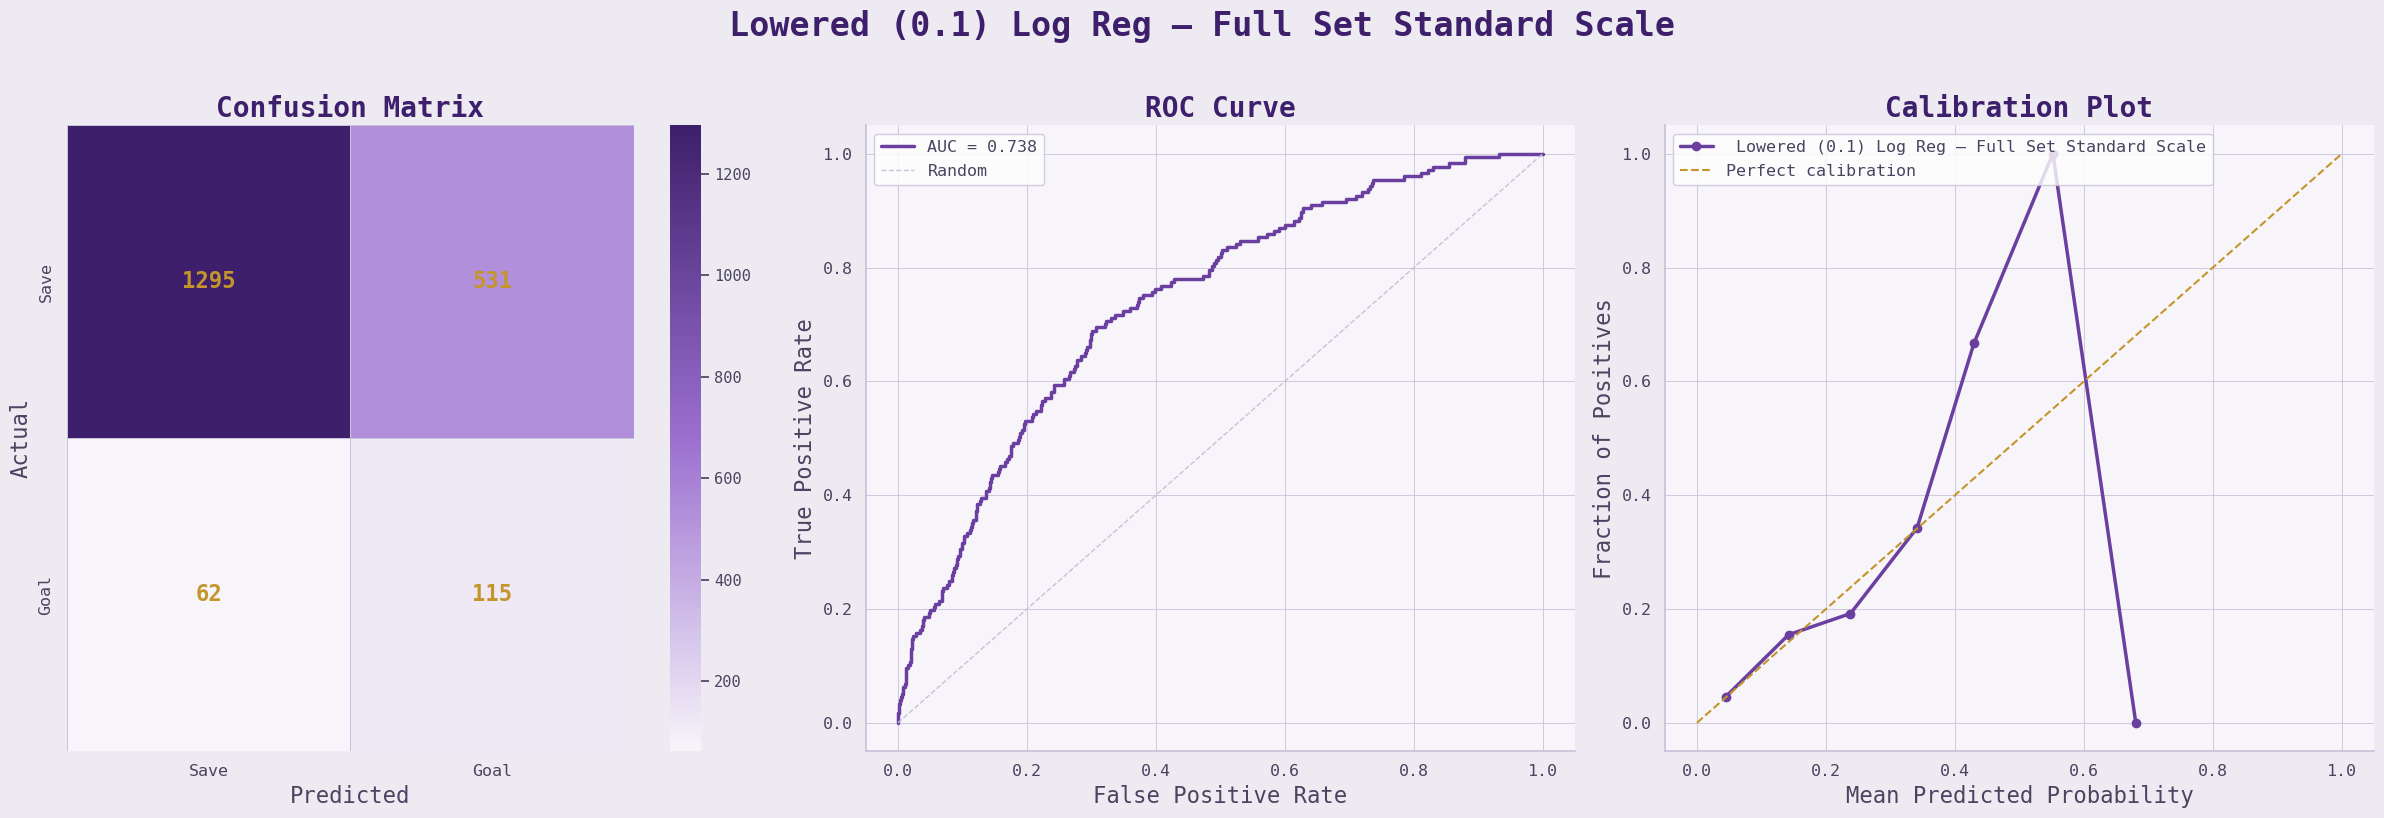

In [37]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train, y_train)
model_eval(pipeline,
           X_test,
           y_test,
           model_name=" Lowered (0.1) Log Reg — Full Set Standard Scale",
           threshold = 0.1)

This one has ticked over and is now over guessing goals and the accuracy is lowering.  I'll try again with the selected features.


   Lowered (0.25) Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       90.26%
  AUC:                            0.737
  Log Loss:                       0.269
  Avg Precision (PR-AUC):         0.229

              precision    recall  f1-score   support

        Save       0.92      0.98      0.95      1826
        Goal       0.36      0.13      0.19       177

    accuracy                           0.90      2003
   macro avg       0.64      0.55      0.57      2003
weighted avg       0.87      0.90      0.88      2003



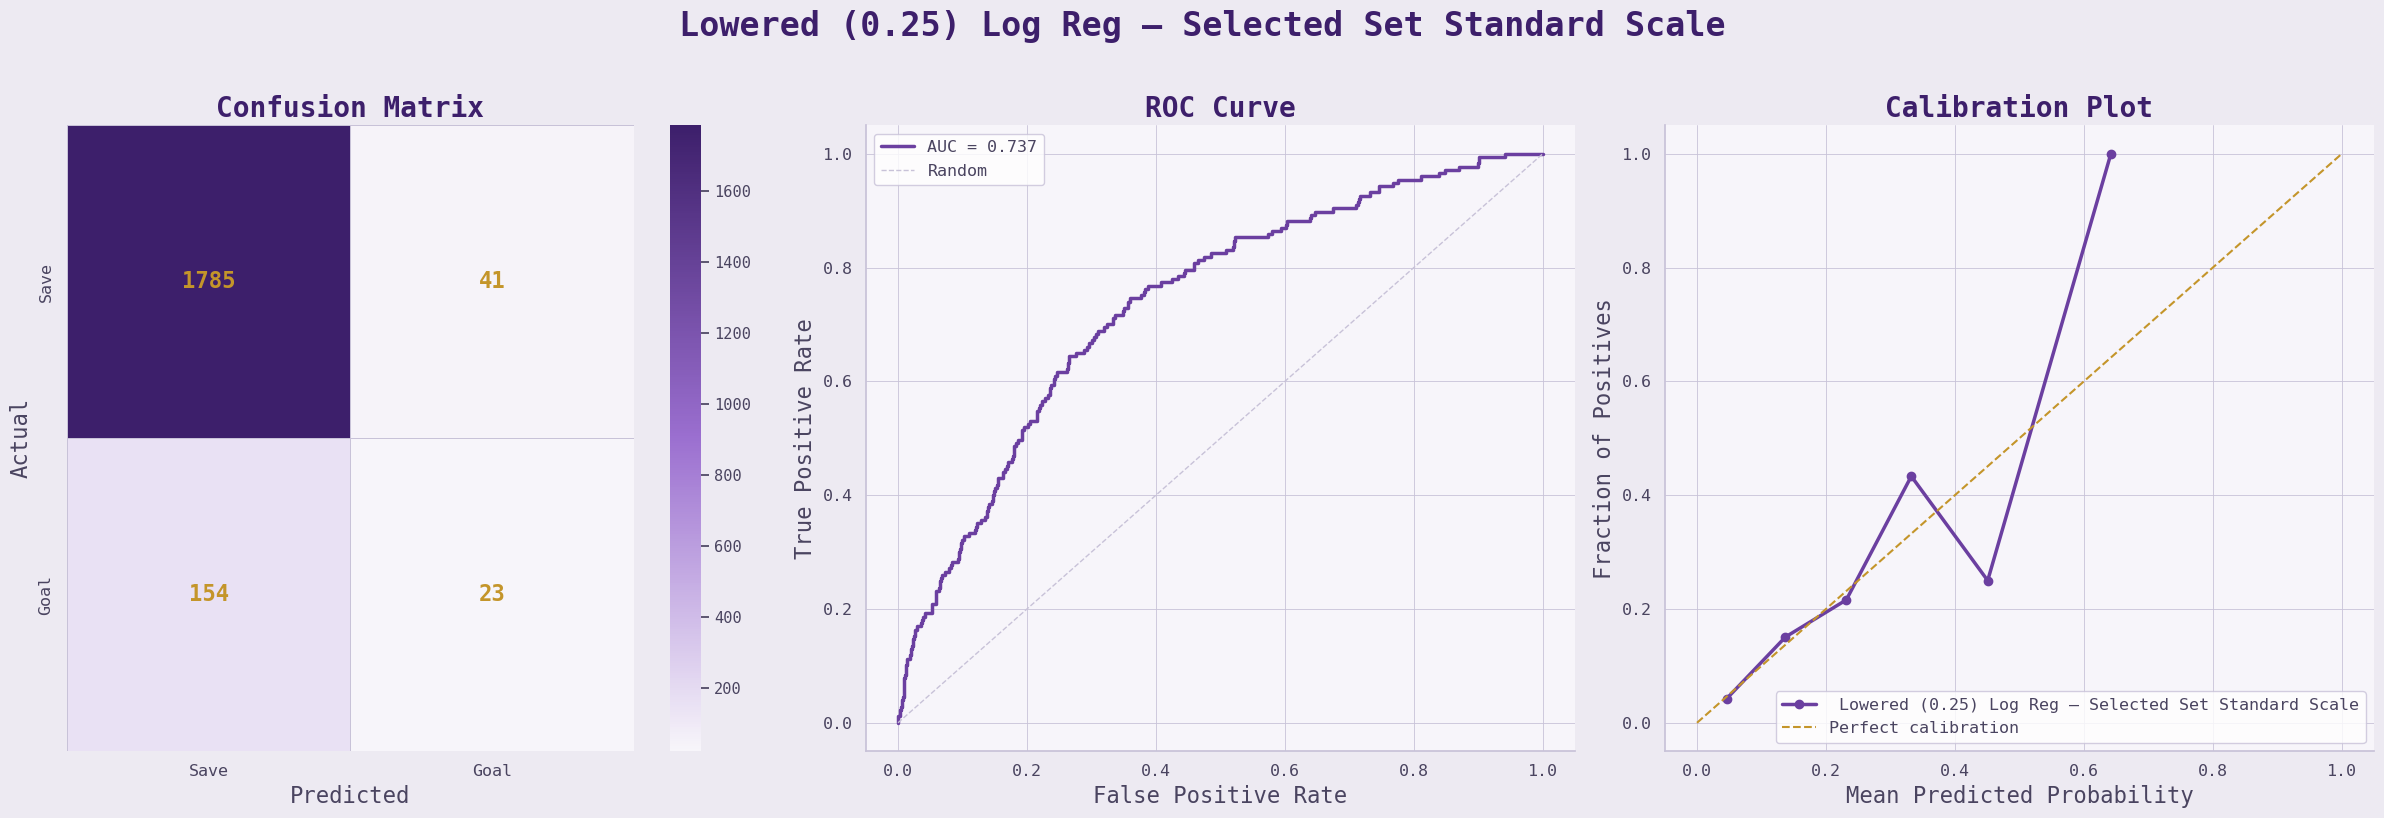

In [38]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name=" Lowered (0.25) Log Reg — Selected Set Standard Scale",
           threshold = 0.25)


   Lowered (0.1) Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       69.1%
  AUC:                            0.737
  Log Loss:                       0.269
  Avg Precision (PR-AUC):         0.229

              precision    recall  f1-score   support

        Save       0.96      0.69      0.80      1826
        Goal       0.18      0.68      0.28       177

    accuracy                           0.69      2003
   macro avg       0.57      0.69      0.54      2003
weighted avg       0.89      0.69      0.76      2003



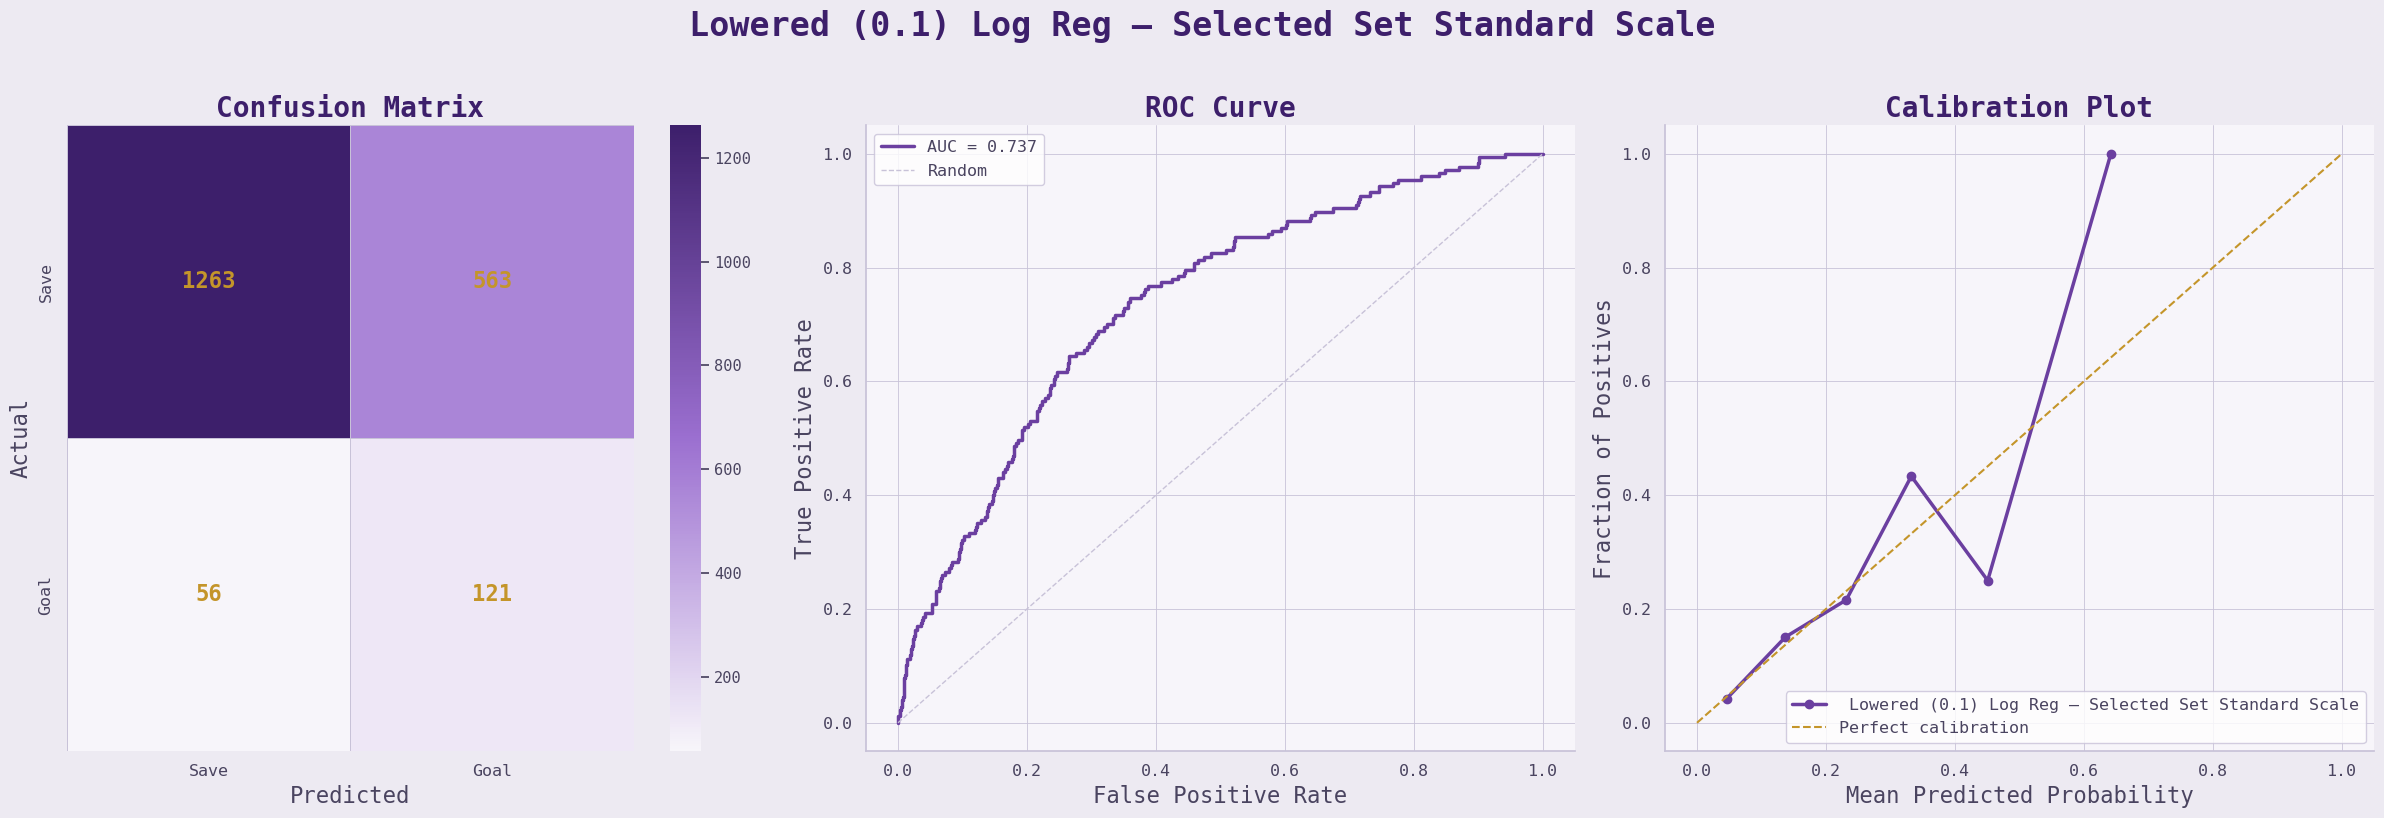

In [39]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name=" Lowered (0.1) Log Reg — Selected Set Standard Scale",
           threshold = 0.1)


   Lowered (0.25) Log Reg — Selected Set MinMax Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       90.26%
  AUC:                            0.738
  Log Loss:                       0.269
  Avg Precision (PR-AUC):         0.23

              precision    recall  f1-score   support

        Save       0.92      0.98      0.95      1826
        Goal       0.35      0.12      0.18       177

    accuracy                           0.90      2003
   macro avg       0.64      0.55      0.57      2003
weighted avg       0.87      0.90      0.88      2003



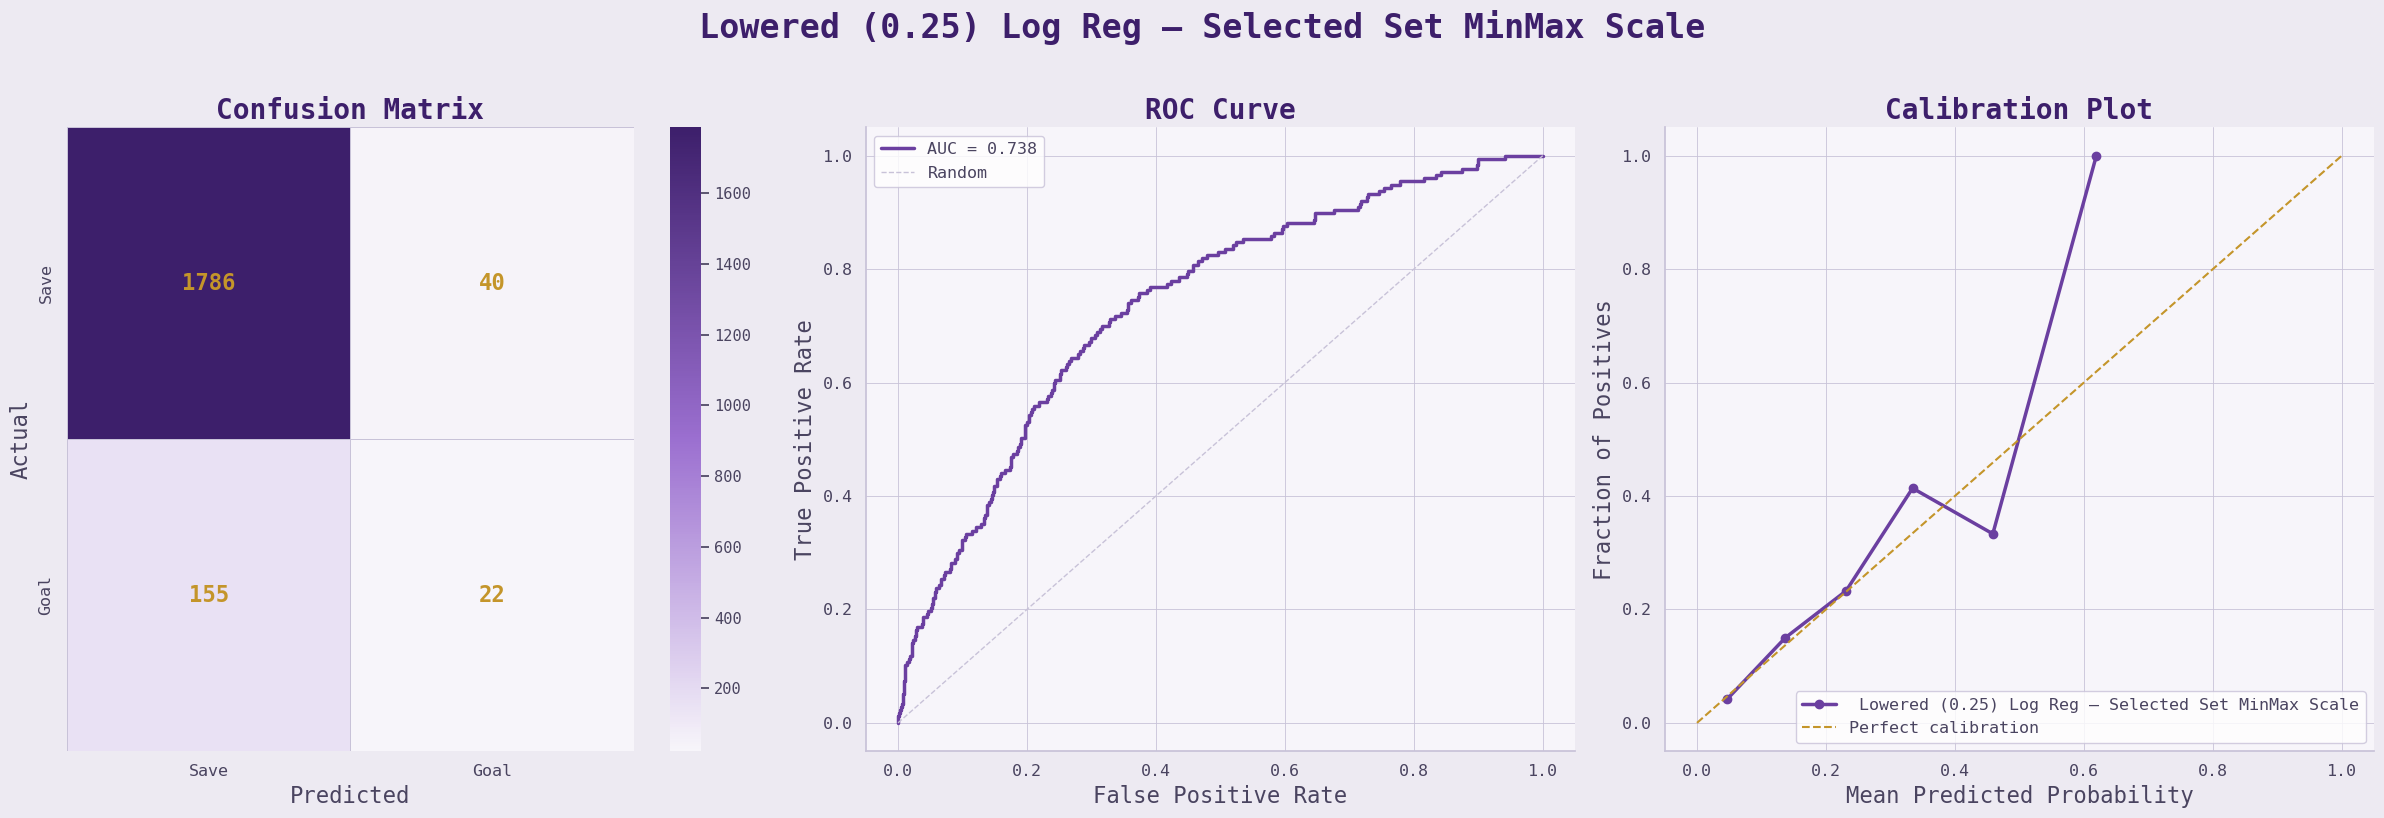

In [40]:
preprocessor = ColumnTransformer([
    ('scale', MinMaxScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name=" Lowered (0.25) Log Reg — Selected Set MinMax Scale",
           threshold = 0.25)


   Lowered (0.1) Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       69.1%
  AUC:                            0.737
  Log Loss:                       0.269
  Avg Precision (PR-AUC):         0.229

              precision    recall  f1-score   support

        Save       0.96      0.69      0.80      1826
        Goal       0.18      0.68      0.28       177

    accuracy                           0.69      2003
   macro avg       0.57      0.69      0.54      2003
weighted avg       0.89      0.69      0.76      2003



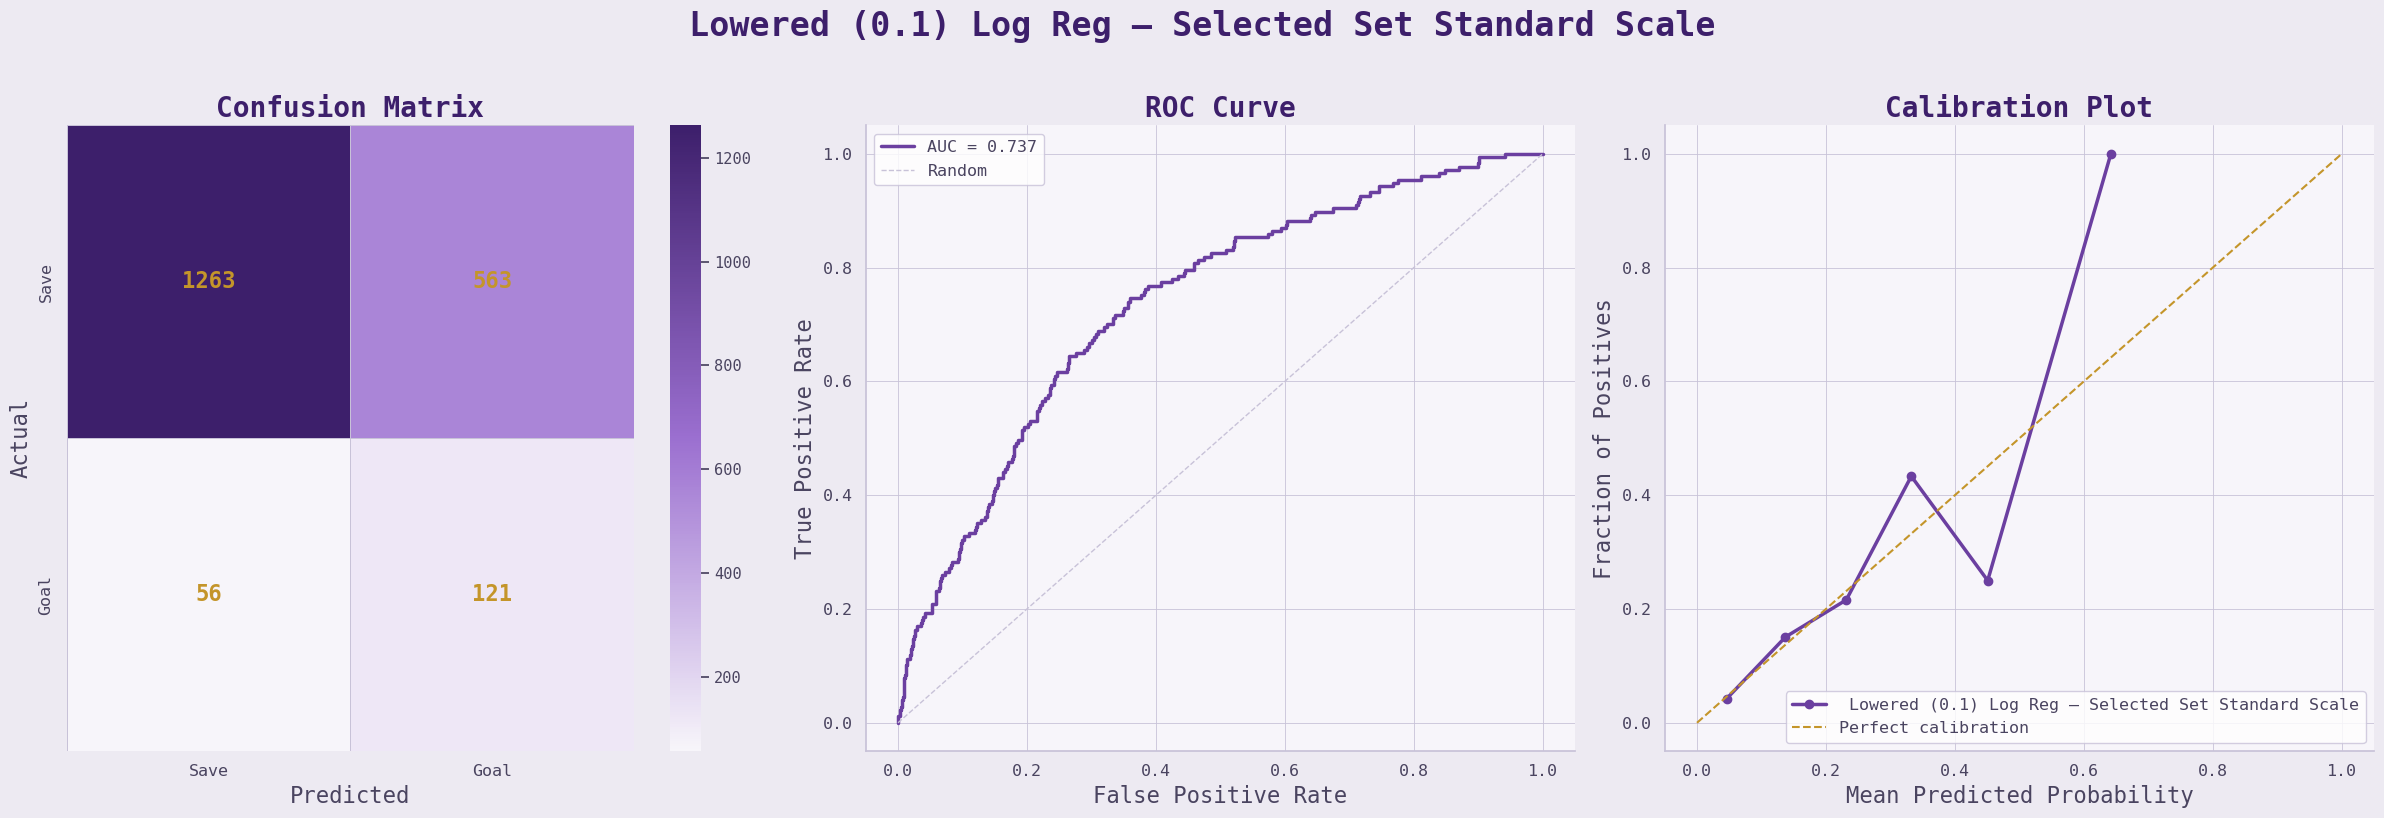

In [41]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name=" Lowered (0.1) Log Reg — Selected Set Standard Scale",
           threshold = 0.1, )

There does seem to be some success in lowering the threshold in making predictions for goals.  In particular, we are seeing a marked improvement on the precision of the Goal predictions (up to 0.35) which is the highest mark so far for models that have made more than a handful of Goal predictions.

Up to this point:
- Scaling has a good impact, but difference between standard and minmax scaling so we'll stick to Standard
- Balancing the data had an overall negative impact on the models
- Lowering the threshold succeeded at making more goal predictions, increased Goal precision with a smal decrease in accuracy
- The selected features are now performing as well as, and sometimes outperforming, the full feature set.

I will try to tune the C-value hyperparameter in order to see if that will have an effect on the model.  Given what I've seen so far, I will focus on Standard Scaled data but will try different thresholds for predictions along with using the full and the selected datasets.

In [42]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

In [43]:
param_grid = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 5000]}
grid = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)

{'model__C': 10} 0.7453764323094652


In [44]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(C = 10))
])


  Log Reg C 10 — Full Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       91.16%
  AUC:                            0.74
  Log Loss:                       0.268
  Avg Precision (PR-AUC):         0.23

              precision    recall  f1-score   support

        Save       0.91      1.00      0.95      1826
        Goal       0.50      0.01      0.01       177

    accuracy                           0.91      2003
   macro avg       0.71      0.50      0.48      2003
weighted avg       0.88      0.91      0.87      2003



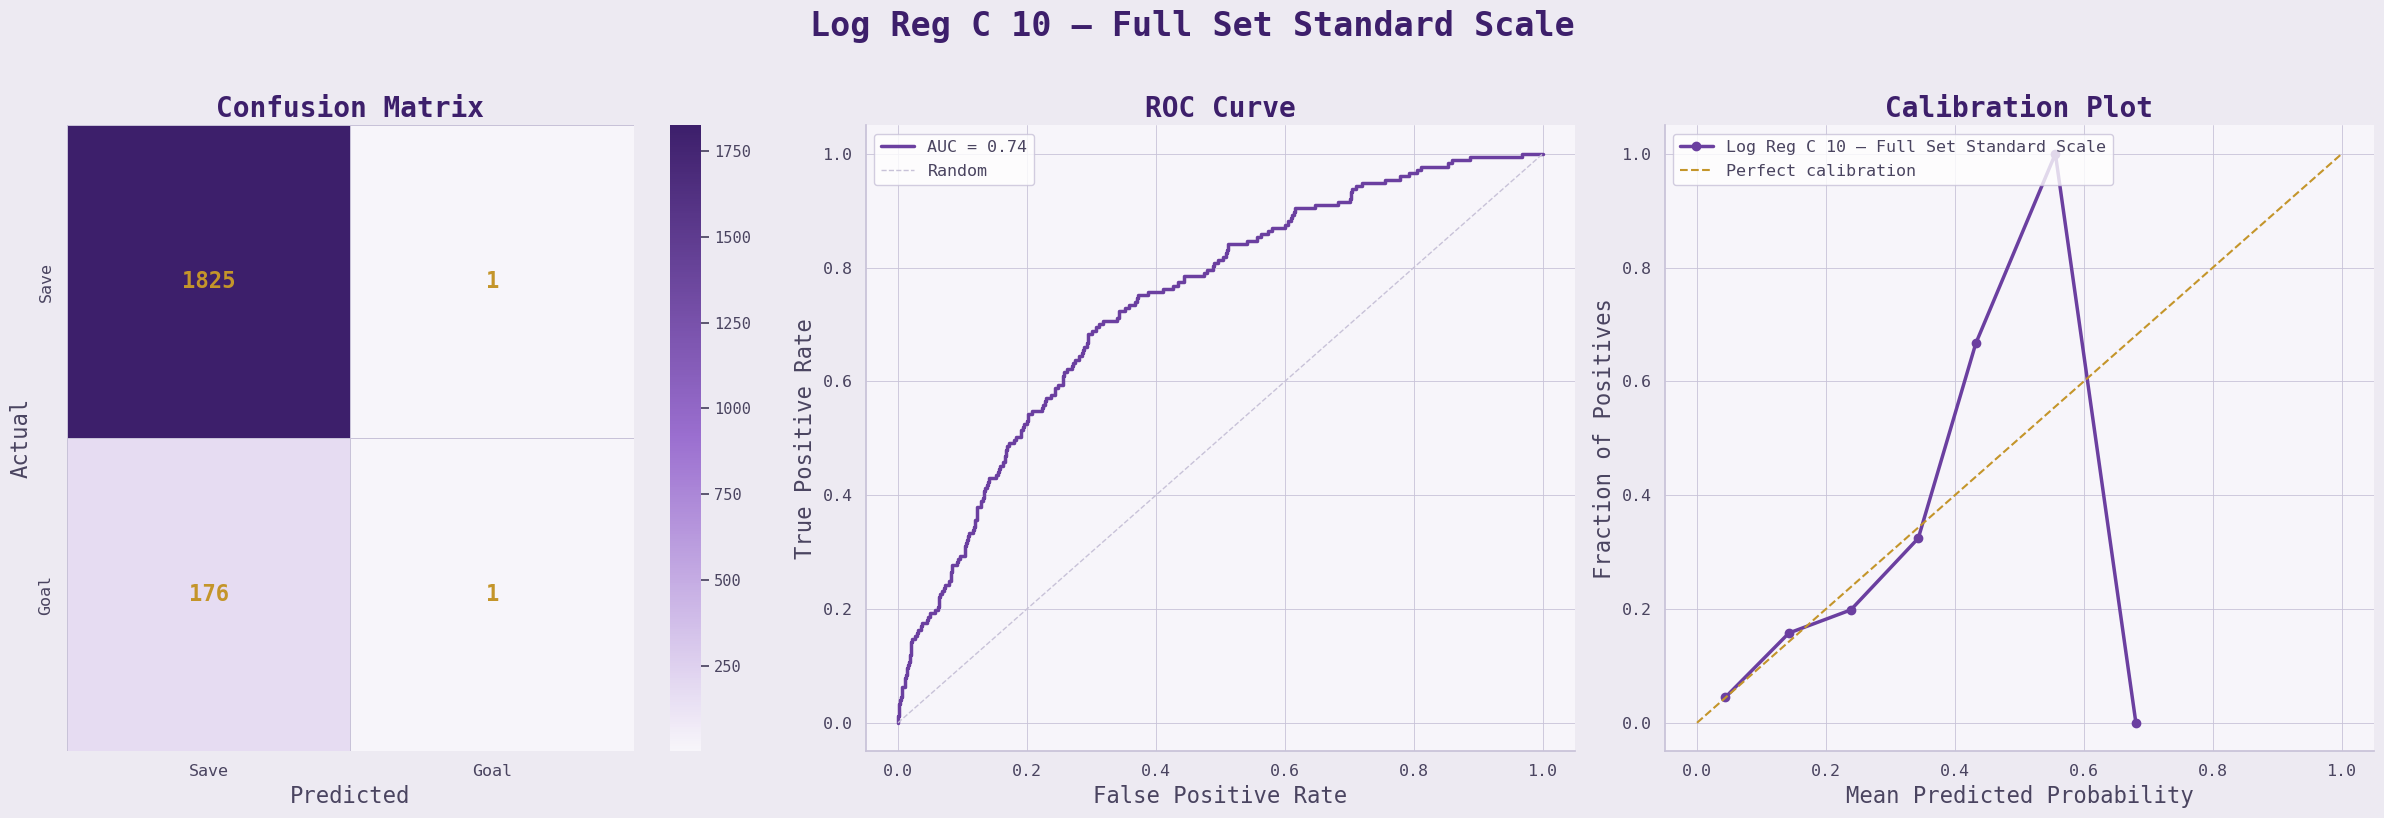

In [45]:
pipeline.fit(X_train, y_train)
model_eval(pipeline,
           X_test,
           y_test,
           model_name="Log Reg C 10 — Full Set Standard Scale")


  Lowered (0.25) Log Reg C 10 — Full Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       89.47%
  AUC:                            0.74
  Log Loss:                       0.268
  Avg Precision (PR-AUC):         0.23

              precision    recall  f1-score   support

        Save       0.92      0.97      0.94      1826
        Goal       0.32      0.16      0.22       177

    accuracy                           0.89      2003
   macro avg       0.62      0.56      0.58      2003
weighted avg       0.87      0.89      0.88      2003



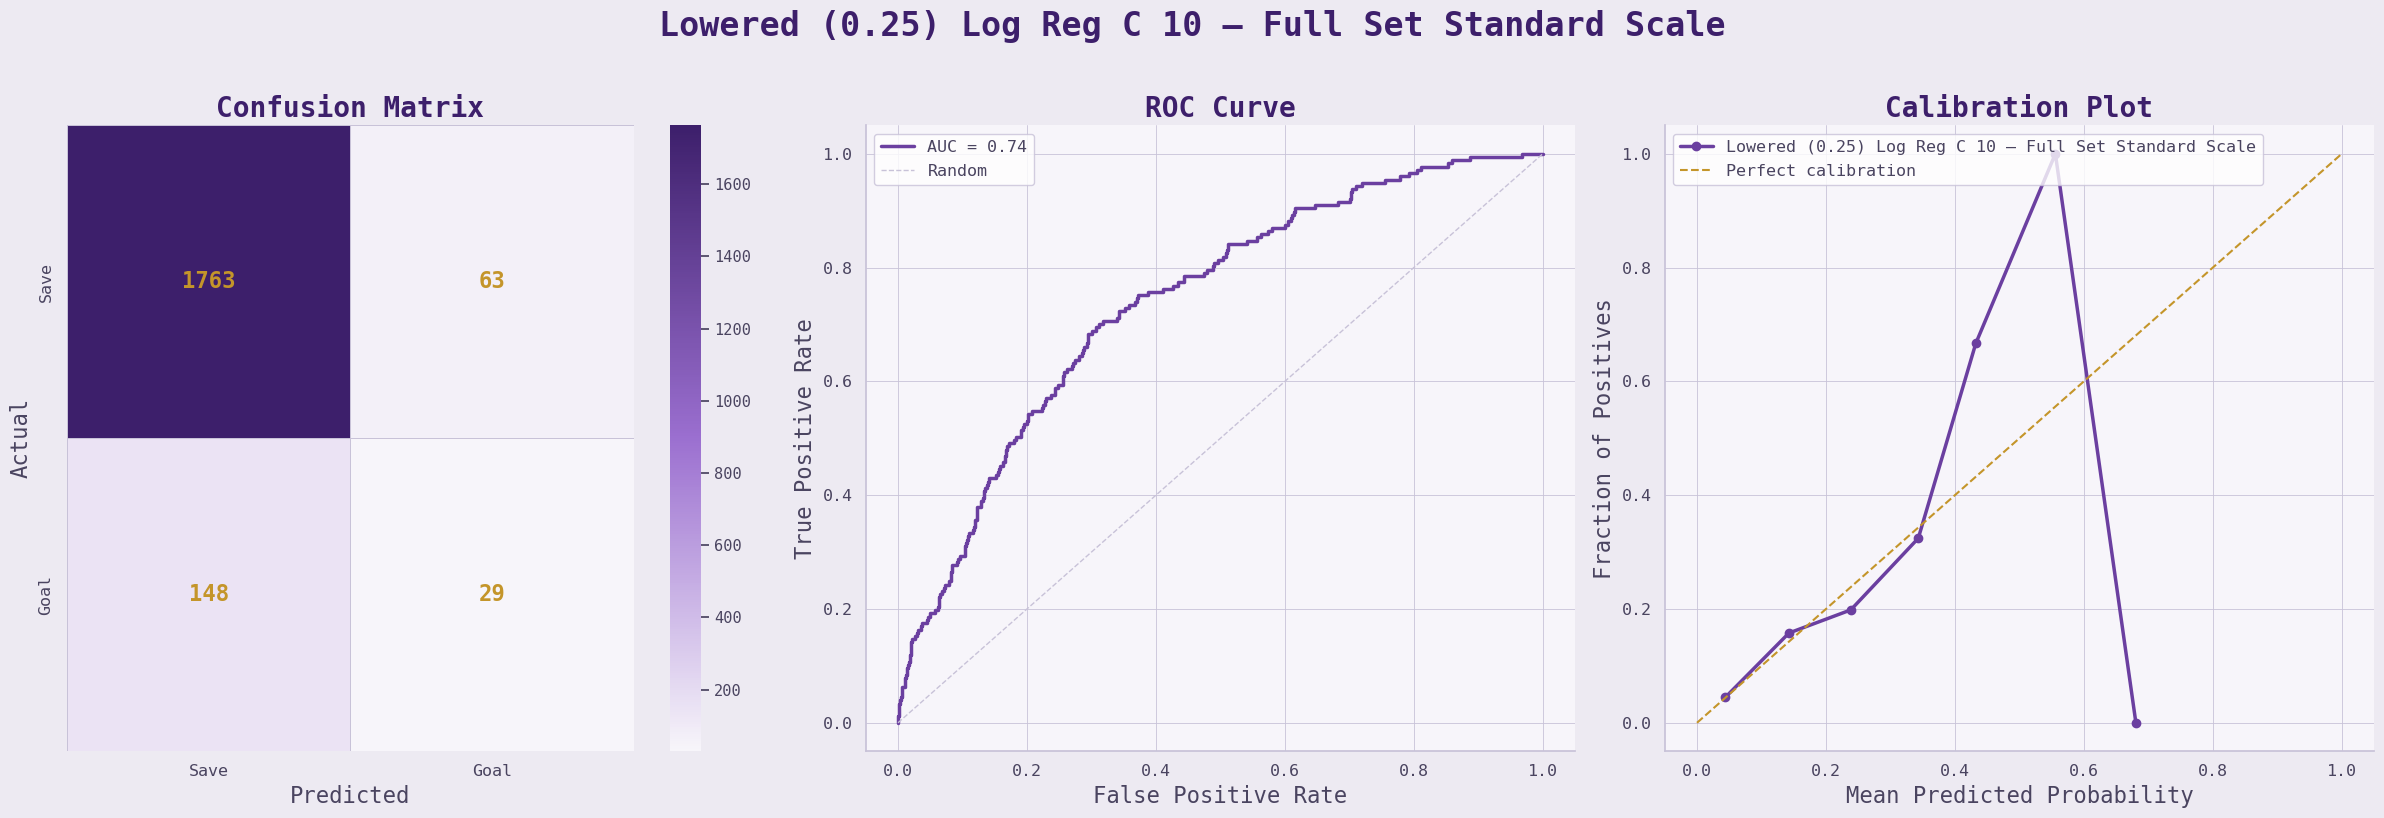

In [46]:
pipeline.fit(X_train, y_train)
model_eval(pipeline,
           X_test,
           y_test,
           model_name="Lowered (0.25) Log Reg C 10 — Full Set Standard Scale",
           threshold = 0.25)

In [47]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

In [48]:
param_grid = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 5000]}
grid = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)
grid.fit(X_train[selected_cols], y_train)
print(grid.best_params_, grid.best_score_)

{'model__C': 0.1} 0.7307003187701464


In [49]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(C = 0.1))
])


  Log Reg C 0.1 — Selected Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       91.21%
  AUC:                            0.736
  Log Loss:                       0.269
  Avg Precision (PR-AUC):         0.226

              precision    recall  f1-score   support

        Save       0.91      1.00      0.95      1826
        Goal       1.00      0.01      0.01       177

    accuracy                           0.91      2003
   macro avg       0.96      0.50      0.48      2003
weighted avg       0.92      0.91      0.87      2003



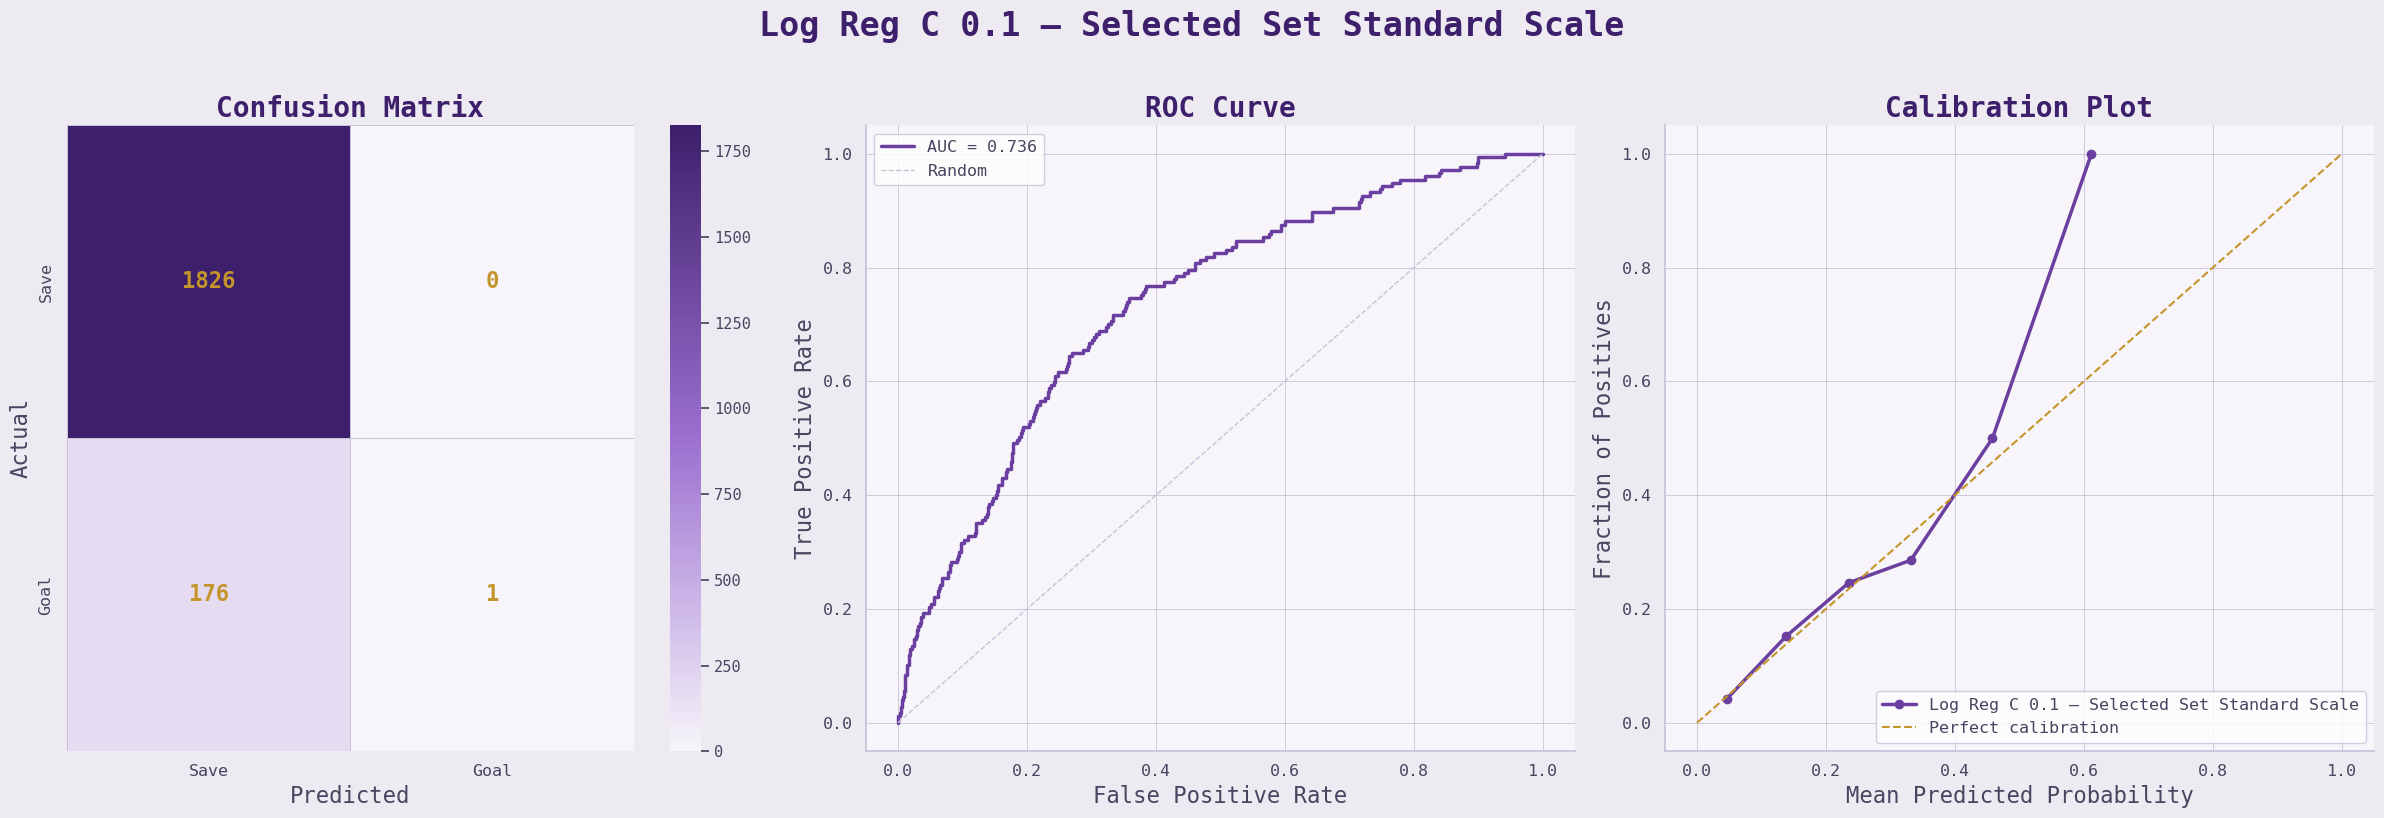

In [50]:
pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name="Log Reg C 0.1 — Selected Set Standard Scale")


  Lowered (0.25) Log Reg C 0.1 — Selected Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       90.56%
  AUC:                            0.736
  Log Loss:                       0.269
  Avg Precision (PR-AUC):         0.226

              precision    recall  f1-score   support

        Save       0.92      0.98      0.95      1826
        Goal       0.39      0.12      0.19       177

    accuracy                           0.91      2003
   macro avg       0.66      0.55      0.57      2003
weighted avg       0.87      0.91      0.88      2003



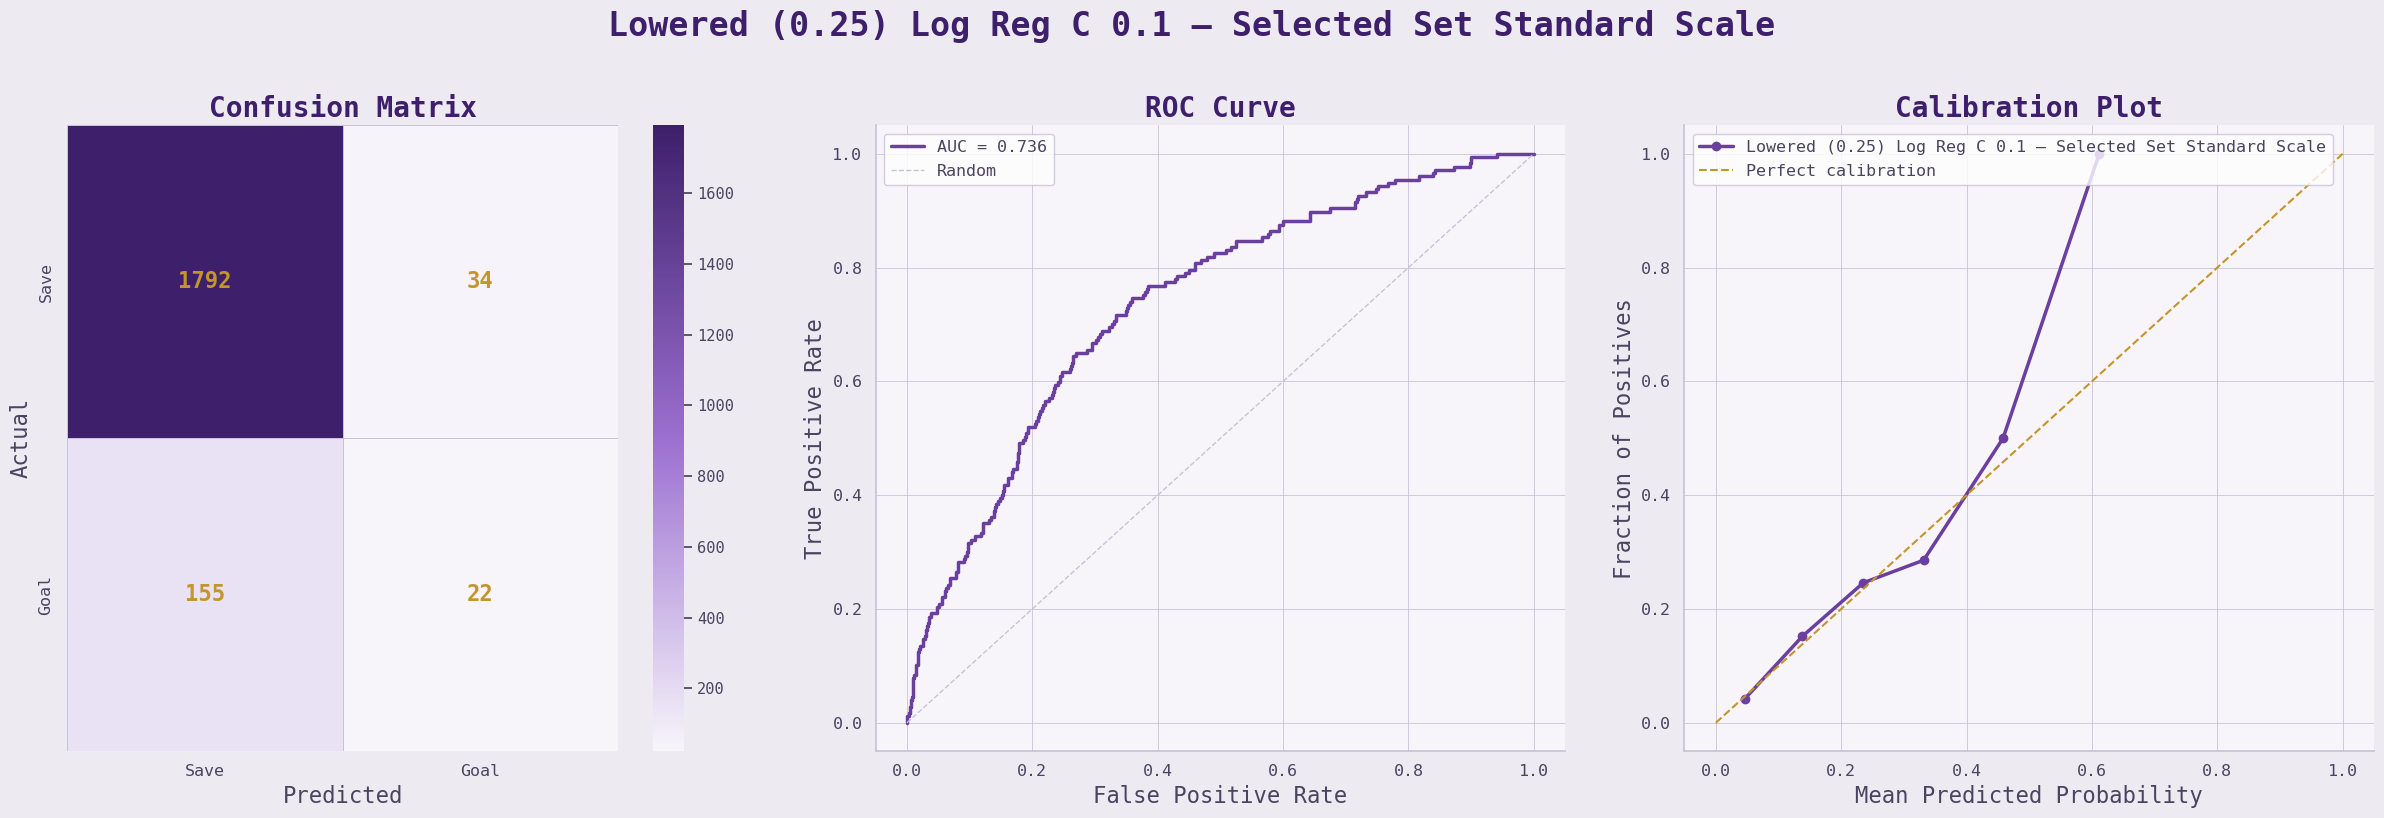

In [51]:
pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name="Lowered (0.25) Log Reg C 0.1 — Selected Set Standard Scale",
           threshold = 0.25)

The range of AUC on these models is narrower, so they are performing similarly.  However, the Lowered (0.25) Log Reg C 0.1 — Selected Set Standard Scale model, while performing in the middle in regards to AUC and Accuracy, showed the best Precision in predicting goals.  There were still just over 50 goal predictions, but the precision did improve with the lower threshold. It's worth changing the thresholds again to see if we get any similar improvement


  Lowered (0.15) Log Reg C 0.1 — Selected Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       81.48%
  AUC:                            0.736
  Log Loss:                       0.269
  Avg Precision (PR-AUC):         0.226

              precision    recall  f1-score   support

        Save       0.93      0.86      0.89      1826
        Goal       0.21      0.38      0.27       177

    accuracy                           0.81      2003
   macro avg       0.57      0.62      0.58      2003
weighted avg       0.87      0.81      0.84      2003



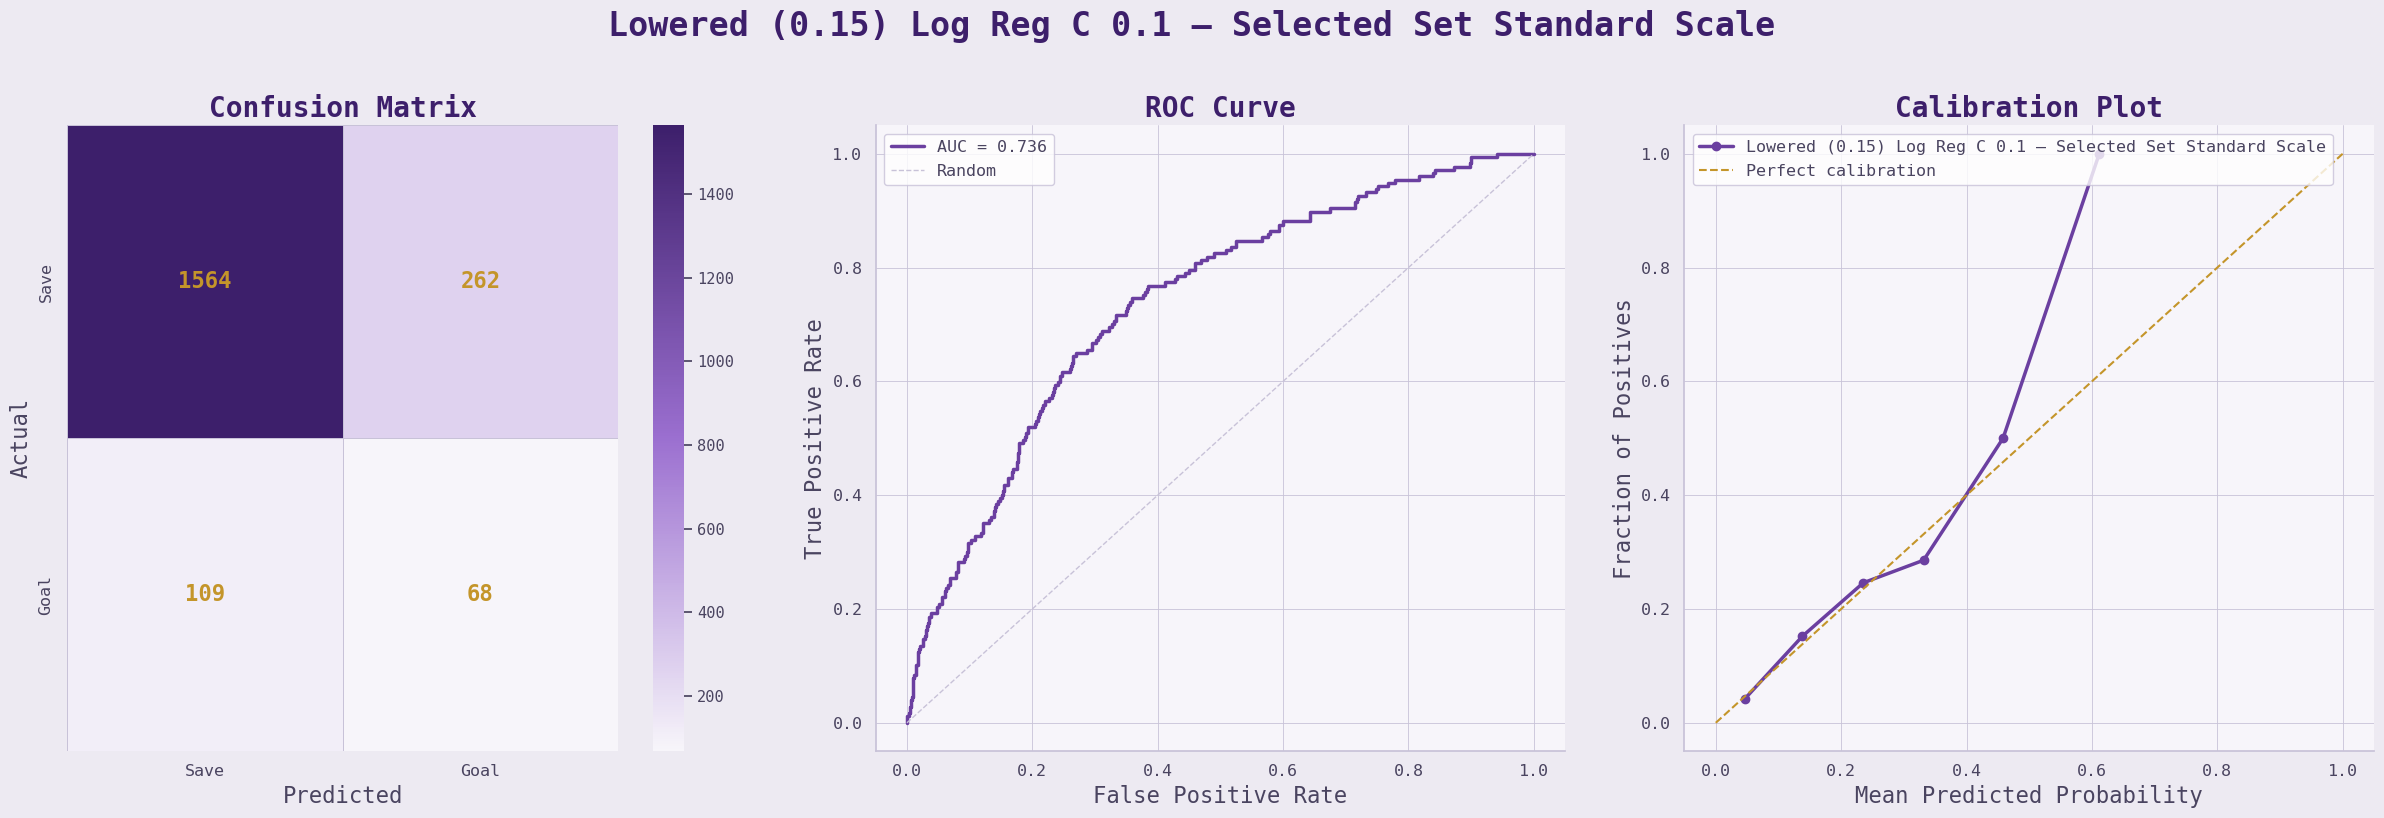

In [52]:
pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name="Lowered (0.15) Log Reg C 0.1 — Selected Set Standard Scale",
           threshold = 0.15)

Unfortunately no, it looks like lowering to a threshold 0.25 was the best version of this model.

There could be a promising middle ground between balancing the data, tuning the C-value and lowering the threshold.  It is likely this will decrease the accuracy of the predictions, but the the number of goal predictions could be a bit higher with a similar precision, it could yield the most helpful model.

In [53]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(class_weight = 'balanced', random_state=29))
])

In [54]:
param_grid = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 5000]}
grid = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)

{'model__C': 1000} 0.7455849430768252



  Balanced Log Reg C 1000 — Full Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       67.1%
  AUC:                            0.737
  Log Loss:                       0.588
  Avg Precision (PR-AUC):         0.224

              precision    recall  f1-score   support

        Save       0.96      0.67      0.79      1826
        Goal       0.17      0.70      0.27       177

    accuracy                           0.67      2003
   macro avg       0.56      0.68      0.53      2003
weighted avg       0.89      0.67      0.74      2003



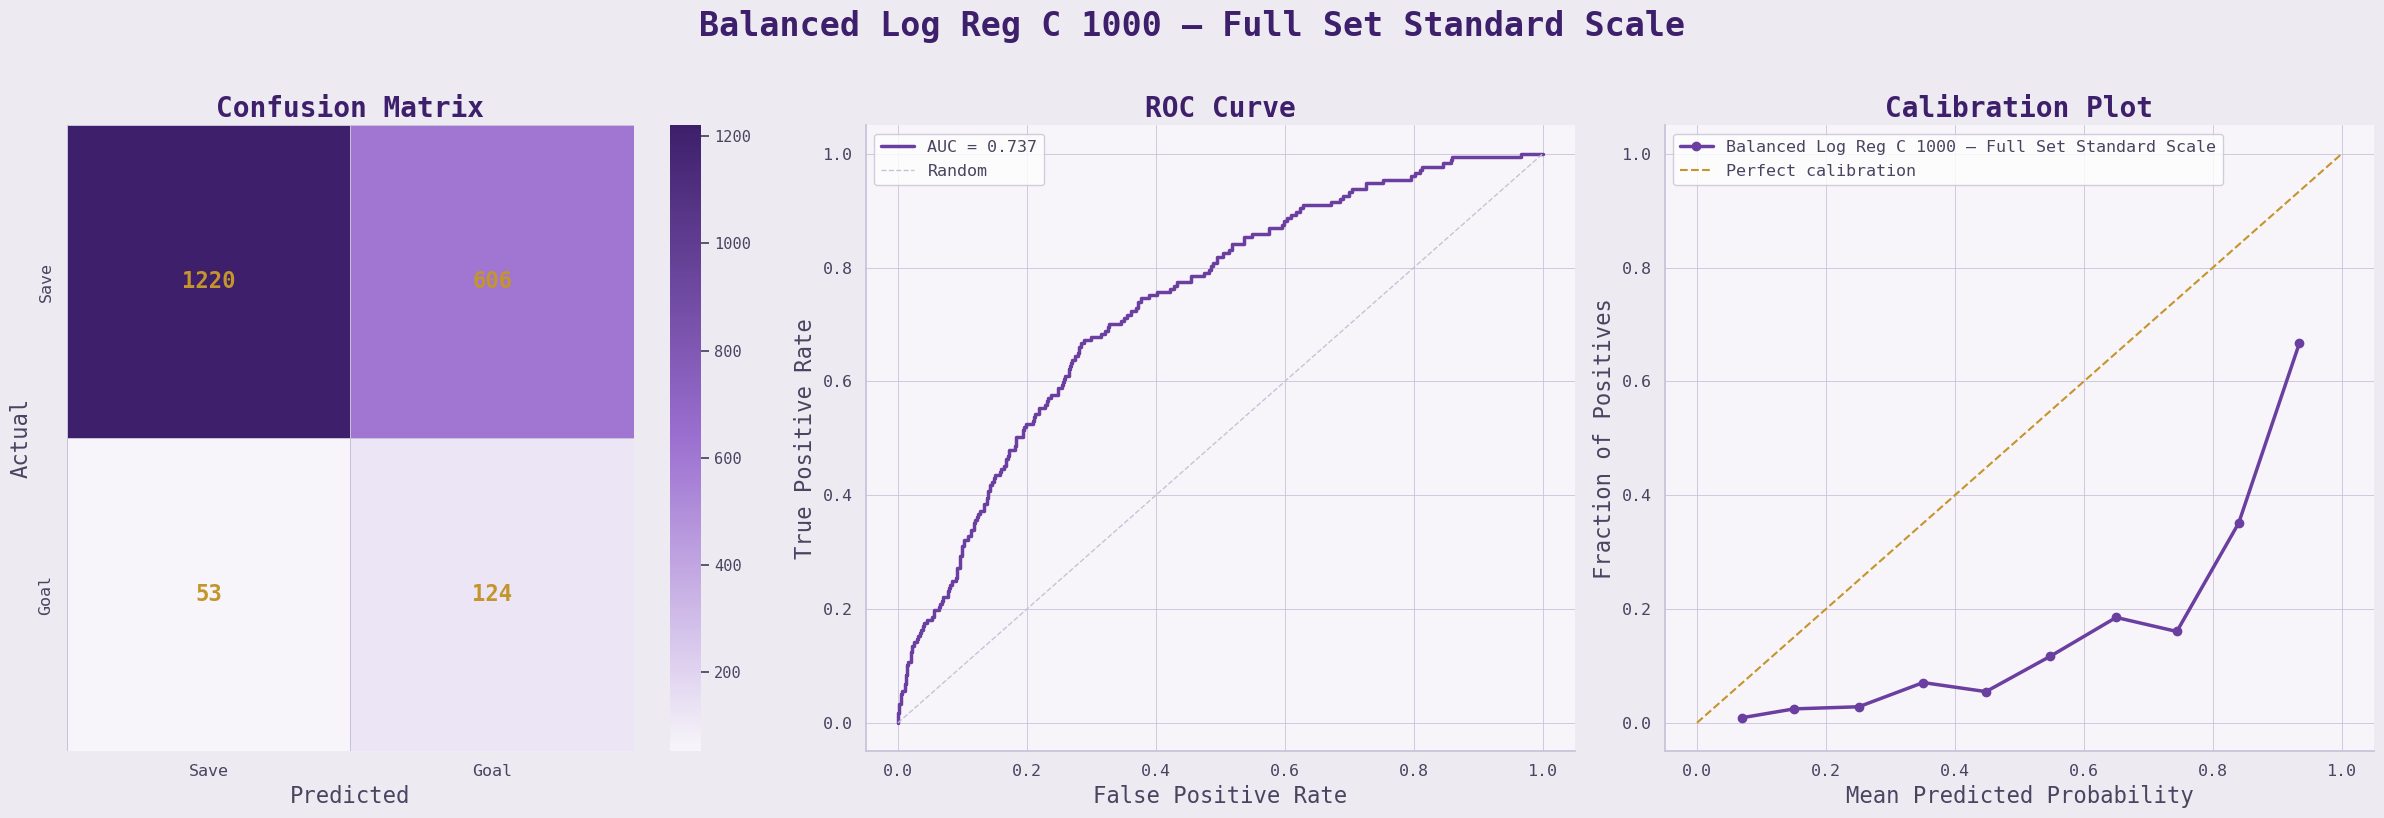

In [55]:
pipeline.fit(X_train, y_train)
model_eval(pipeline,
           X_test,
           y_test,
           model_name="Balanced Log Reg C 1000 — Full Set Standard Scale")


  Lowered (0.25) Balanced Log Reg C 1000 — Full Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       34.75%
  AUC:                            0.737
  Log Loss:                       0.588
  Avg Precision (PR-AUC):         0.224

              precision    recall  f1-score   support

        Save       0.98      0.29      0.45      1826
        Goal       0.11      0.94      0.20       177

    accuracy                           0.35      2003
   macro avg       0.55      0.61      0.33      2003
weighted avg       0.90      0.35      0.43      2003



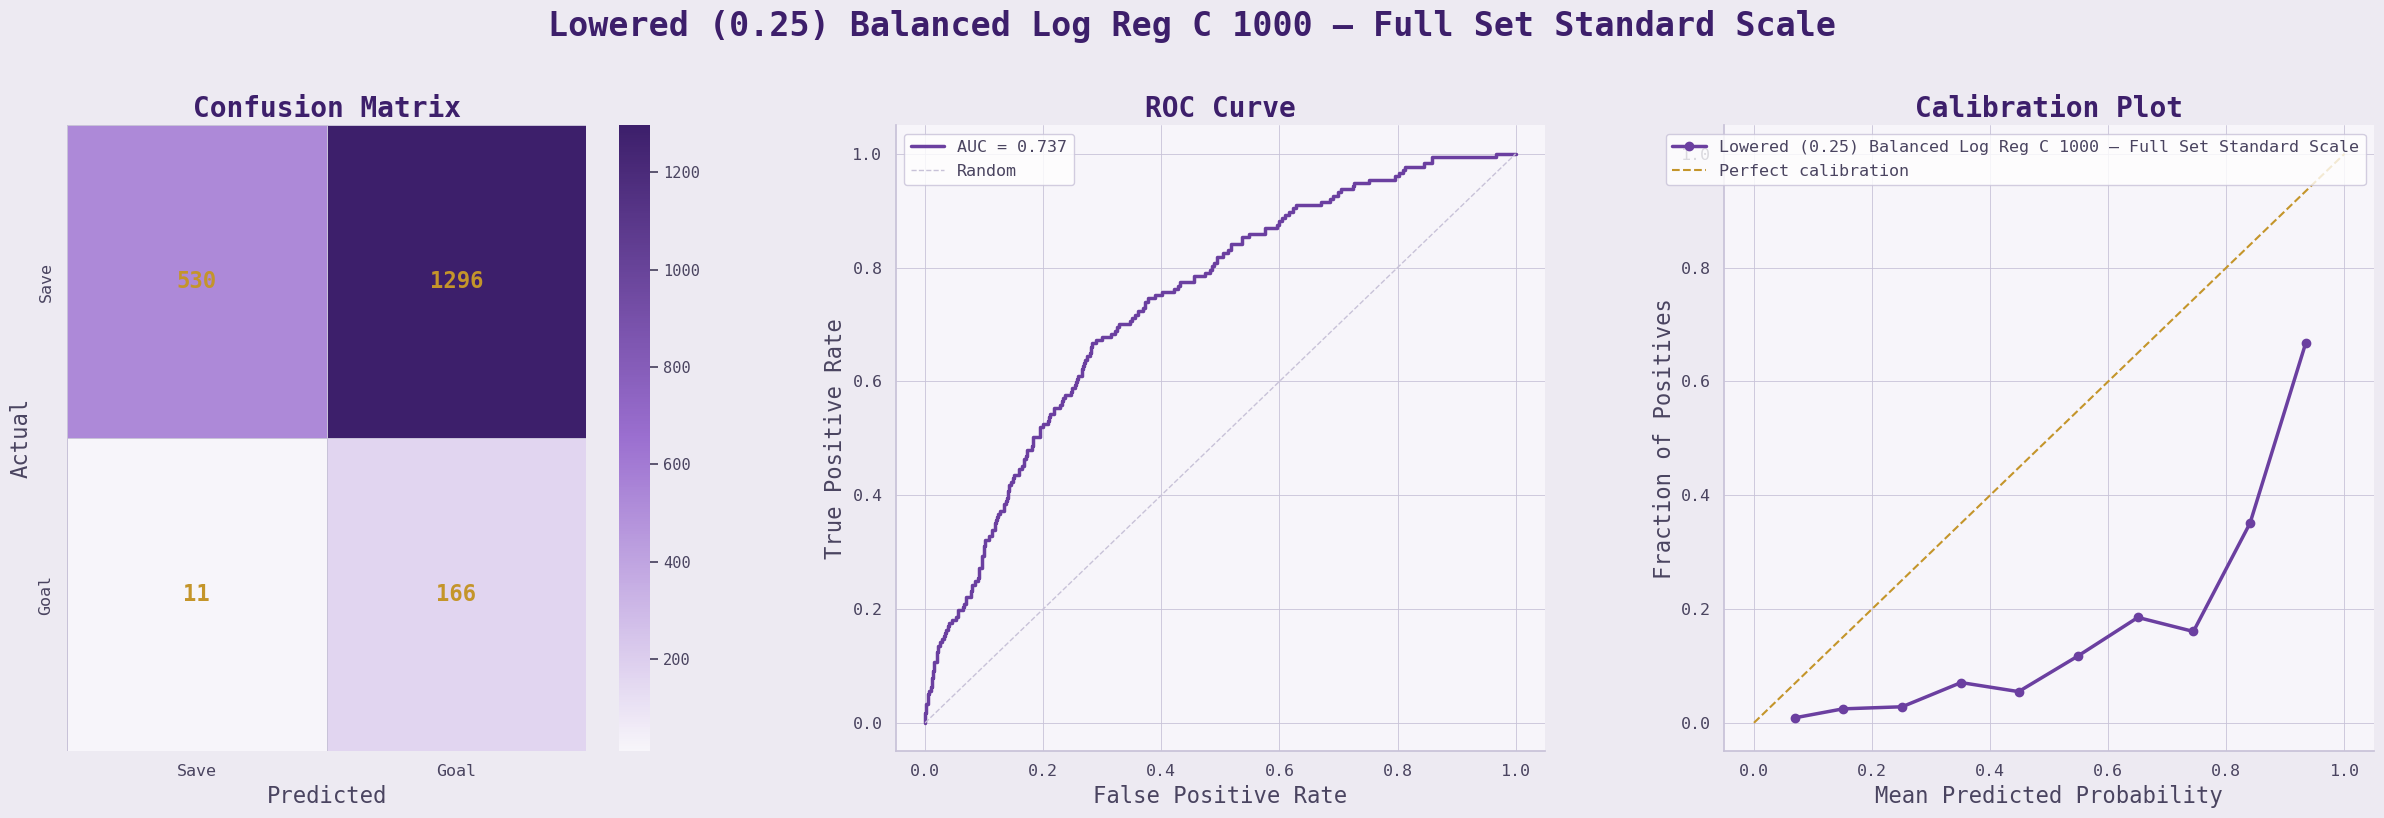

In [56]:
pipeline.fit(X_train, y_train)
model_eval(pipeline,
           X_test,
           y_test,
           model_name="Lowered (0.25) Balanced Log Reg C 1000 — Full Set Standard Scale",
           threshold = 0.25)

In [57]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(class_weight = 'balanced', random_state=29))
])

In [58]:
param_grid = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 5000]}
grid = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)
grid.fit(X_train[selected_cols], y_train)
print(grid.best_params_, grid.best_score_)

{'model__C': 0.1} 0.7301220462831568



  Balanced Log Reg C 0.1 — Selected Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       65.6%
  AUC:                            0.738
  Log Loss:                       0.598
  Avg Precision (PR-AUC):         0.228

              precision    recall  f1-score   support

        Save       0.96      0.65      0.77      1826
        Goal       0.17      0.73      0.27       177

    accuracy                           0.66      2003
   macro avg       0.56      0.69      0.52      2003
weighted avg       0.89      0.66      0.73      2003



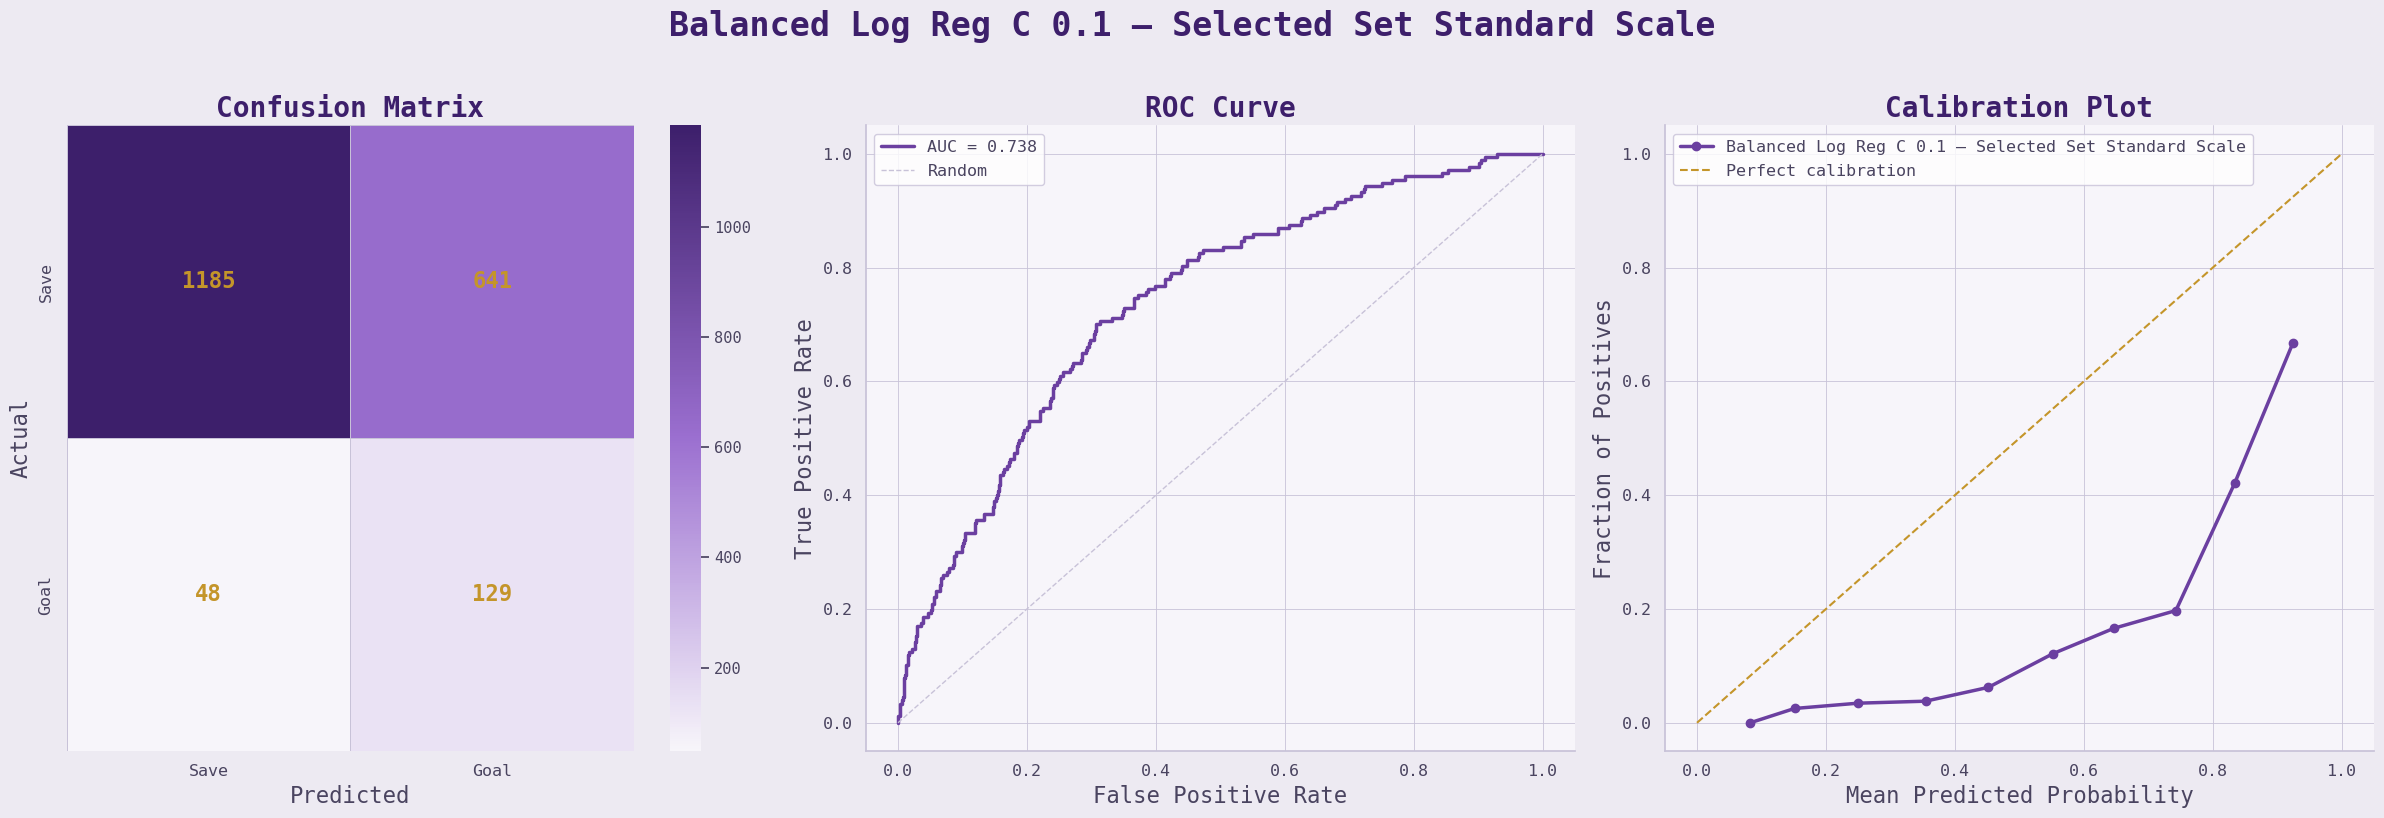

In [59]:
pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name="Balanced Log Reg C 0.1 — Selected Set Standard Scale")


  Lowered (0.25) Balanced Log Reg C 0.1 — Selected Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       31.05%
  AUC:                            0.738
  Log Loss:                       0.598
  Avg Precision (PR-AUC):         0.228

              precision    recall  f1-score   support

        Save       0.98      0.25      0.40      1826
        Goal       0.11      0.94      0.19       177

    accuracy                           0.31      2003
   macro avg       0.54      0.60      0.30      2003
weighted avg       0.90      0.31      0.38      2003



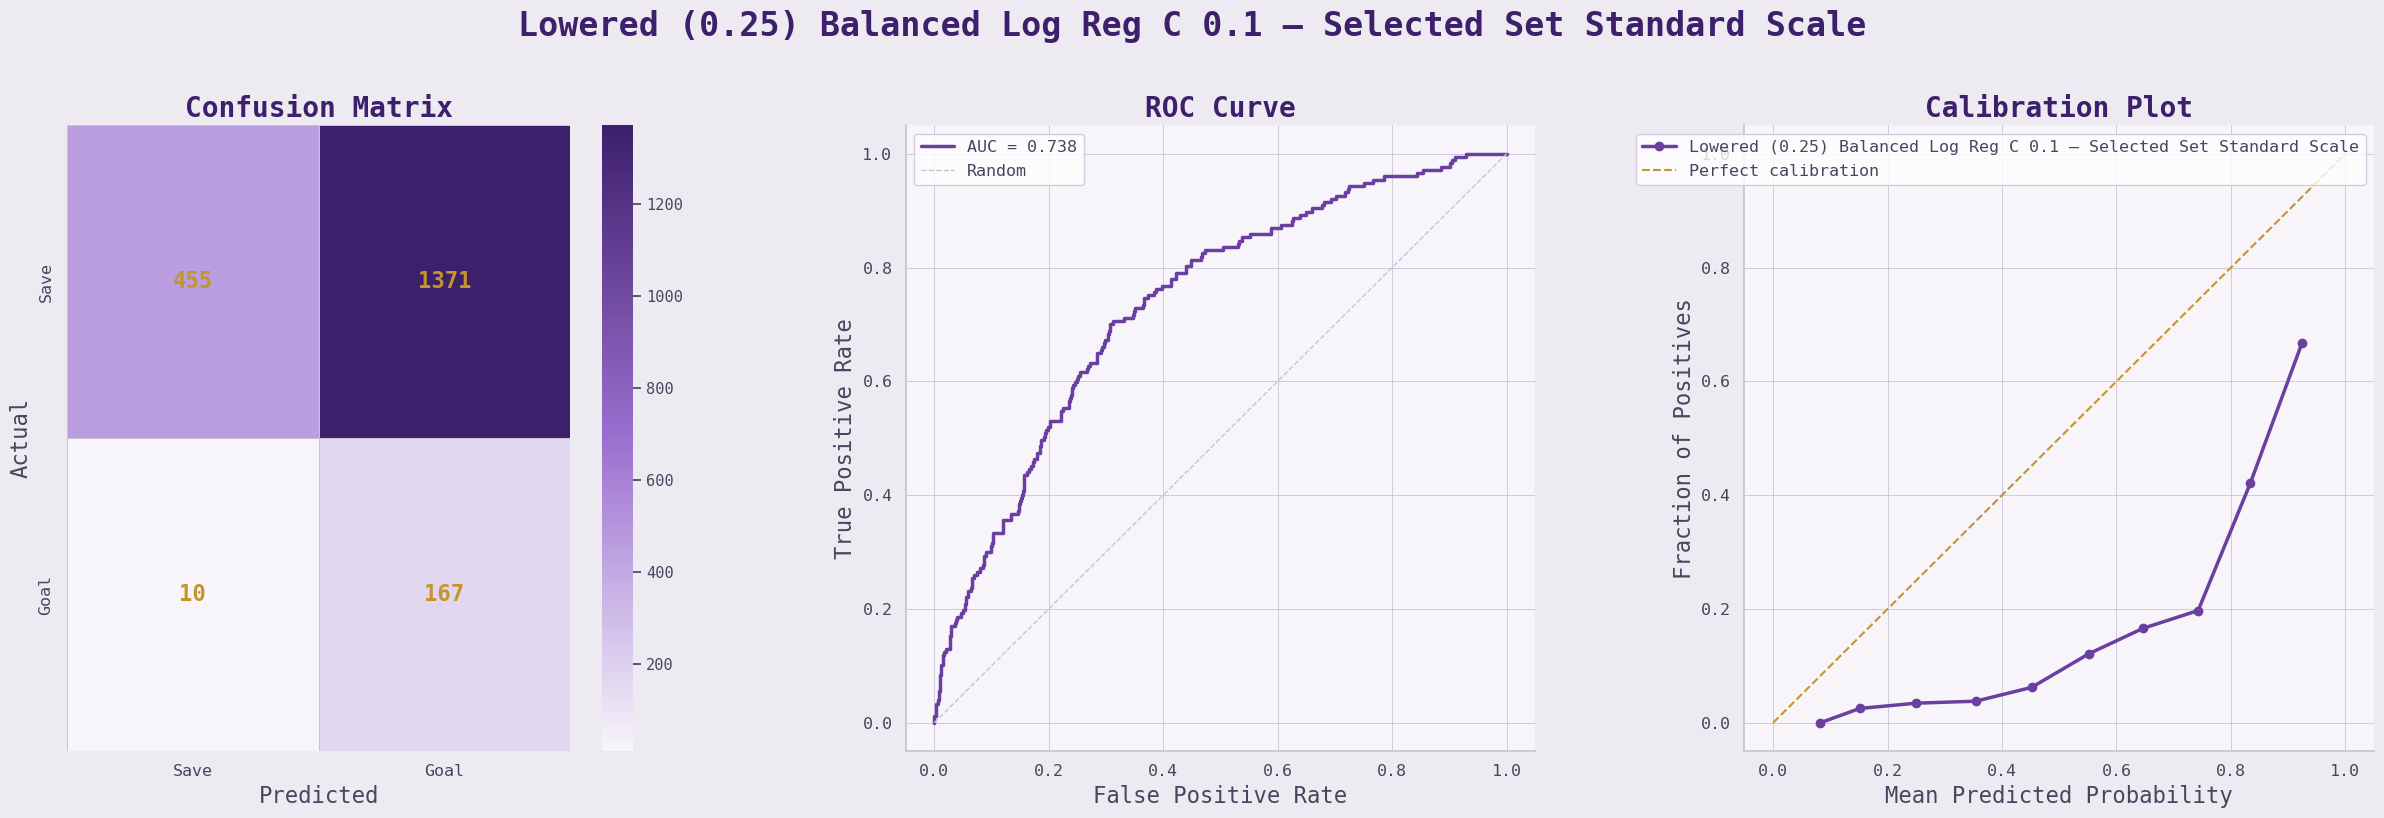

In [60]:
pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name="Lowered (0.25) Balanced Log Reg C 0.1 — Selected Set Standard Scale",
           threshold = 0.25)

The recall for goal predictions did improve, especially in the models with just the Selected features.  

In [61]:
pd.DataFrame(eval_list).sort_values(['auc','accuracy'], ascending = [False, False])

model  accuracy     auc  \
20             Log Reg C 10 — Full Set Standard Scale    0.9116  0.7398   
21  Lowered (0.25) Log Reg C 10 — Full Set Standar...    0.8947  0.7398   
2                   Log Reg — Full Set Standard Scale    0.9116  0.7384   
14   Lowered (0.25) Log Reg — Full Set Standard Scale    0.8972  0.7384   
15    Lowered (0.1) Log Reg — Full Set Standard Scale    0.7039  0.7384   
9        Balanced Log Reg — Selected Set MinMax Scale    0.6555  0.7380   
5                     Selected Log Reg - MinMax Scale    0.9121  0.7378   
18   Lowered (0.25) Log Reg — Selected Set MinMax ...    0.9026  0.7378   
8      Balanced Log Reg — Selected Set Standard Scale    0.6560  0.7377   
27  Balanced Log Reg C 0.1 — Selected Set Standard...    0.6560  0.7377   
28  Lowered (0.25) Balanced Log Reg C 0.1 — Select...    0.3105  0.7377   
6          Balanced Log Reg — Full Set Standard Scale    0.6710  0.7372   
25  Balanced Log Reg C 1000 — Full Set Standard Scale    0.6710  0.7372   
26  Lowered (0.25) Balanced Log Reg C 1000 — Full ...    0.3475  0.7372   
4                   Selected Log Reg - Standard Scale    0.9121  0.7371   
16   Lowered (0.25) Log Reg — Selected Set Standar...    0.9026  0.7371   
17   Lowered (0.1) Log Reg — Selected Set Standard...    0.6910  0.7371   
19   Lowered (0.1) Log Reg — Selected Set Standard...    0.6910  0.7371   
22        Log Reg C 0.1 — Selected Set Standard Scale    0.9121  0.7365   
23  Lowered (0.25) Log Reg C 0.1 — Selected Set St...    0.9056  0.7365   
24  Lowered (0.15) Log Reg C 0.1 — Selected Set St...    0.8148  0.7365   
7            Balanced Log Reg — Full Set MinMax Scale    0.6705  0.7350   
3                     Log Reg - Full Set MinMax Scale    0.9116  0.7349   
13        SMOTE Log Reg — Selected Set Standard Scale    0.6505  0.7347   
12        SMOTE Log Reg — Selected Set Standard Scale    0.6510  0.7342   
10            SMOTE Log Reg — Full Set Standard Scale    0.6755  0.7320   
11              SMOTE Log Reg — Full Set MinMax Scale    0.6665  0.7305   
0                            Base Logistic Regression    0.9111  0.7292   
1                        Selected Logistic Regression    0.9116  0.7250   

    log_loss  avg_prec  
20    0.2679    0.2298  
21    0.2679    0.2298  
2     0.2680    0.2300  
14    0.2680    0.2300  
15    0.2680    0.2300  
9     0.5980    0.2292  
5     0.2685    0.2299  
18    0.2685    0.2299  
8     0.5980    0.2283  
27    0.5980    0.2283  
28    0.5980    0.2283  
6     0.5879    0.2242  
25    0.5879    0.2242  
26    0.5879    0.2242  
4     0.2687    0.2288  
16    0.2687    0.2288  
17    0.2687    0.2288  
19    0.2687    0.2288  
22    0.2690    0.2259  
23    0.2690    0.2259  
24    0.2690    0.2259  
7     0.5902    0.2258  
3     0.2687    0.2300  
13    0.6000    0.2253  
12    0.5998    0.2237  
10    0.5889    0.2146  
11    0.5929    0.2162  
0     0.2709    0.2175  
1     0.2722    0.2210

### Logistic Regression Summary

First, it's worth noting that using just the Even Strength data narrowed the performance of the models significantly.  The full dataset had AUC between 0.715-0.775, whereas using just Even Strength data the range narrowed to 0.725-0.74, with nearly all models between 0.735-0.74.

Despite the narrowing in AUC, there was more variability on the performances between Log Loss, Accuracy as well as Goal Precision and Recall.  Interestingly, the models using only the Selected features all performed better on the Even Strength models than the Full Data models.

I've chosen two models that may not have the absolute best AUC scores, but also scored well on Log Loss while also making a meaningful amount of goal predictions.


  Lowered (0.25) Log Reg C 10 — Full Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       89.47%
  AUC:                            0.74
  Log Loss:                       0.268
  Avg Precision (PR-AUC):         0.23

              precision    recall  f1-score   support

        Save       0.92      0.97      0.94      1826
        Goal       0.32      0.16      0.22       177

    accuracy                           0.89      2003
   macro avg       0.62      0.56      0.58      2003
weighted avg       0.87      0.89      0.88      2003



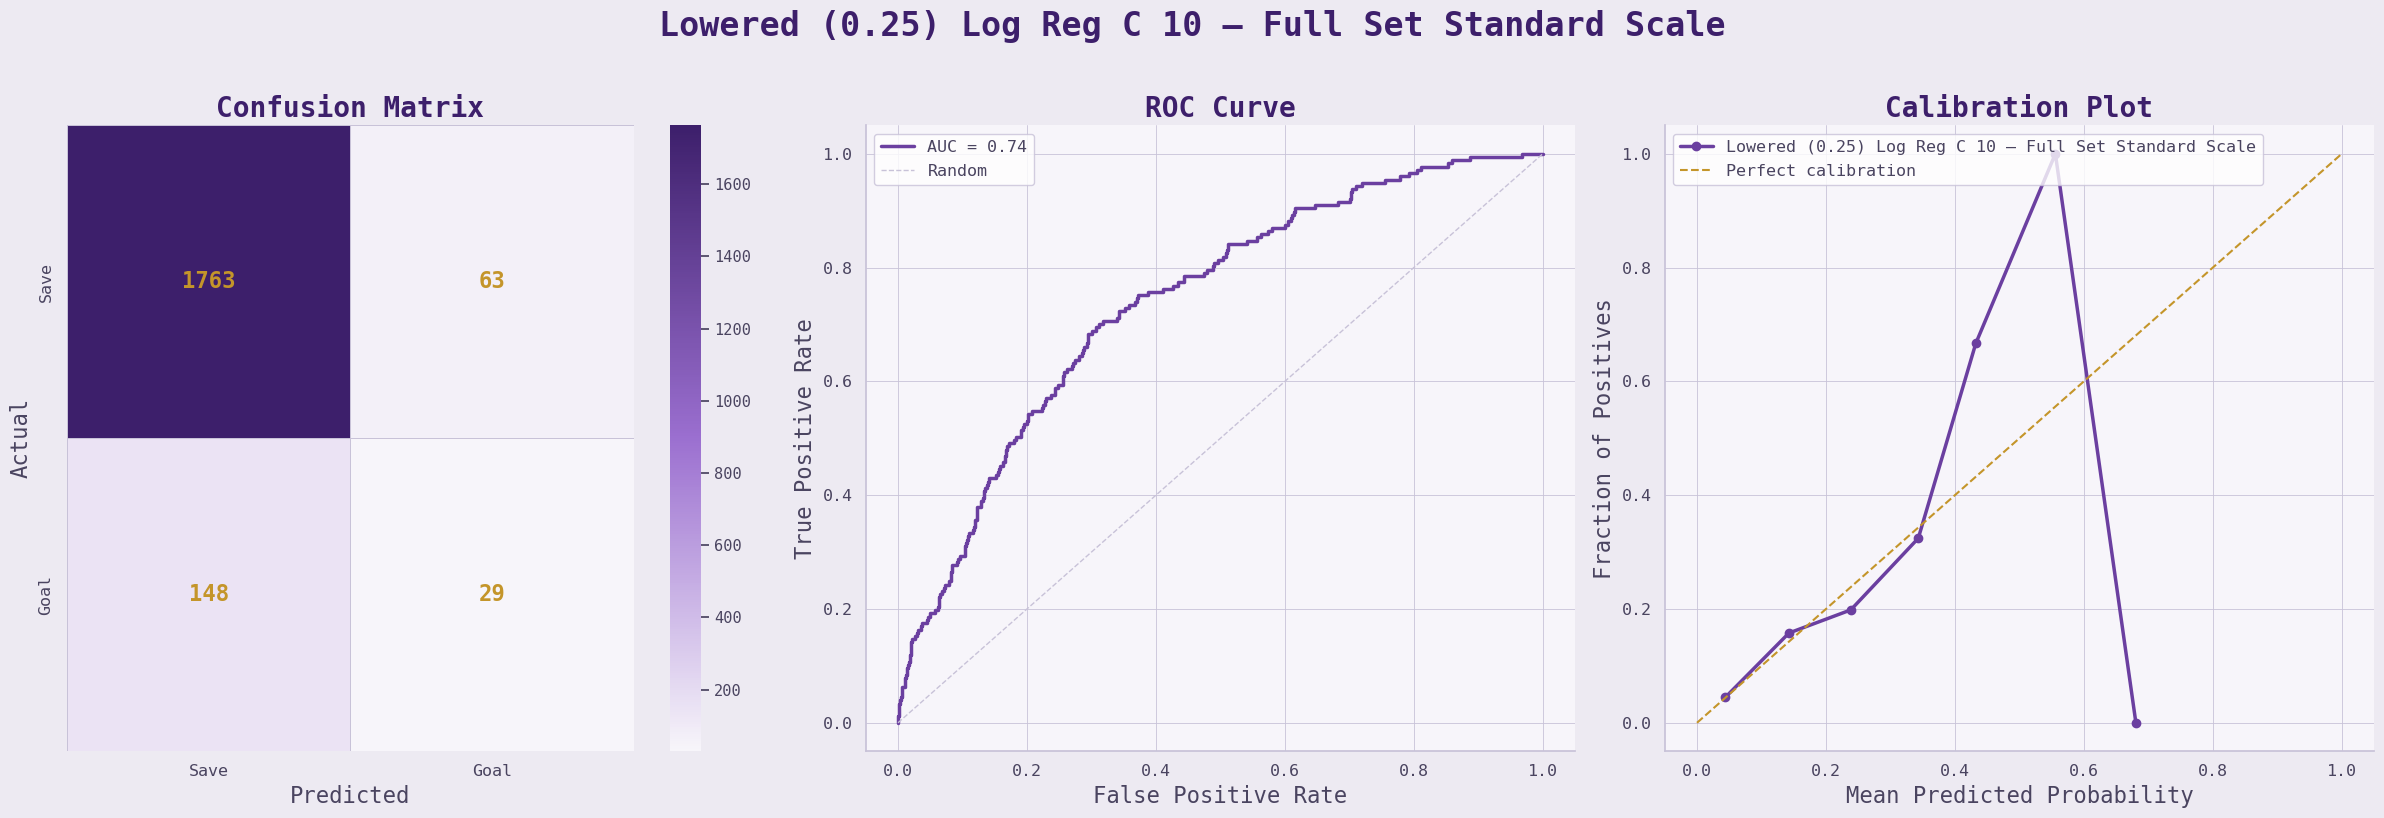

In [62]:
# Best Performing Full Dataset with actual Goal Predictions
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col),
    ('pass',  'passthrough',    boolean_col)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression(C = 10))
])

pipeline.fit(X_train, y_train)
model_eval(pipeline,
           X_test,
           y_test,
           model_name="Lowered (0.25) Log Reg C 10 — Full Set Standard Scale",
           threshold = 0.25)

In [63]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
coef_df = pd.DataFrame({
    'feature':     feature_names,
    'coefficient': pipeline.named_steps['model'].coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print(coef_df)

                          feature  coefficient
3                  scale__dist_ft    -2.918405
1                     scale__x_ft    -2.160382
10                 pass__backhand    -0.833374
9                   pass__rebound     0.761438
14                    pass__wrist    -0.534597
17               pass__is_forward    -0.532610
5   scale__shooter_career_quality     0.461226
13                      pass__tip    -0.439910
12                     pass__snap    -0.416002
11                     pass__slap     0.273729
18                     pass__pwhl     0.233975
2                    scale__y_abs     0.208007
6   scale__goalie_career_save_pct    -0.165958
8                   pass__winning     0.058487
4                scale__angle_deg     0.051827
0                scale__game_time    -0.034115
15                     pass__slot     0.018345
16               pass__close_game    -0.006523
7                    pass__losing    -0.000636


I'm suspicious that `x_ft` and `dist_ft` contribute greatly but `slot` does not, these could still have overlapping contributions.  Interestingly, `winning`, `losing` and `close_game` do not look like they contribute meaningfully.


   Lowered (0.25) Log Reg — Selected Set Standard Scale
  Baseline (always predict save): 91.17%
  Accuracy:                       90.26%
  AUC:                            0.737
  Log Loss:                       0.269
  Avg Precision (PR-AUC):         0.229

              precision    recall  f1-score   support

        Save       0.92      0.98      0.95      1826
        Goal       0.36      0.13      0.19       177

    accuracy                           0.90      2003
   macro avg       0.64      0.55      0.57      2003
weighted avg       0.87      0.90      0.88      2003



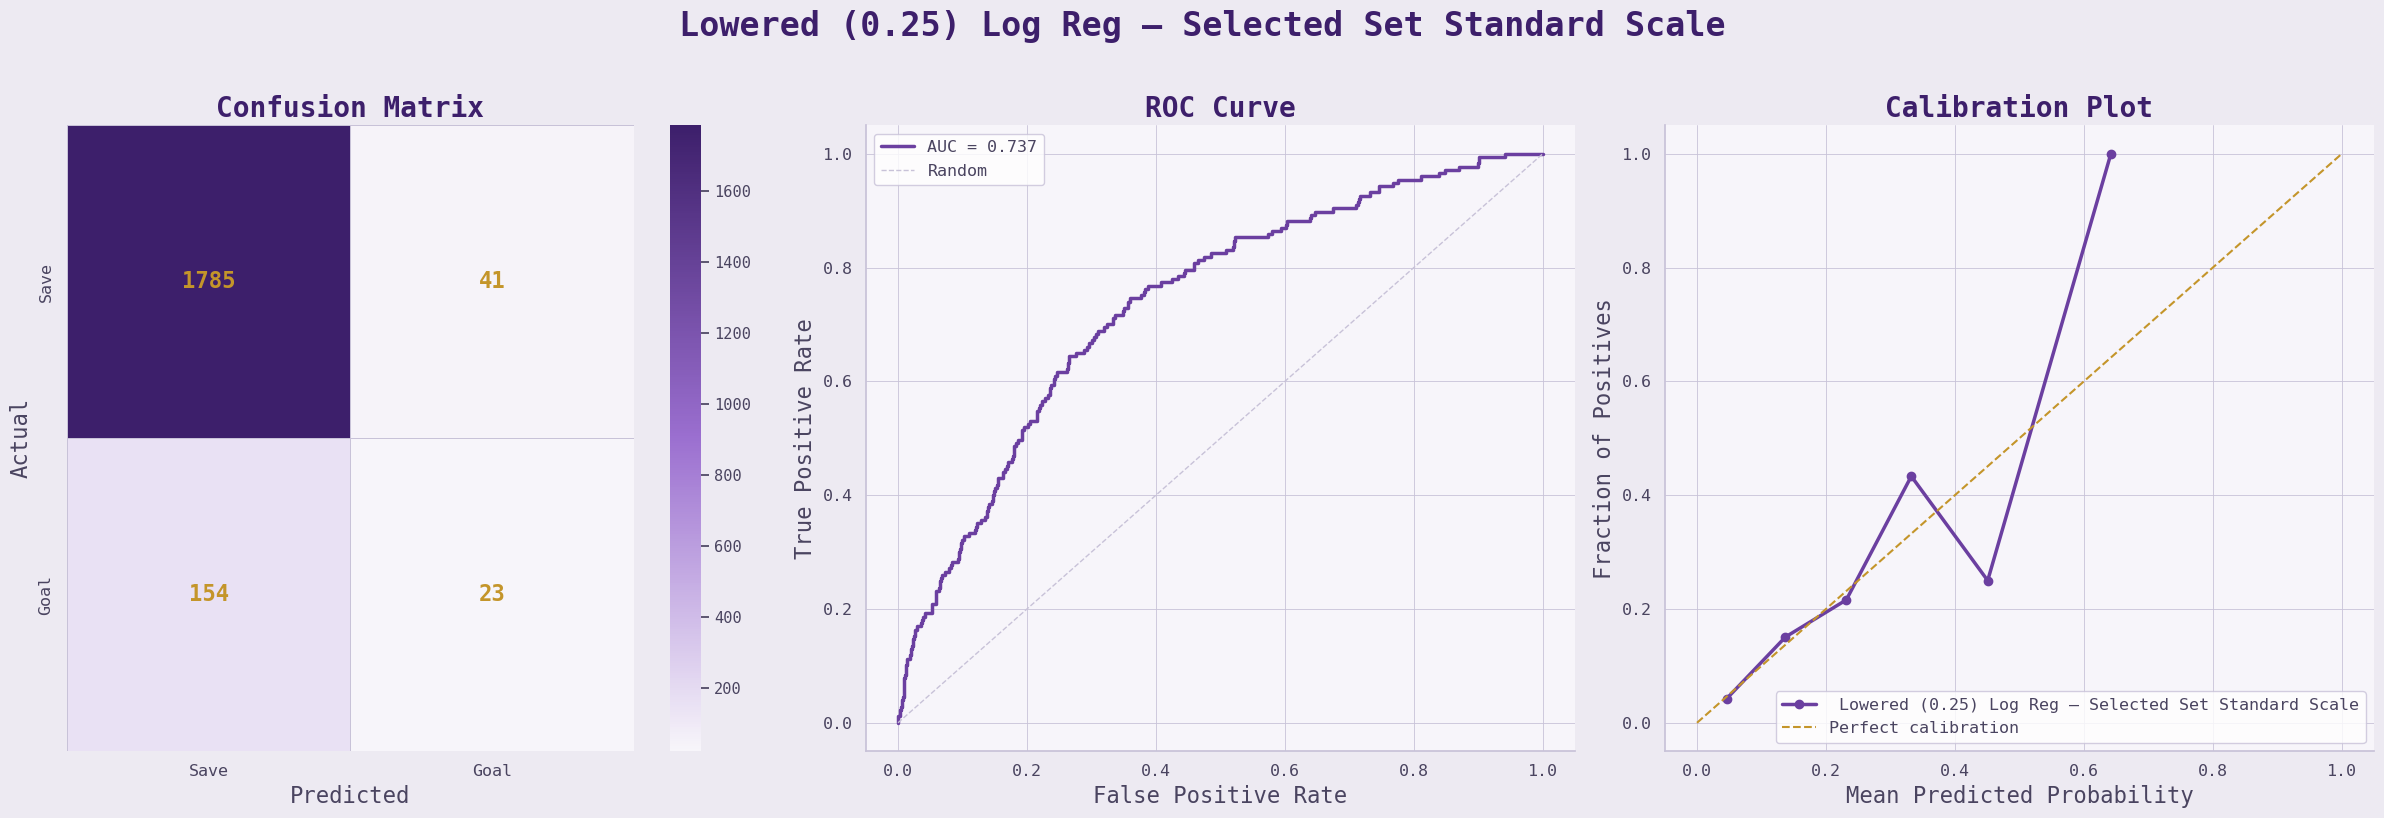

In [64]:
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), continuous_col_sel),
    ('pass',  'passthrough',    boolean_col_sel)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model',        LogisticRegression())
])

pipeline.fit(X_train[selected_cols], y_train)
model_eval(pipeline,
           X_test[selected_cols],
           y_test,
           model_name=" Lowered (0.25) Log Reg — Selected Set Standard Scale",
           threshold = 0.25)

In [65]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
coef_df = pd.DataFrame({
    'feature':     feature_names,
    'coefficient': pipeline.named_steps['model'].coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print(coef_df)

                         feature  coefficient
4                  pass__rebound     0.814178
1                   scale__y_abs    -0.523645
2  scale__shooter_career_quality     0.379652
0                    scale__x_ft     0.230675
5                     pass__slot     0.208594
3  scale__goalie_career_save_pct    -0.171647


Removing `dist_ft` from the model shows that `x_ft` and `slot` contribute more equally, which seems more appropriate.  Having no shot type at all in this data is interesting in the sense that it does not seem to make a meaningful impact on lowering the accuracy.

In the end, the best performing Logistic Regression Model used the full Even Strength dataset with Standard scaling, tuning the c-value up to 10, which result in a score of **AUC = 0.7398**.  Lowering the threshold for predictions from 0.5 down to 0.25 lowered the accuracy from 91.2% down to 89.5% but the number of goal predictions went from 2 to 92.

It was difficult to get the Logistic Regression models to reliably predict goals in general.  Decreasing the threshold to 0.25 did seem to make a meaningful difference which could be taken into account.  The nature of hockey is that even if you have a GREAT scoring chance, your shot is still more likely to get saved, so lowering the threshold may reflect that game day reality.

However, I would still like an effective xG model that can predict goals more reliably, and have more precision in doing so. Therefore, we will continue on to using XGBoost models to model the Even Strength data.

<a id = 'xgboost'></a>

## 3. XGBoost Modelling


  XGBoost - Full Base
  Baseline (always predict save): 91.17%
  Accuracy:                       90.61%
  AUC:                            0.703
  Log Loss:                       0.314
  Avg Precision (PR-AUC):         0.181

              precision    recall  f1-score   support

        Save       0.91      0.99      0.95      1826
        Goal       0.31      0.05      0.09       177

    accuracy                           0.91      2003
   macro avg       0.61      0.52      0.52      2003
weighted avg       0.86      0.91      0.87      2003



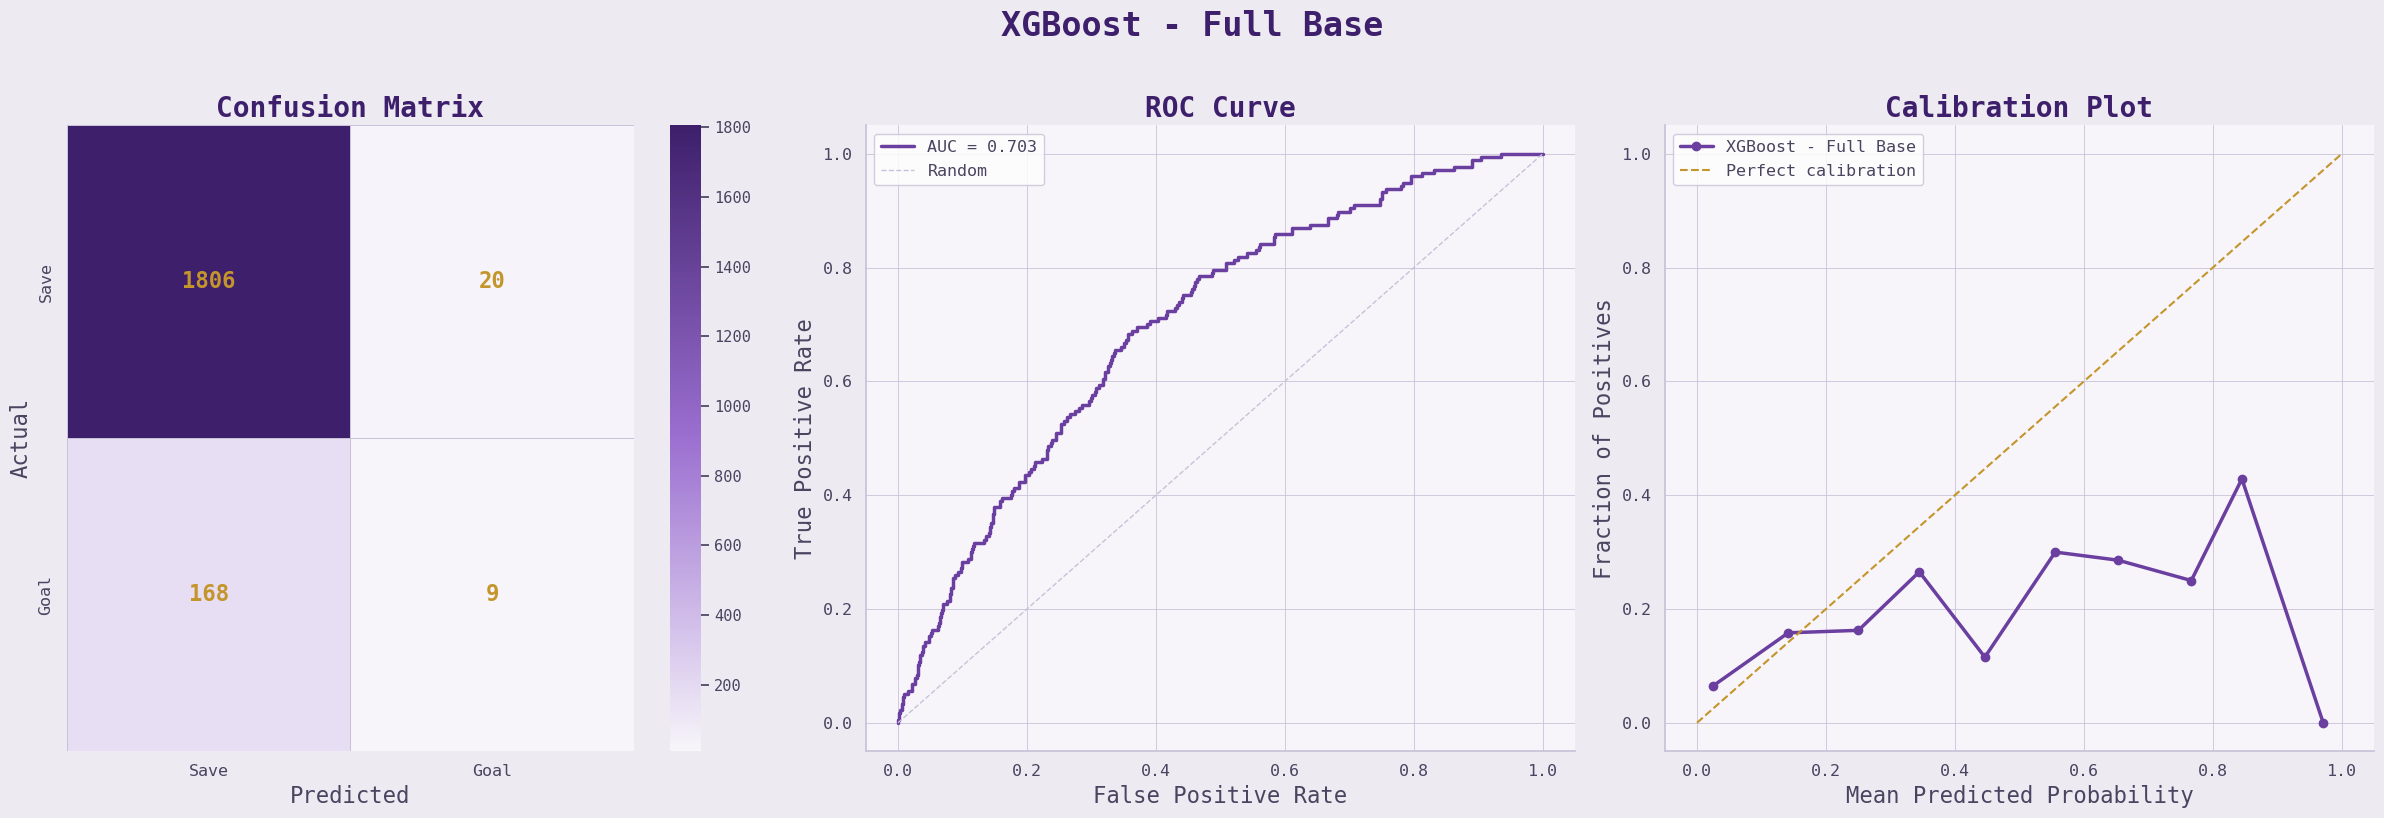

In [66]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss')

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Full Base")


  XGBoost - Selected Base
  Baseline (always predict save): 91.17%
  Accuracy:                       90.31%
  AUC:                            0.695
  Log Loss:                       0.311
  Avg Precision (PR-AUC):         0.164

              precision    recall  f1-score   support

        Save       0.91      0.99      0.95      1826
        Goal       0.26      0.05      0.08       177

    accuracy                           0.90      2003
   macro avg       0.59      0.52      0.52      2003
weighted avg       0.86      0.90      0.87      2003



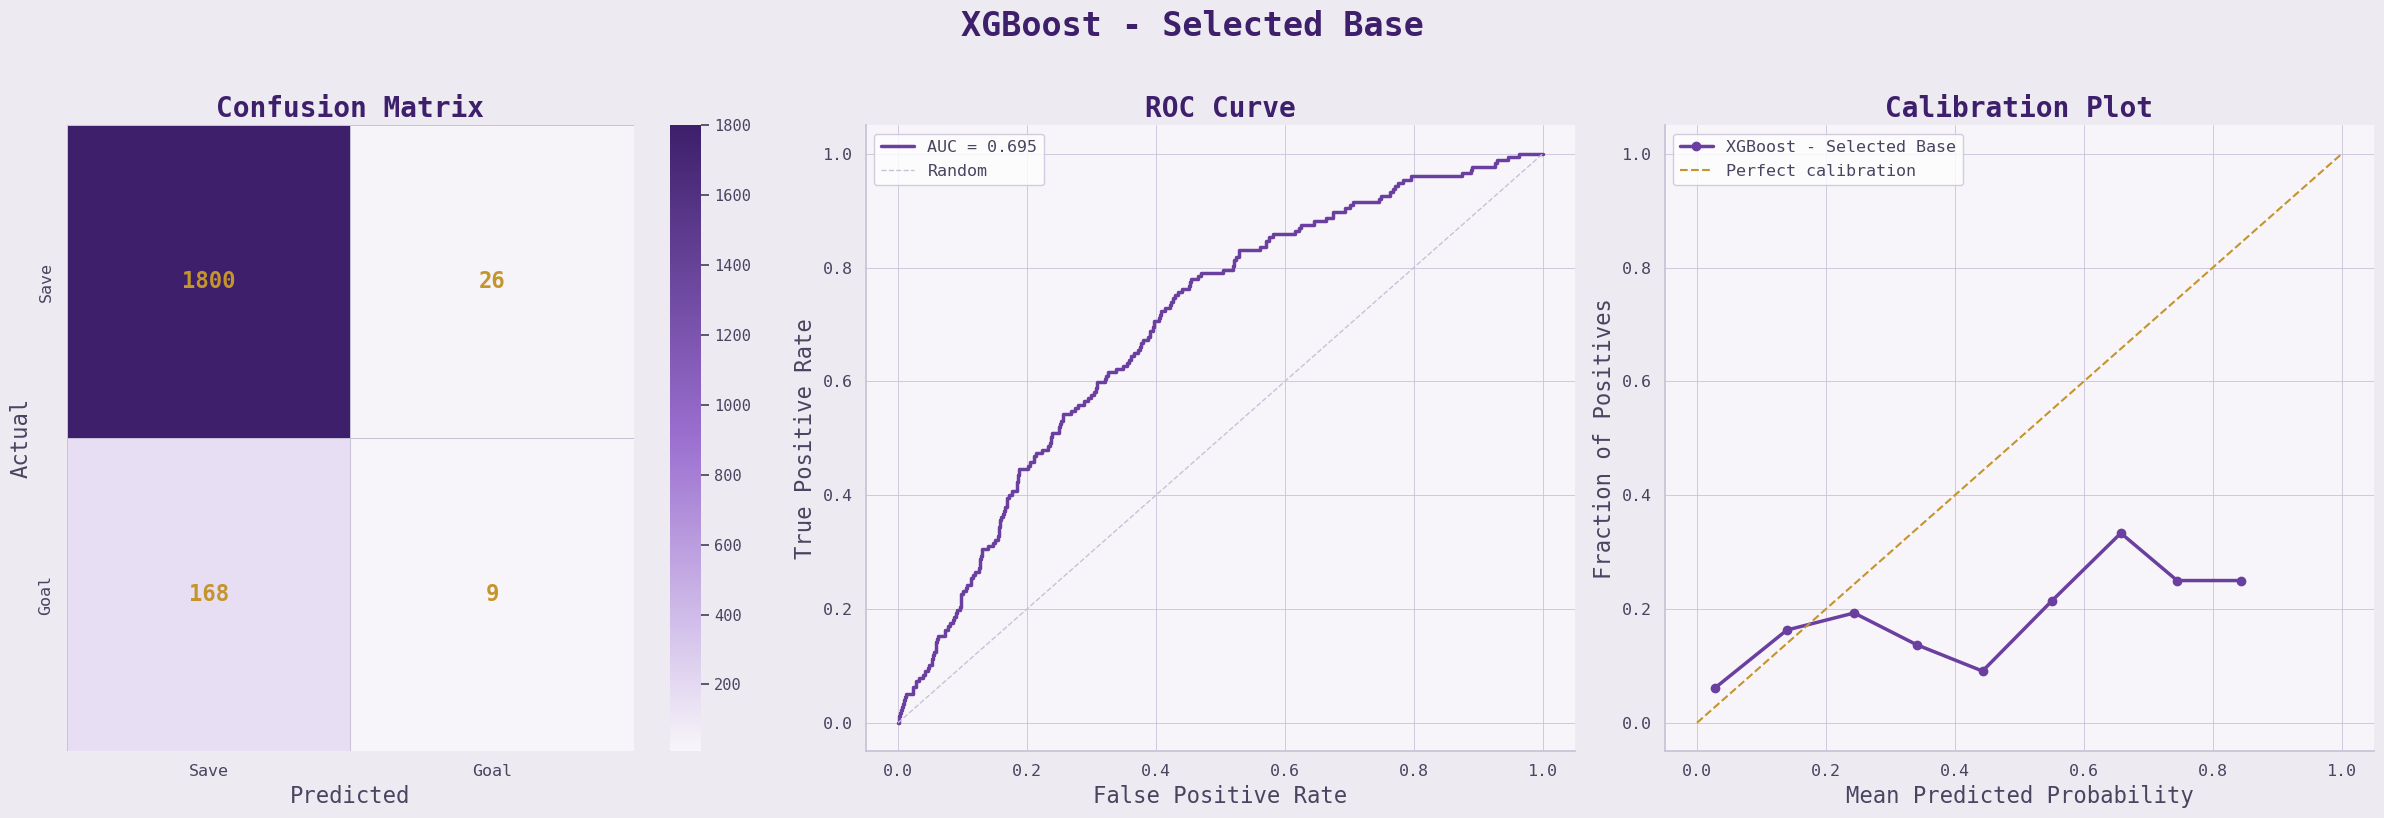

In [67]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss')

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Base")

This is a more promising start compared to the Logistic Regression models.  The AUC is lower, but the base model is already predicting more goals, albeit still a small number.

The first adjustment I want to make is to address the class imbalance.  I'll try a weighting that reflects the mismatch in the classes, and then try to strengthen and weaken the weighting.

In [68]:
# Classifying the default weight as the proportion of Saves to Goals
weight = len(y_train[y_train==0]) / len(y_train[y_train==1])


  XGBoost - Full Weighted
  Baseline (always predict save): 91.17%
  Accuracy:                       85.72%
  AUC:                            0.692
  Log Loss:                       0.371
  Avg Precision (PR-AUC):         0.164

              precision    recall  f1-score   support

        Save       0.92      0.92      0.92      1826
        Goal       0.21      0.23      0.22       177

    accuracy                           0.86      2003
   macro avg       0.57      0.57      0.57      2003
weighted avg       0.86      0.86      0.86      2003



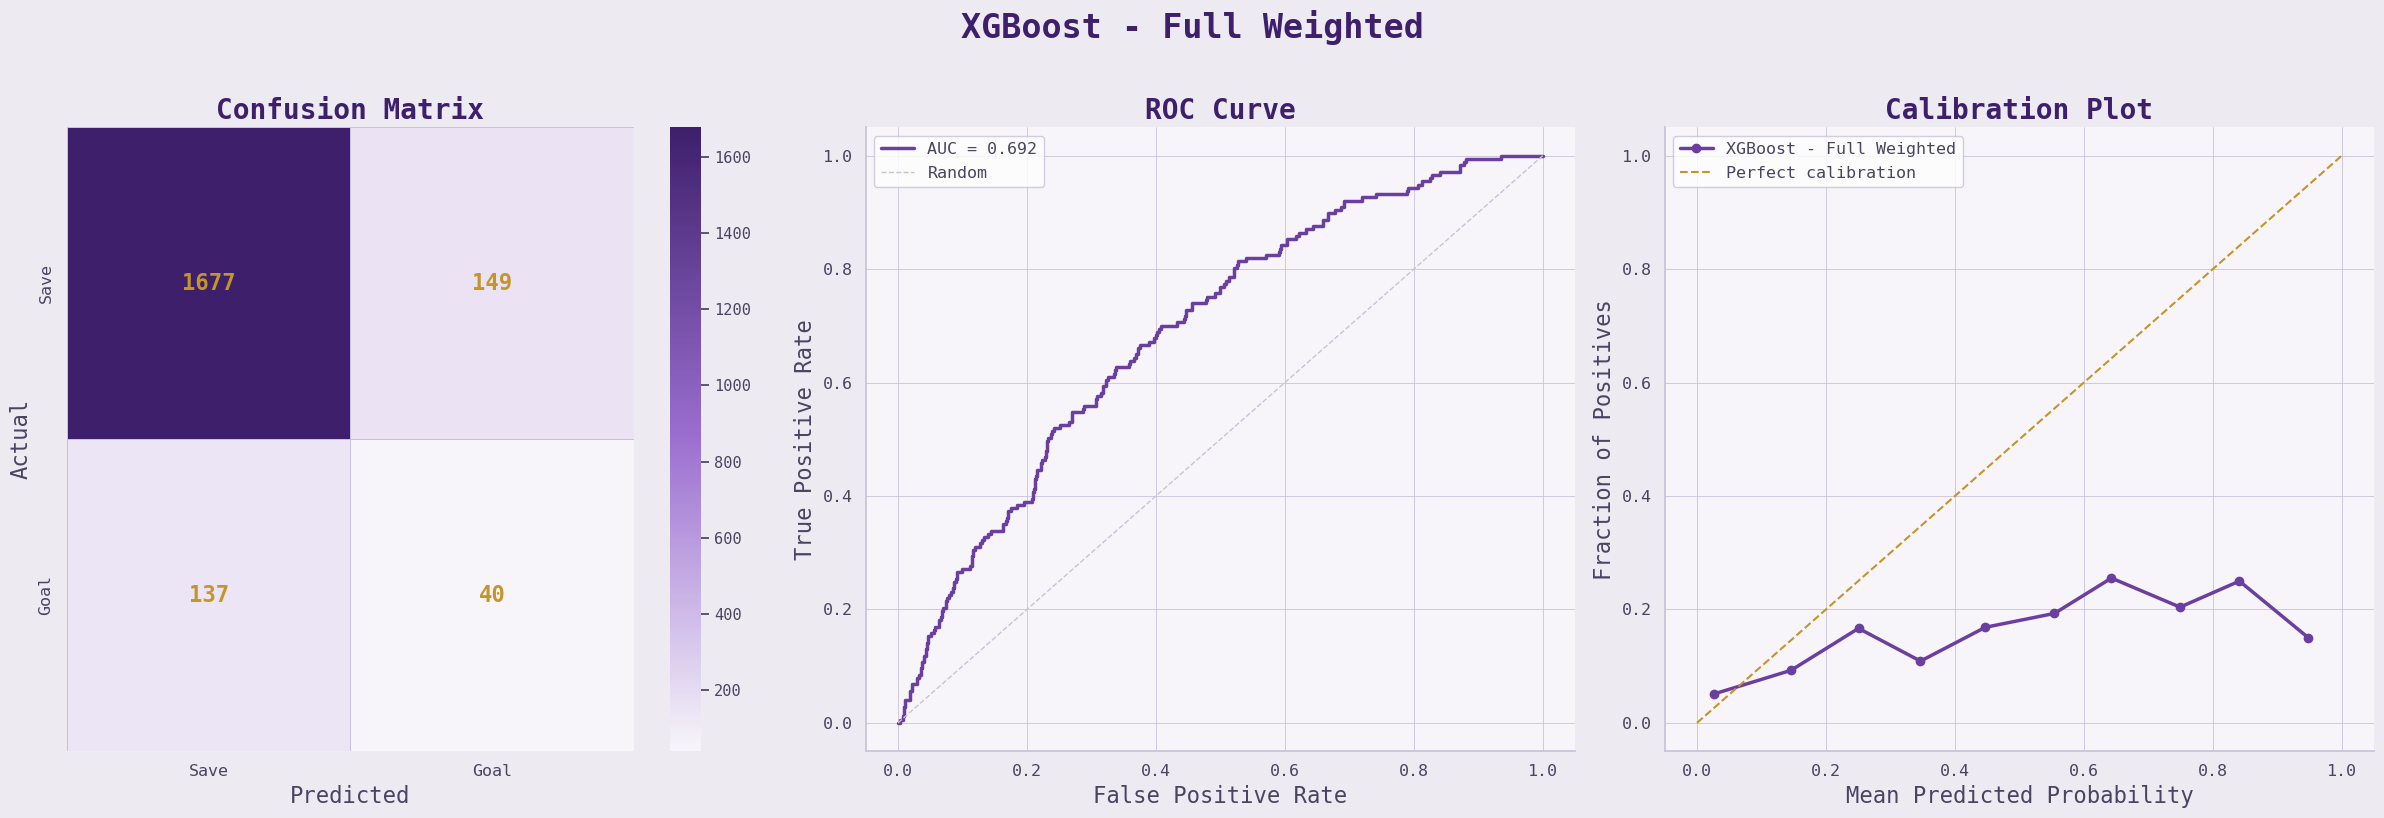

In [69]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=weight)

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Full Weighted")


  XGBoost - Full Weighted Doubled
  Baseline (always predict save): 91.17%
  Accuracy:                       82.53%
  AUC:                            0.686
  Log Loss:                       0.409
  Avg Precision (PR-AUC):         0.154

              precision    recall  f1-score   support

        Save       0.93      0.88      0.90      1826
        Goal       0.19      0.31      0.24       177

    accuracy                           0.83      2003
   macro avg       0.56      0.59      0.57      2003
weighted avg       0.86      0.83      0.84      2003



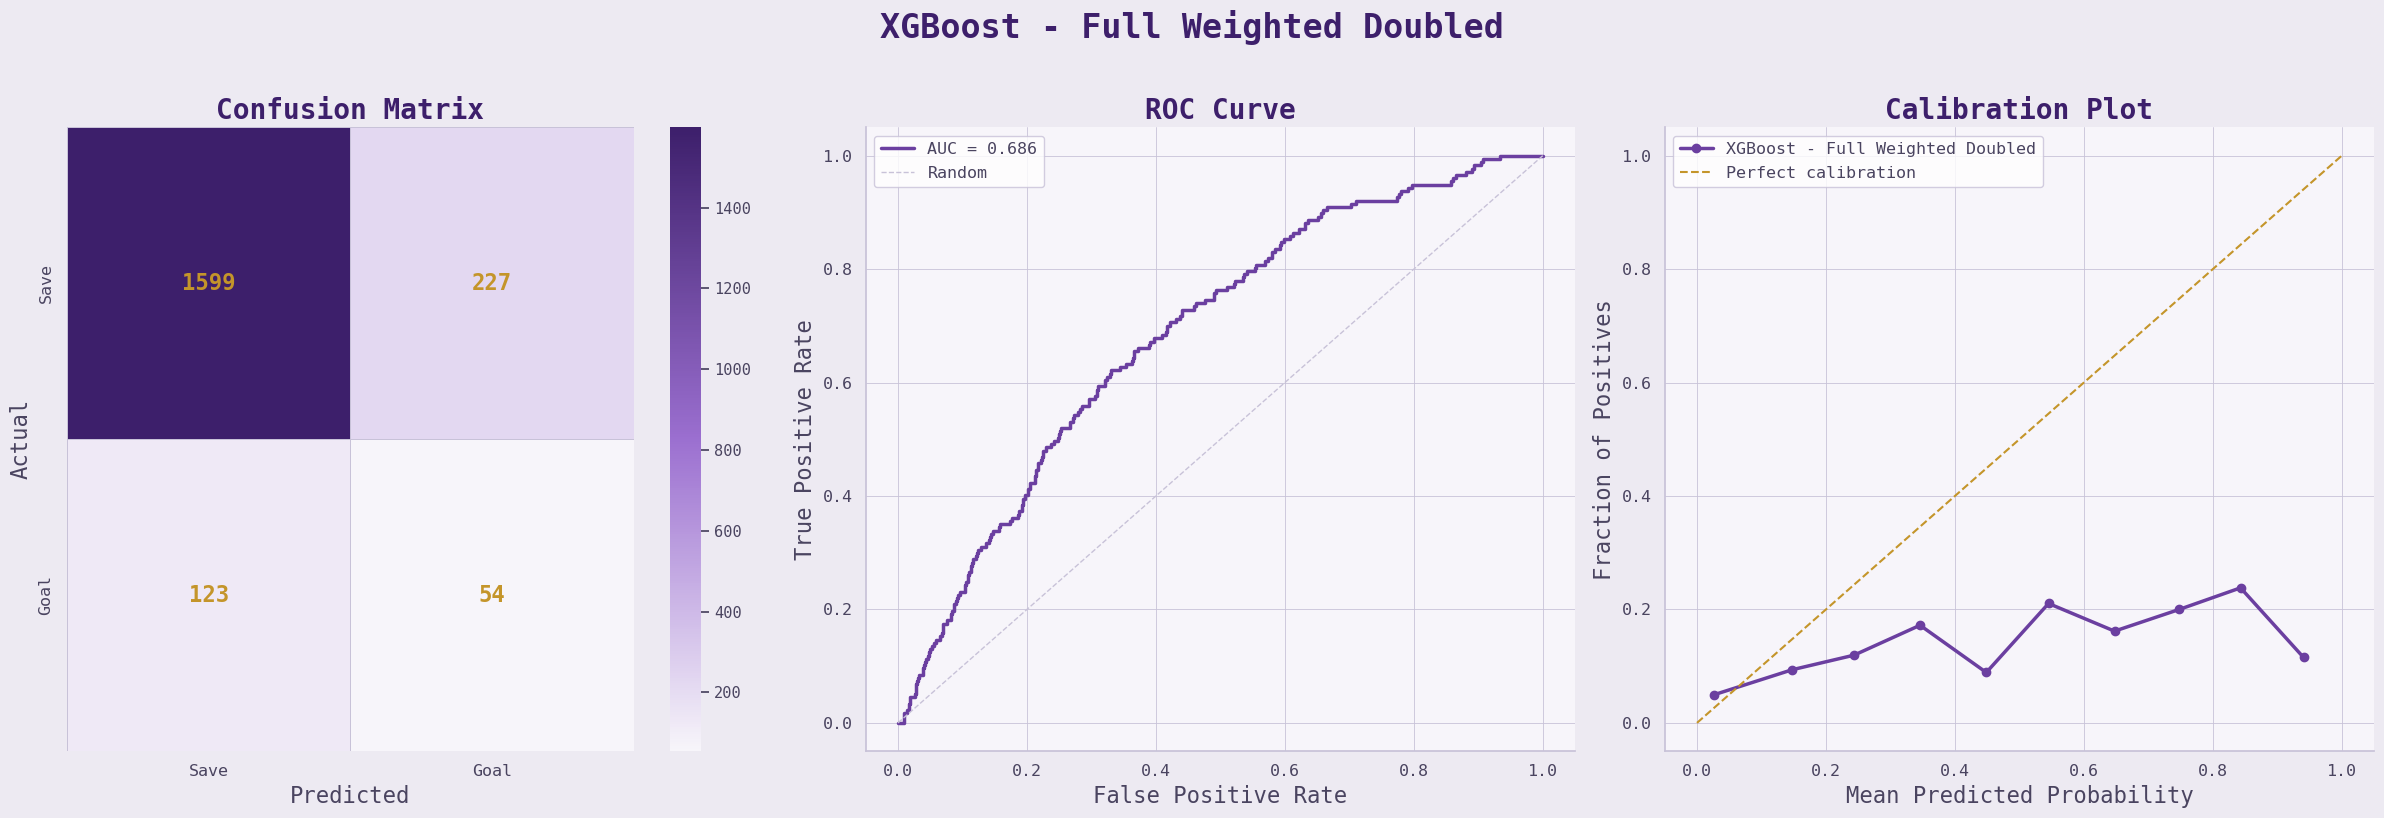

In [70]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=weight*2)

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Full Weighted Doubled")


  XGBoost - Full Weighted Halved
  Baseline (always predict save): 91.17%
  Accuracy:                       87.02%
  AUC:                            0.665
  Log Loss:                       0.358
  Avg Precision (PR-AUC):         0.154

              precision    recall  f1-score   support

        Save       0.92      0.94      0.93      1826
        Goal       0.16      0.11      0.13       177

    accuracy                           0.87      2003
   macro avg       0.54      0.53      0.53      2003
weighted avg       0.85      0.87      0.86      2003



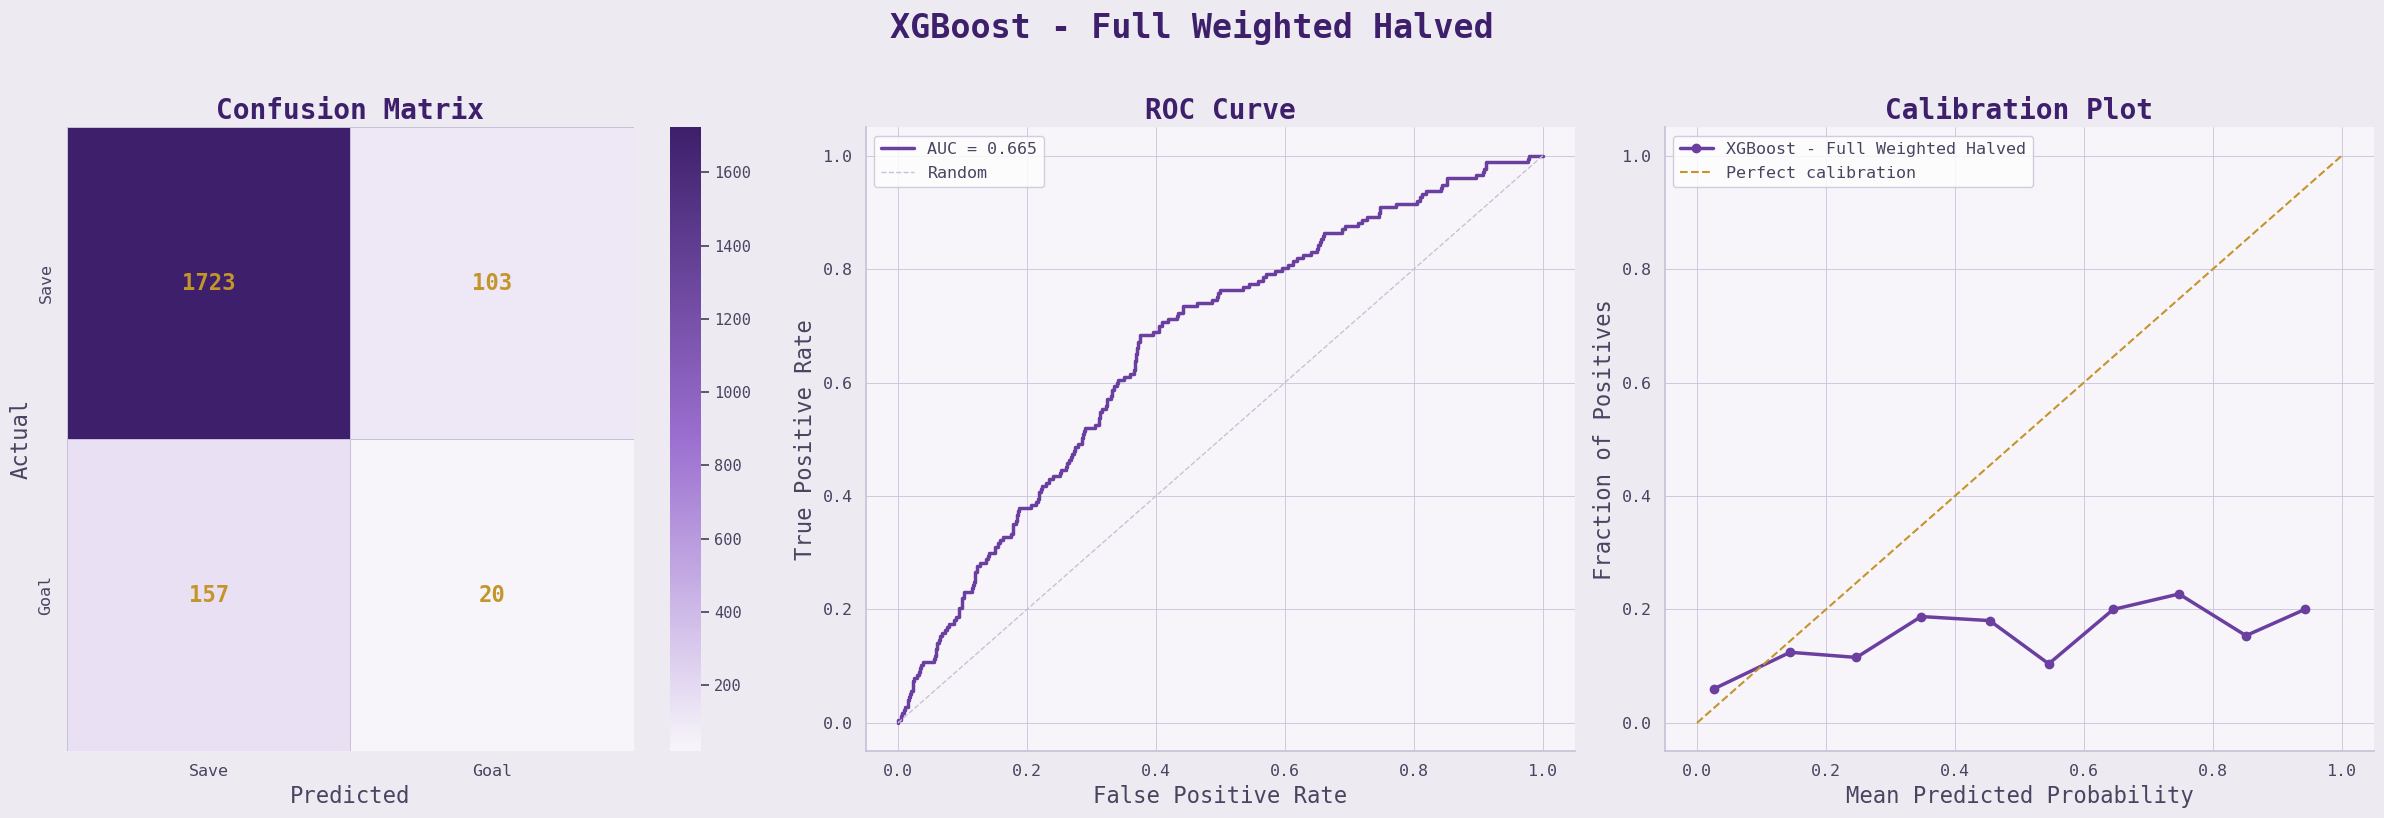

In [71]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=weight/2)

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Full Weighted Halved")


  XGBoost - Selected Weighted
  Baseline (always predict save): 91.17%
  Accuracy:                       82.03%
  AUC:                            0.68
  Log Loss:                       0.41
  Avg Precision (PR-AUC):         0.156

              precision    recall  f1-score   support

        Save       0.93      0.87      0.90      1826
        Goal       0.18      0.28      0.22       177

    accuracy                           0.82      2003
   macro avg       0.55      0.58      0.56      2003
weighted avg       0.86      0.82      0.84      2003



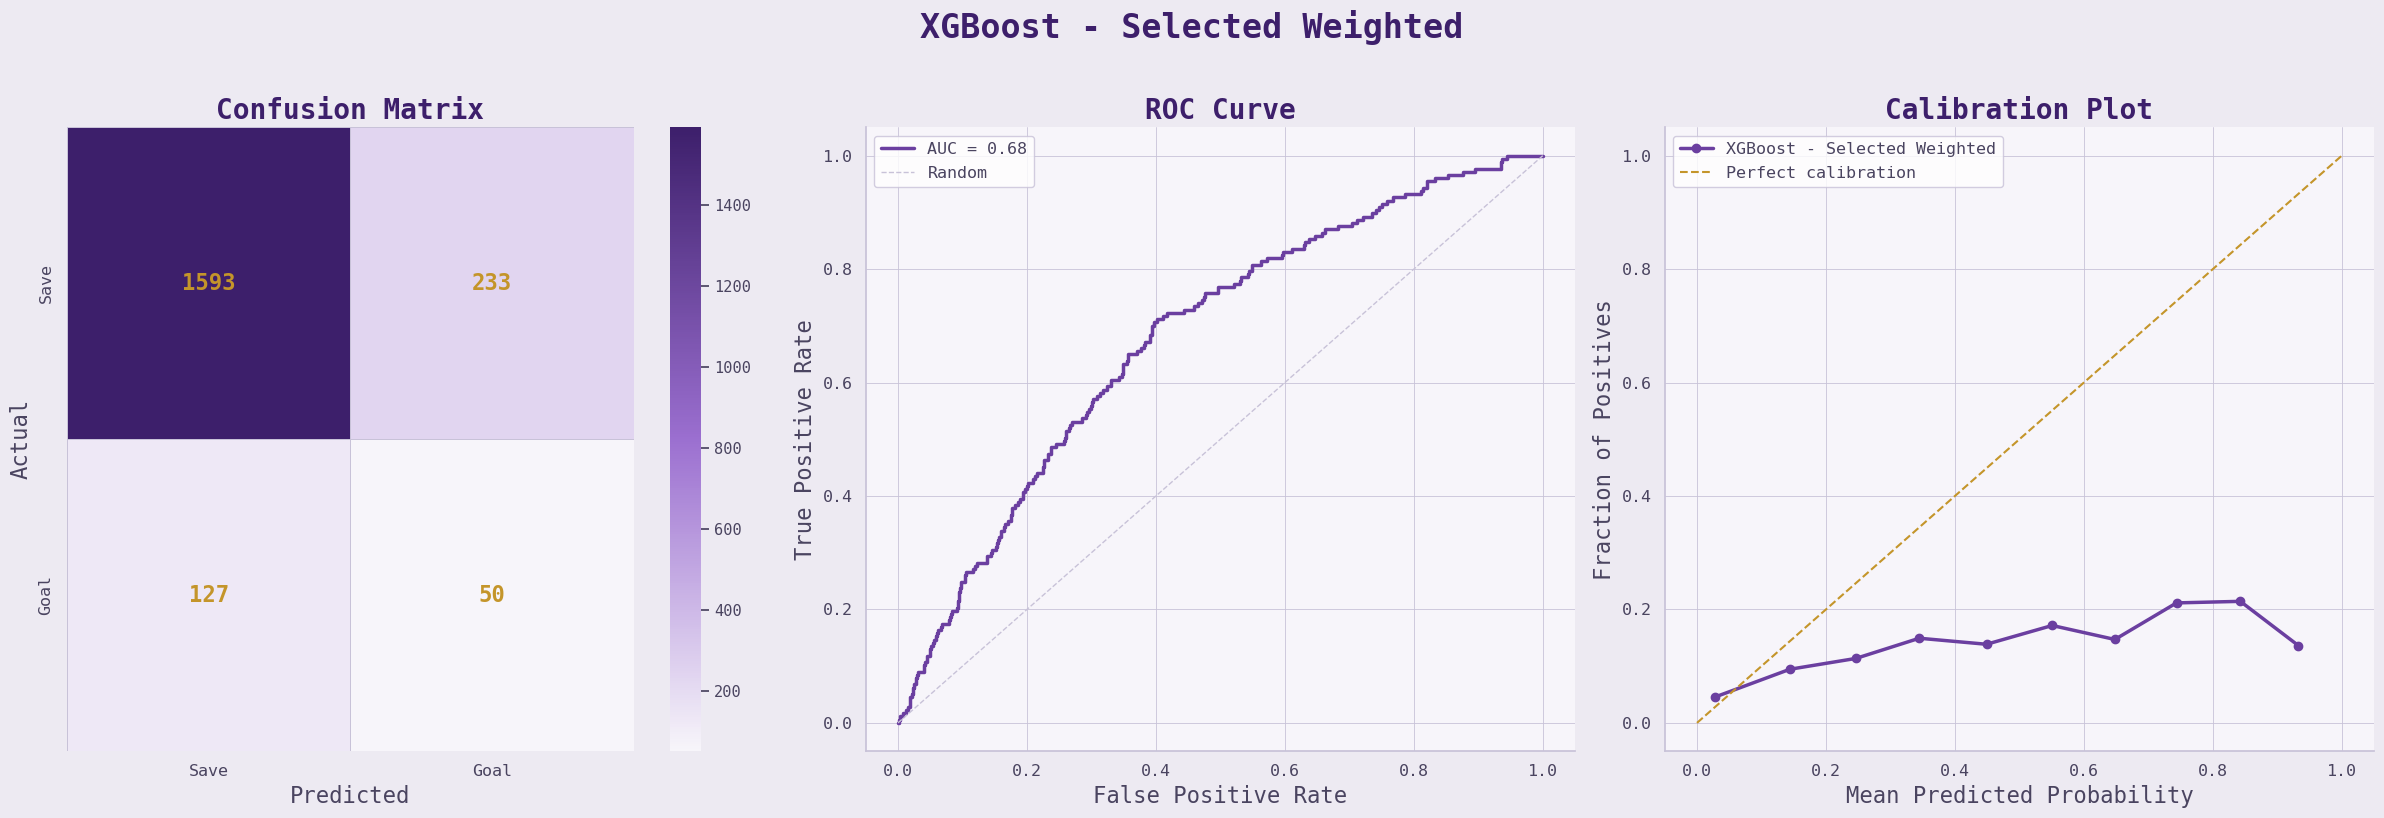

In [72]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=weight)

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Weighted")


  XGBoost - Selected Weighted Doubled
  Baseline (always predict save): 91.17%
  Accuracy:                       78.03%
  AUC:                            0.665
  Log Loss:                       0.481
  Avg Precision (PR-AUC):         0.153

              precision    recall  f1-score   support

        Save       0.93      0.82      0.87      1826
        Goal       0.16      0.36      0.23       177

    accuracy                           0.78      2003
   macro avg       0.55      0.59      0.55      2003
weighted avg       0.86      0.78      0.81      2003



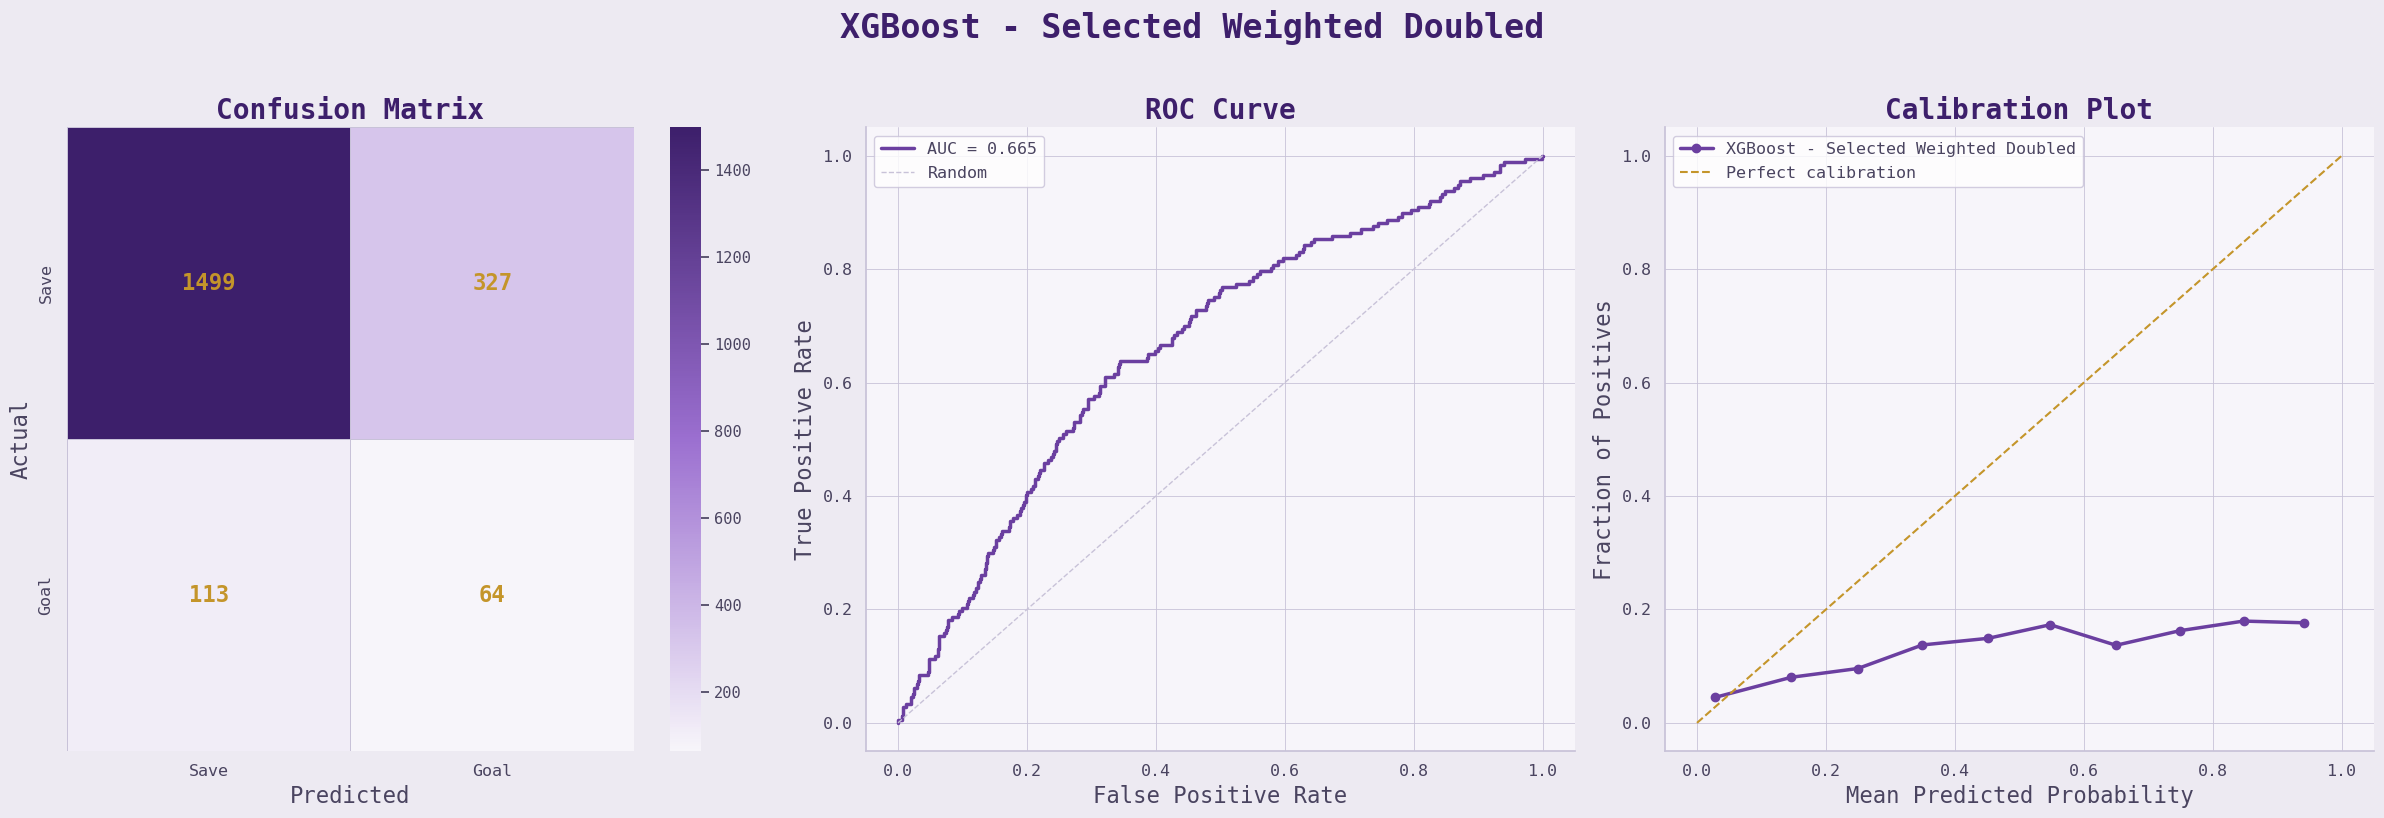

In [73]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=weight*2)

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Weighted Doubled")


  XGBoost - Selected Weighted Halved
  Baseline (always predict save): 91.17%
  Accuracy:                       85.52%
  AUC:                            0.684
  Log Loss:                       0.36
  Avg Precision (PR-AUC):         0.159

              precision    recall  f1-score   support

        Save       0.92      0.92      0.92      1826
        Goal       0.18      0.18      0.18       177

    accuracy                           0.86      2003
   macro avg       0.55      0.55      0.55      2003
weighted avg       0.86      0.86      0.86      2003



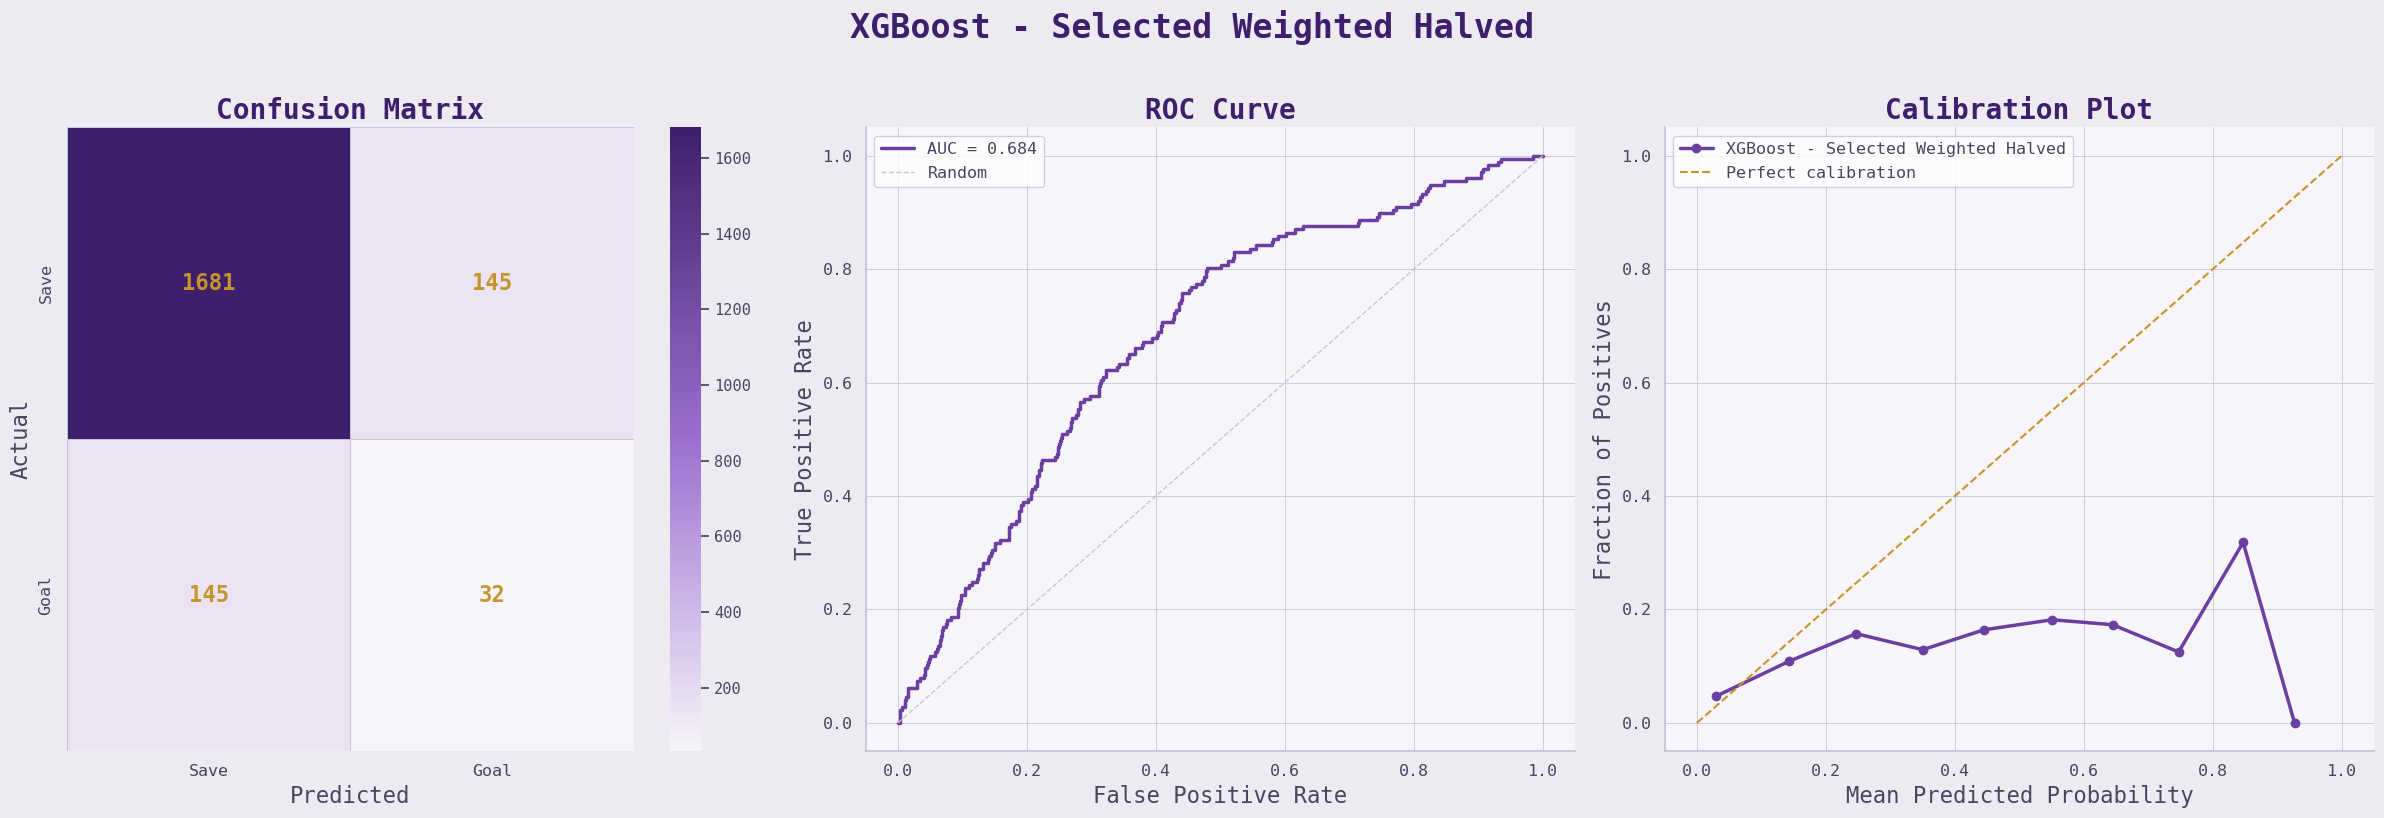

In [74]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    scale_pos_weight=weight/2)

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Weighted Halved")

Unfortunately, the XGBoost models are all underperforming relative to the Logistic Regression models so far.  Adding weight to the models was detrimental to the AUC and the accuracy of the models.  Hopefully, tuning the models will yield a better outcome.

Considering that we've seen success previously on lowering the thresholds for predictions, we will see how the models change with changing the threshold with the tuned parameters.

In [75]:
param_grid = {
    'n_estimators':  [100, 200, 300, 400, 500],
    'max_depth':     [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample':     [0.5, 0.6, 0.7, 0.8],
}

grid = GridSearchCV(xgb, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7} 0.741530655692538



  XGBoost - Full Tuned Unweighted
  Baseline (always predict save): 91.17%
  Accuracy:                       90.91%
  AUC:                            0.742
  Log Loss:                       0.27
  Avg Precision (PR-AUC):         0.212

              precision    recall  f1-score   support

        Save       0.91      1.00      0.95      1826
        Goal       0.27      0.02      0.03       177

    accuracy                           0.91      2003
   macro avg       0.59      0.51      0.49      2003
weighted avg       0.86      0.91      0.87      2003



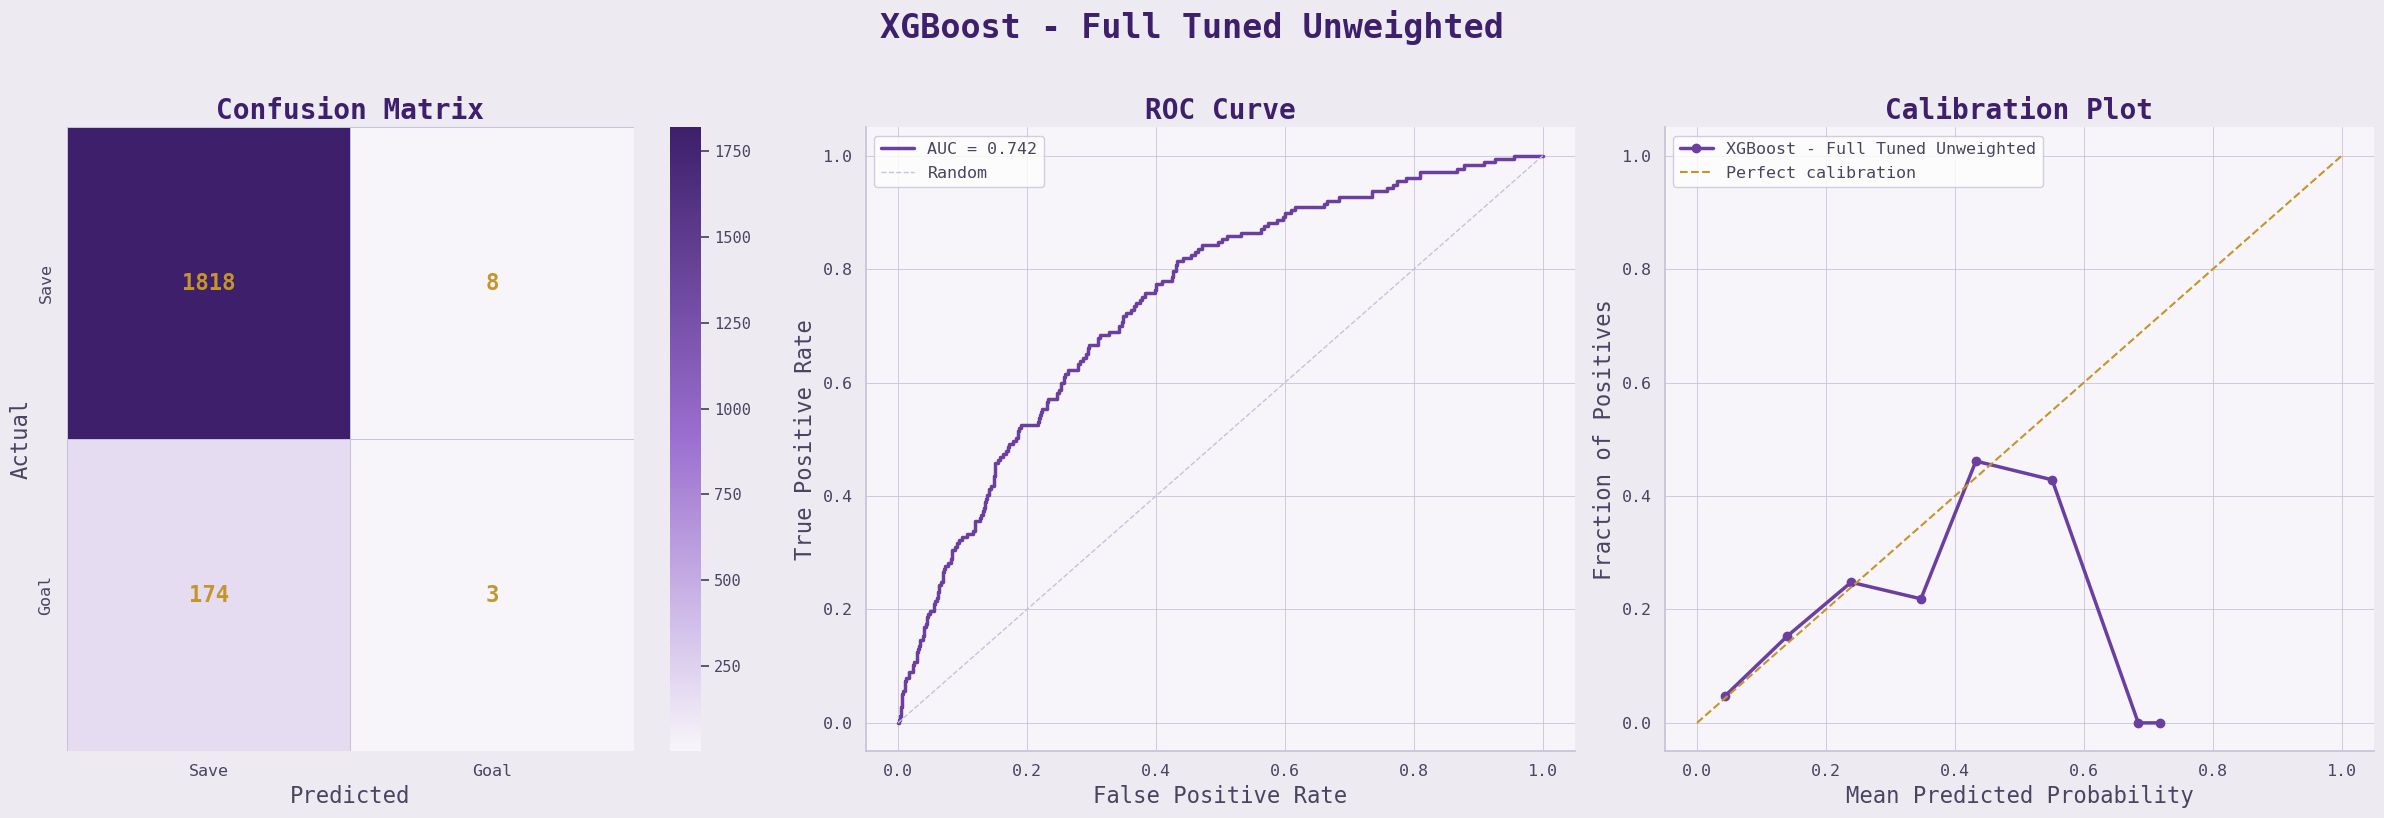

In [76]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 200,
                    max_depth = 3,
                    learning_rate = 0.05,
                    subsample = 0.7)

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Full Tuned Unweighted")


  Lowered (0.25) XGBoost - Full Tuned Unweighted
  Baseline (always predict save): 91.17%
  Accuracy:                       88.97%
  AUC:                            0.742
  Log Loss:                       0.27
  Avg Precision (PR-AUC):         0.212

              precision    recall  f1-score   support

        Save       0.92      0.96      0.94      1826
        Goal       0.28      0.15      0.20       177

    accuracy                           0.89      2003
   macro avg       0.60      0.56      0.57      2003
weighted avg       0.86      0.89      0.87      2003



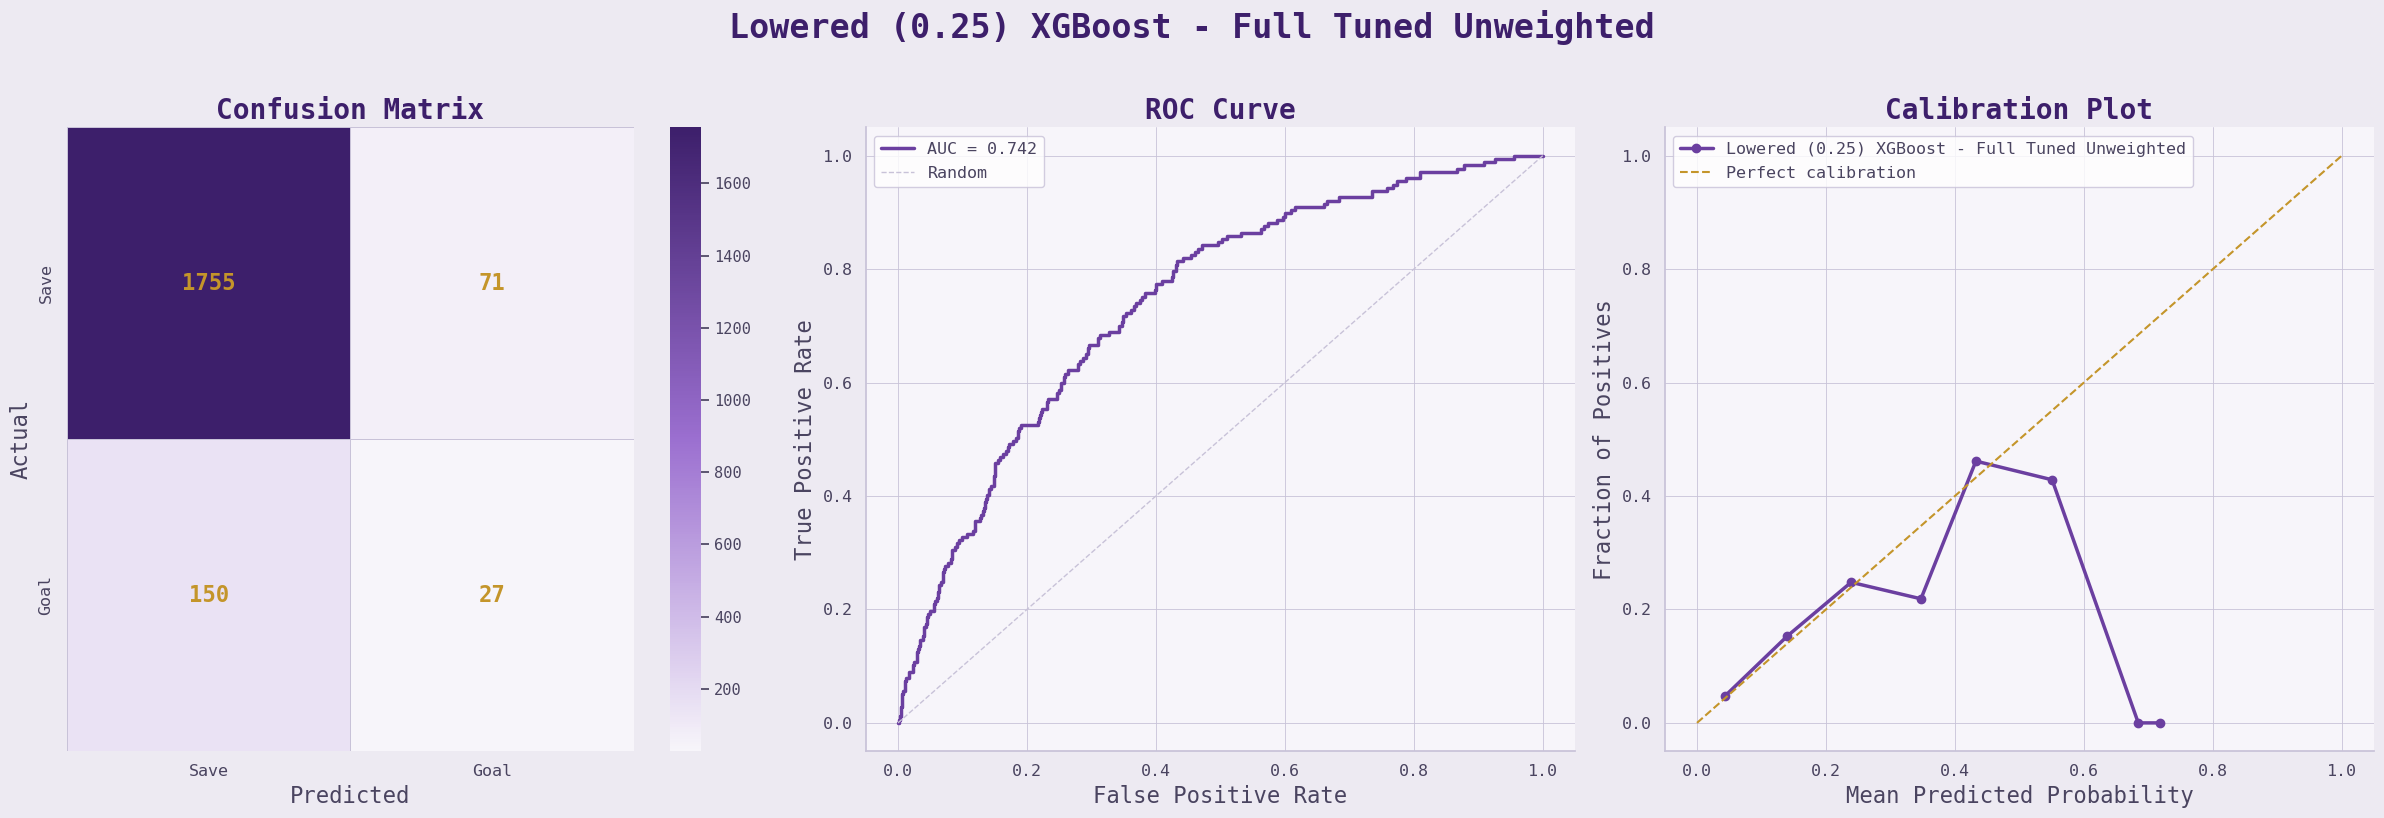

In [77]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 200,
                    max_depth = 3,
                    learning_rate = 0.05,
                    subsample = 0.7)

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "Lowered (0.25) XGBoost - Full Tuned Unweighted", threshold = 0.25)

In [78]:
param_grid = {
    'n_estimators':  [100, 200, 300, 400, 500],
    'max_depth':     [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample':     [0.5, 0.6, 0.7, 0.8],
}

grid = GridSearchCV(xgb, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid.fit(X_train[selected_cols], y_train)
print(grid.best_params_, grid.best_score_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.8} 0.7315555908200378



  XGBoost - Selected Tuned Unweighted
  Baseline (always predict save): 91.17%
  Accuracy:                       91.16%
  AUC:                            0.736
  Log Loss:                       0.271
  Avg Precision (PR-AUC):         0.207

              precision    recall  f1-score   support

        Save       0.91      1.00      0.95      1826
        Goal       0.00      0.00      0.00       177

    accuracy                           0.91      2003
   macro avg       0.46      0.50      0.48      2003
weighted avg       0.83      0.91      0.87      2003



/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brianjohns/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

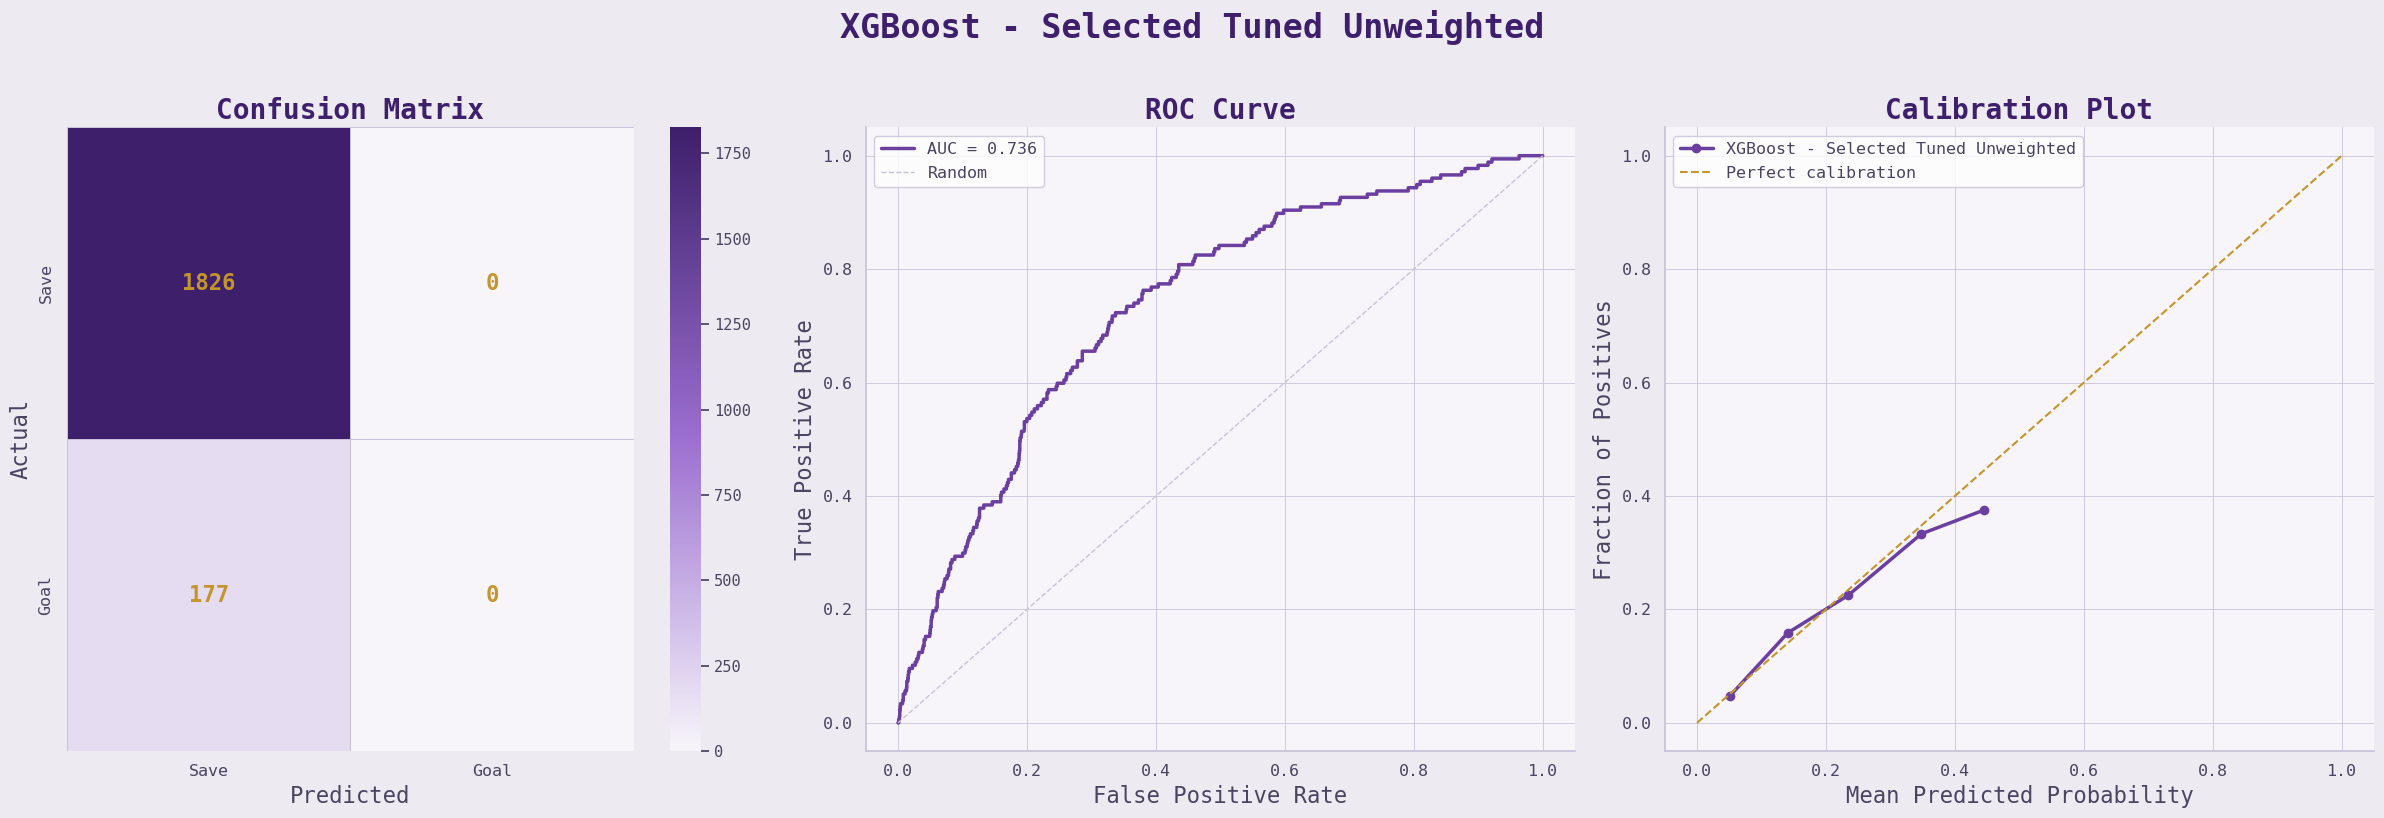

In [79]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 400,
                    max_depth = 3,
                    learning_rate = 0.01,
                    subsample = 0.8)

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Tuned Unweighted")


  Lowered (0.25) XGBoost - Selected Tuned Unweighted
  Baseline (always predict save): 91.17%
  Accuracy:                       90.16%
  AUC:                            0.736
  Log Loss:                       0.271
  Avg Precision (PR-AUC):         0.207

              precision    recall  f1-score   support

        Save       0.92      0.98      0.95      1826
        Goal       0.31      0.10      0.15       177

    accuracy                           0.90      2003
   macro avg       0.62      0.54      0.55      2003
weighted avg       0.86      0.90      0.88      2003



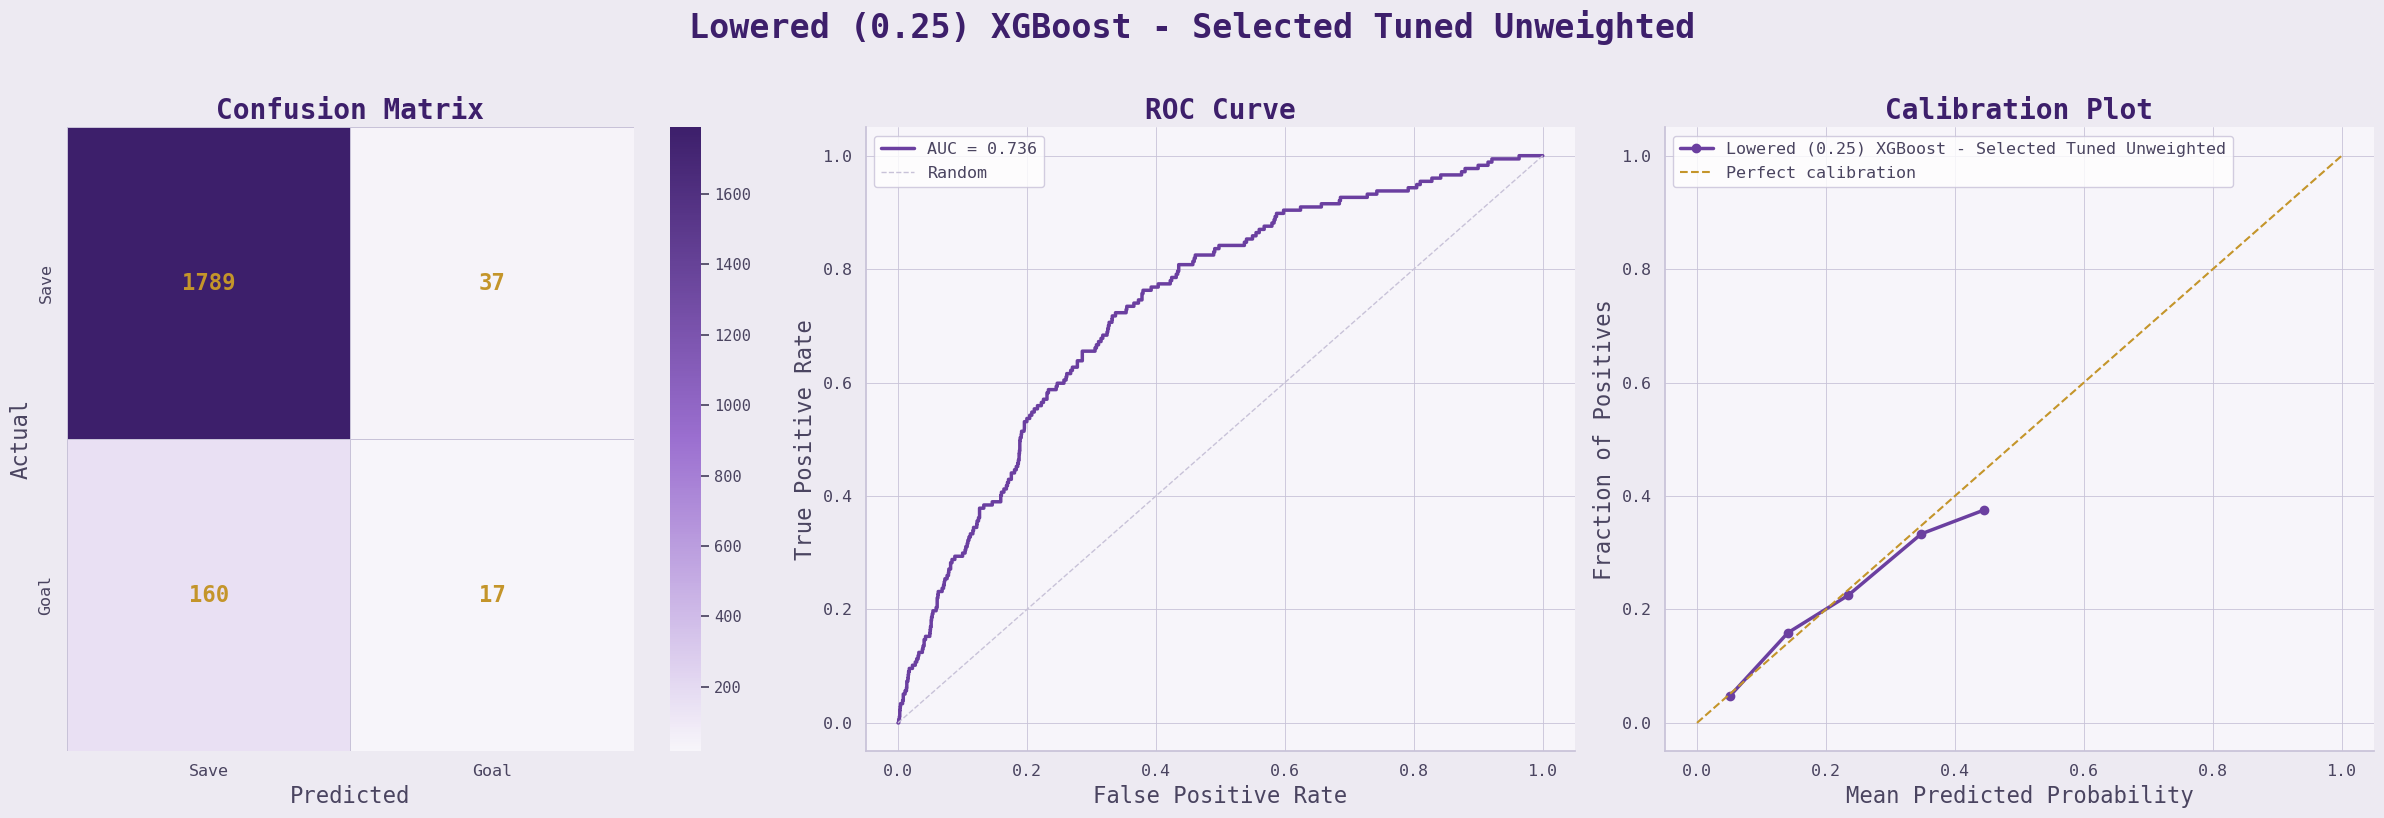

In [80]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 400,
                    max_depth = 3,
                    learning_rate = 0.01,
                    subsample = 0.8)

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "Lowered (0.25) XGBoost - Selected Tuned Unweighted", threshold = 0.25)

In [81]:
param_grid = {
    'n_estimators':  [100, 200, 300, 400, 500],
    'max_depth':     [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample':     [0.5, 0.6, 0.7, 0.8],
    'scale_pos_weight': [weight, weight*2, weight/2]
}

grid = GridSearchCV(xgb, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 5.163366336633663, 'subsample': 0.7} 0.741530655692538



  XGBoost - Full Tuned Weighted
  Baseline (always predict save): 91.17%
  Accuracy:                       84.47%
  AUC:                            0.743
  Log Loss:                       0.396
  Avg Precision (PR-AUC):         0.216

              precision    recall  f1-score   support

        Save       0.93      0.89      0.91      1826
        Goal       0.23      0.33      0.27       177

    accuracy                           0.84      2003
   macro avg       0.58      0.61      0.59      2003
weighted avg       0.87      0.84      0.86      2003



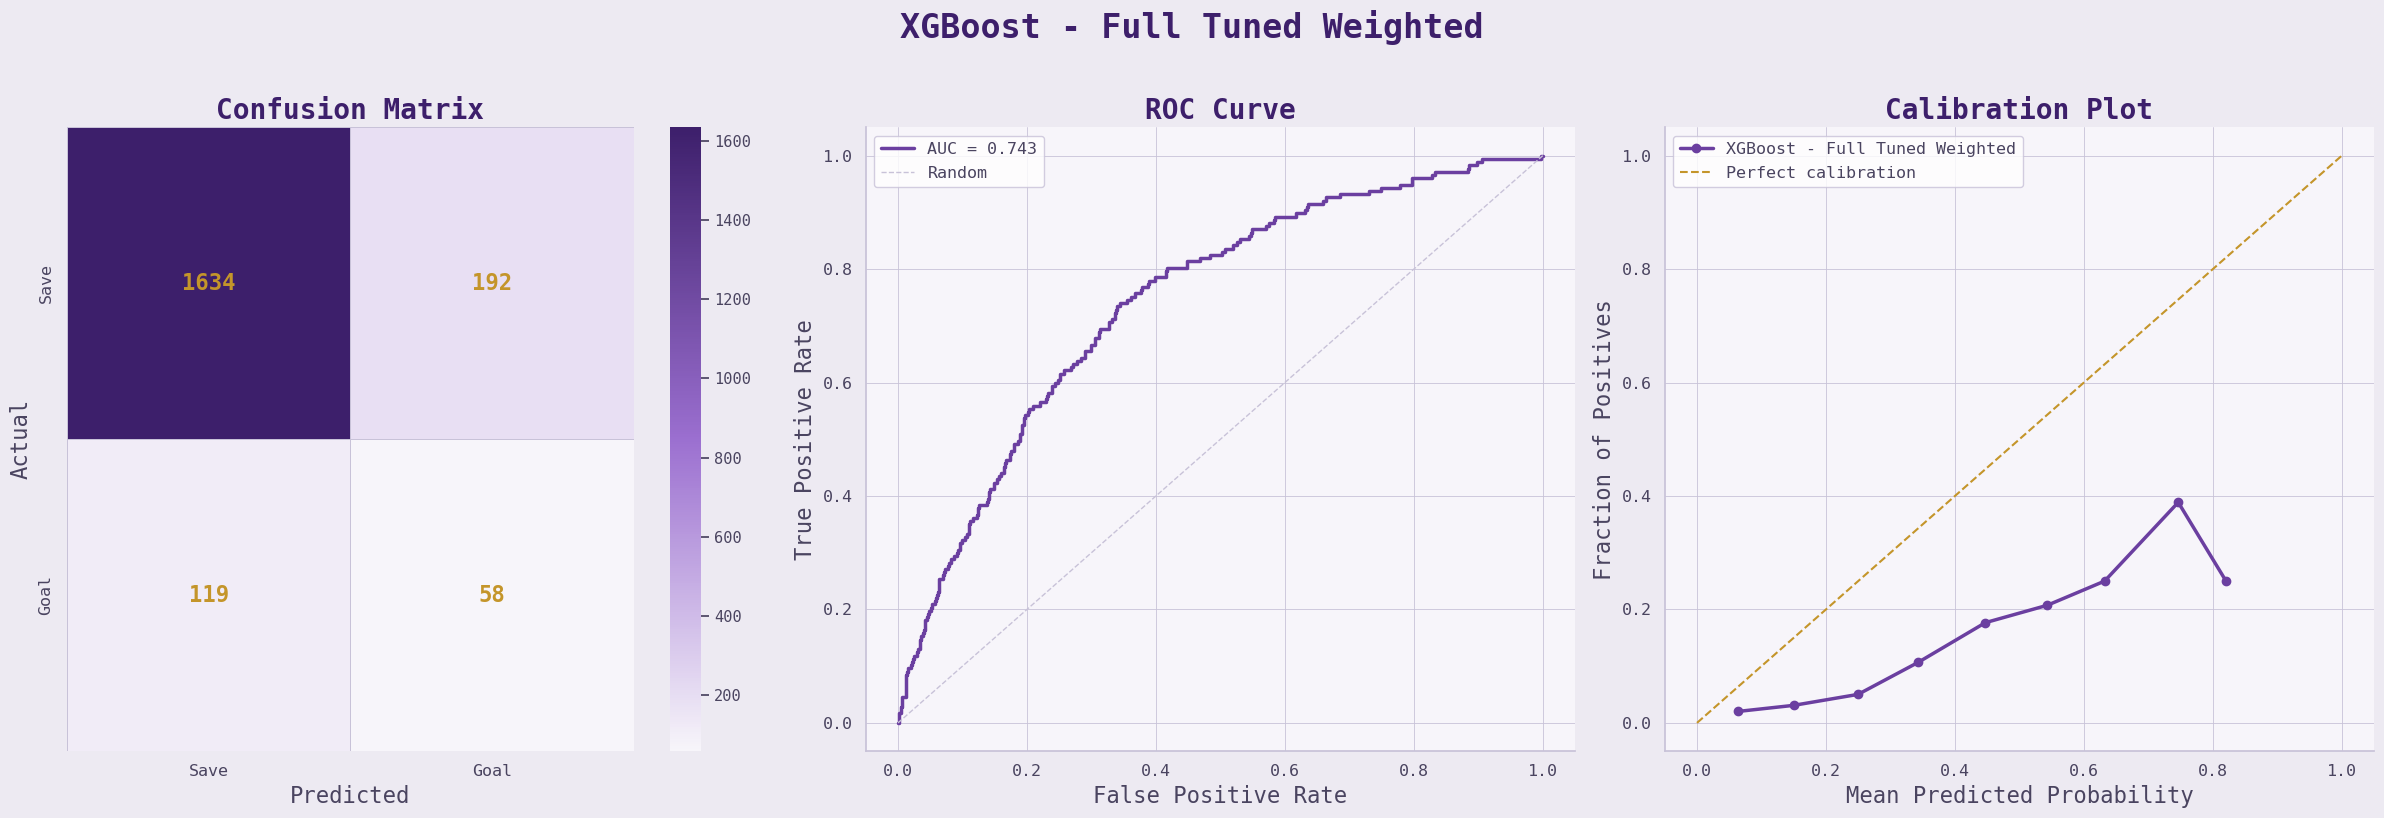

In [82]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 100,
                    max_depth = 3,
                    learning_rate = 0.05,
                    scale_pos_weight = weight/2,
                    subsample = 0.7)

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Full Tuned Weighted")


  Lowered (0.25) XGBoost - Full Tuned Weighted
  Baseline (always predict save): 91.17%
  Accuracy:                       53.07%
  AUC:                            0.743
  Log Loss:                       0.396
  Avg Precision (PR-AUC):         0.216

              precision    recall  f1-score   support

        Save       0.97      0.50      0.66      1826
        Goal       0.14      0.82      0.24       177

    accuracy                           0.53      2003
   macro avg       0.55      0.66      0.45      2003
weighted avg       0.89      0.53      0.62      2003



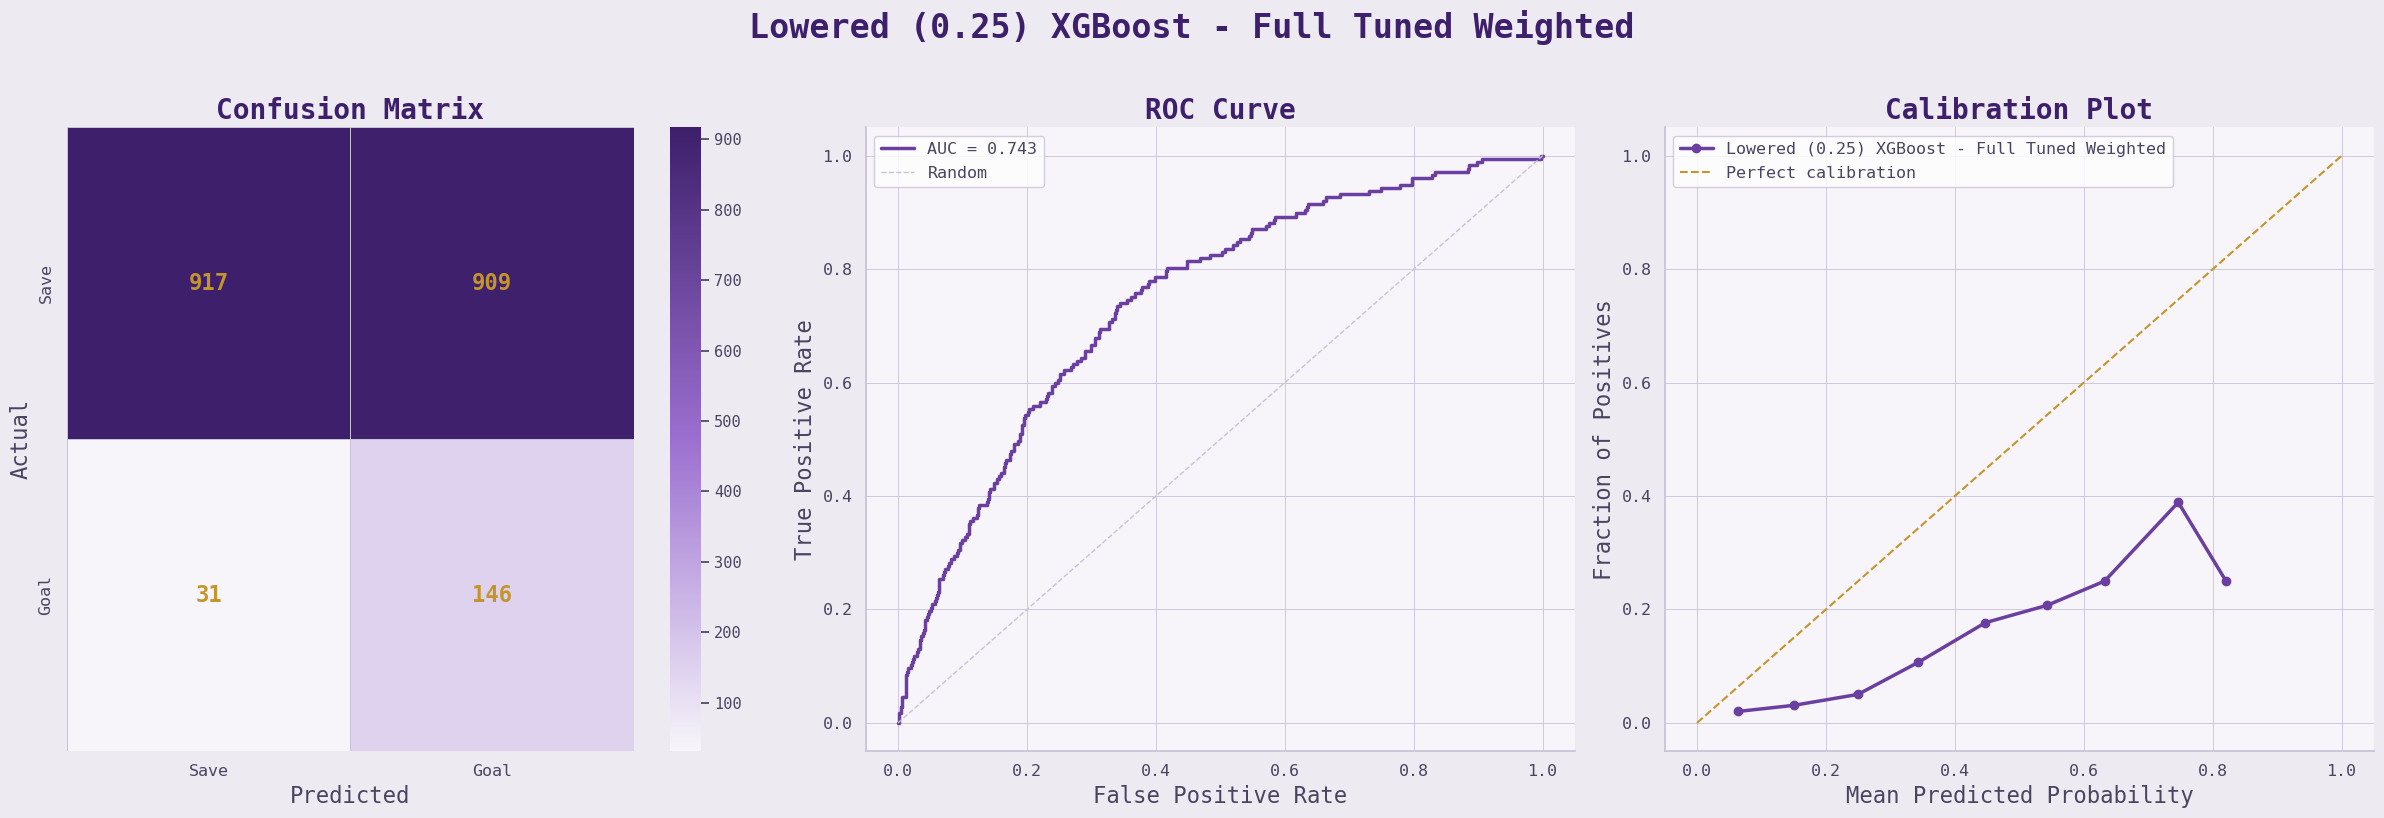

In [83]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 100,
                    max_depth = 3,
                    learning_rate = 0.05,
                    scale_pos_weight = weight/2,
                    subsample = 0.7)

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "Lowered (0.25) XGBoost - Full Tuned Weighted", threshold = 0.25)

In [84]:
param_grid = {
    'n_estimators':  [100, 200, 300, 400, 500],
    'max_depth':     [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample':     [0.5, 0.6, 0.7, 0.8],
    'scale_pos_weight': [weight, weight*2, weight/2]
}

grid = GridSearchCV(xgb, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid.fit(X_train[selected_cols], y_train)
print(grid.best_params_, grid.best_score_)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 5.163366336633663, 'subsample': 0.5} 0.7314176569379021



  XGBoost - Selected Tuned Weighted
  Baseline (always predict save): 91.17%
  Accuracy:                       84.82%
  AUC:                            0.741
  Log Loss:                       0.403
  Avg Precision (PR-AUC):         0.215

              precision    recall  f1-score   support

        Save       0.93      0.90      0.92      1826
        Goal       0.23      0.31      0.27       177

    accuracy                           0.85      2003
   macro avg       0.58      0.61      0.59      2003
weighted avg       0.87      0.85      0.86      2003



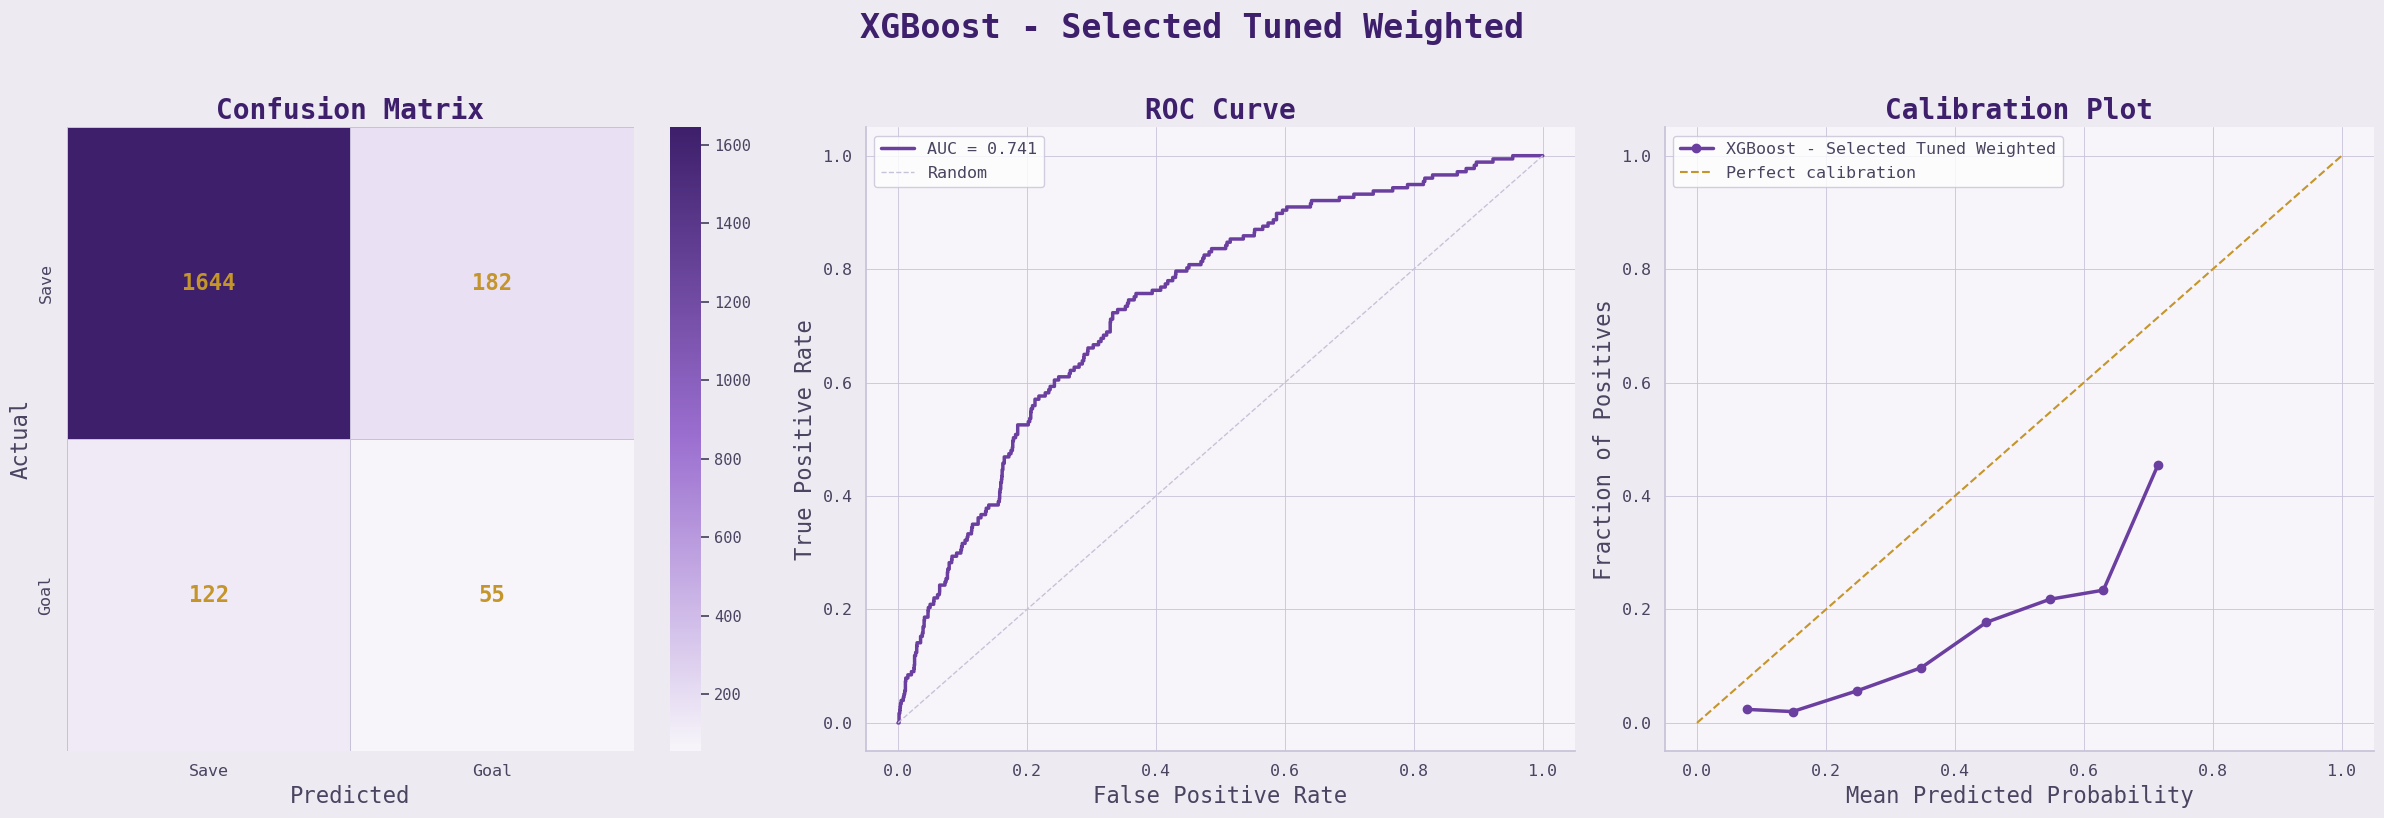

In [85]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 300,
                    max_depth = 3,
                    learning_rate = 0.01,
                    scale_pos_weight = weight/2,
                    subsample = 0.5)

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "XGBoost - Selected Tuned Weighted")


  Lowered (0.25) XGBoost - Selected Tuned Weighted
  Baseline (always predict save): 91.17%
  Accuracy:                       51.97%
  AUC:                            0.741
  Log Loss:                       0.403
  Avg Precision (PR-AUC):         0.215

              precision    recall  f1-score   support

        Save       0.97      0.49      0.65      1826
        Goal       0.14      0.85      0.24       177

    accuracy                           0.52      2003
   macro avg       0.55      0.67      0.44      2003
weighted avg       0.90      0.52      0.61      2003



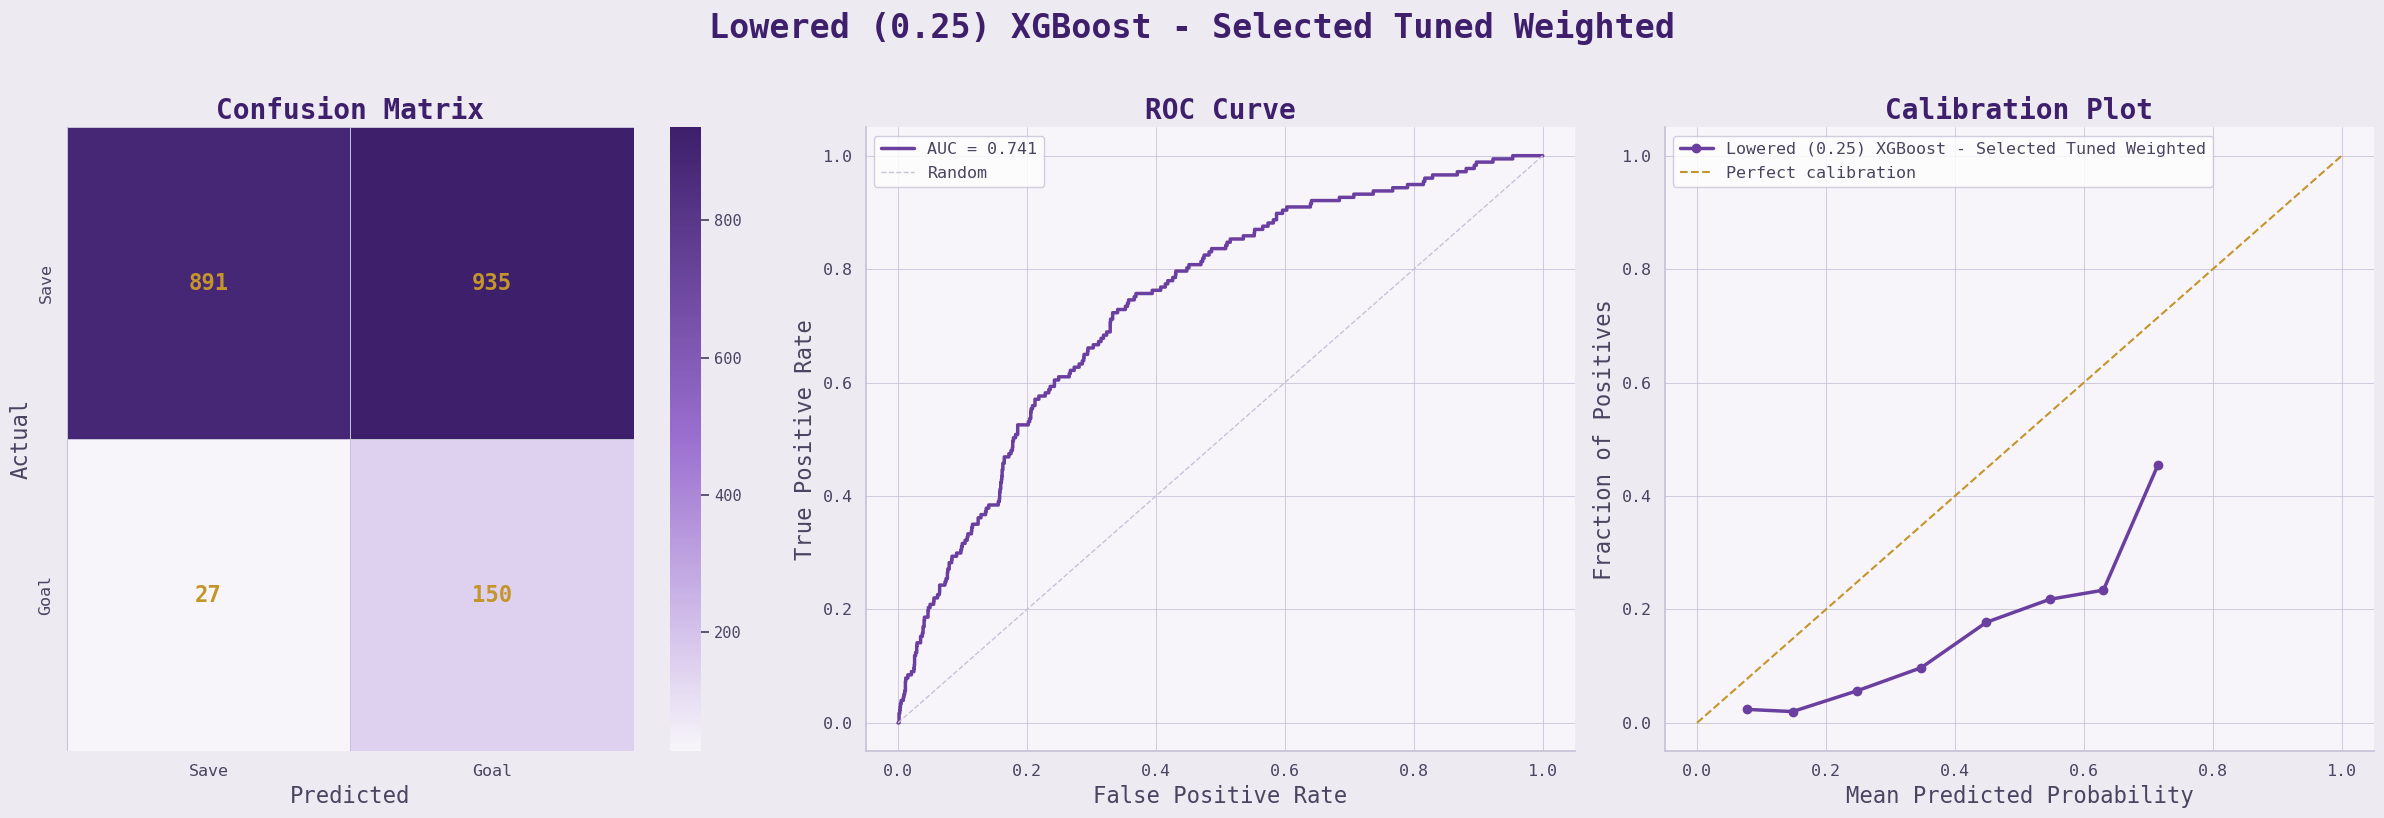

In [86]:
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 300,
                    max_depth = 3,
                    learning_rate = 0.01,
                    scale_pos_weight = weight/2,
                    subsample = 0.5)

xgb.fit(X_train[selected_cols], y_train)
model_eval(xgb, X_test[selected_cols], y_test, "Lowered (0.25) XGBoost - Selected Tuned Weighted", threshold = 0.25)

In [87]:
pd.DataFrame(eval_list).sort_values(['auc', 'accuracy'], ascending = [False, False])

model  accuracy     auc  \
43                      XGBoost - Full Tuned Weighted    0.8447  0.7433   
44       Lowered (0.25) XGBoost - Full Tuned Weighted    0.5307  0.7433   
39                    XGBoost - Full Tuned Unweighted    0.9091  0.7421   
40     Lowered (0.25) XGBoost - Full Tuned Unweighted    0.8897  0.7421   
45                  XGBoost - Selected Tuned Weighted    0.8482  0.7410   
46   Lowered (0.25) XGBoost - Selected Tuned Weighted    0.5197  0.7410   
20             Log Reg C 10 — Full Set Standard Scale    0.9116  0.7398   
21  Lowered (0.25) Log Reg C 10 — Full Set Standar...    0.8947  0.7398   
29  Lowered (0.25) Log Reg C 10 — Full Set Standar...    0.8947  0.7398   
2                   Log Reg — Full Set Standard Scale    0.9116  0.7384   
14   Lowered (0.25) Log Reg — Full Set Standard Scale    0.8972  0.7384   
15    Lowered (0.1) Log Reg — Full Set Standard Scale    0.7039  0.7384   
9        Balanced Log Reg — Selected Set MinMax Scale    0.6555  0.7380   
5                     Selected Log Reg - MinMax Scale    0.9121  0.7378   
18   Lowered (0.25) Log Reg — Selected Set MinMax ...    0.9026  0.7378   
8      Balanced Log Reg — Selected Set Standard Scale    0.6560  0.7377   
27  Balanced Log Reg C 0.1 — Selected Set Standard...    0.6560  0.7377   
28  Lowered (0.25) Balanced Log Reg C 0.1 — Select...    0.3105  0.7377   
6          Balanced Log Reg — Full Set Standard Scale    0.6710  0.7372   
25  Balanced Log Reg C 1000 — Full Set Standard Scale    0.6710  0.7372   
26  Lowered (0.25) Balanced Log Reg C 1000 — Full ...    0.3475  0.7372   
4                   Selected Log Reg - Standard Scale    0.9121  0.7371   
16   Lowered (0.25) Log Reg — Selected Set Standar...    0.9026  0.7371   
30   Lowered (0.25) Log Reg — Selected Set Standar...    0.9026  0.7371   
17   Lowered (0.1) Log Reg — Selected Set Standard...    0.6910  0.7371   
19   Lowered (0.1) Log Reg — Selected Set Standard...    0.6910  0.7371   
22        Log Reg C 0.1 — Selected Set Standard Scale    0.9121  0.7365   
23  Lowered (0.25) Log Reg C 0.1 — Selected Set St...    0.9056  0.7365   
24  Lowered (0.15) Log Reg C 0.1 — Selected Set St...    0.8148  0.7365   
41                XGBoost - Selected Tuned Unweighted    0.9116  0.7364   
42  Lowered (0.25) XGBoost - Selected Tuned Unweig...    0.9016  0.7364   
7            Balanced Log Reg — Full Set MinMax Scale    0.6705  0.7350   
3                     Log Reg - Full Set MinMax Scale    0.9116  0.7349   
13        SMOTE Log Reg — Selected Set Standard Scale    0.6505  0.7347   
12        SMOTE Log Reg — Selected Set Standard Scale    0.6510  0.7342   
10            SMOTE Log Reg — Full Set Standard Scale    0.6755  0.7320   
11              SMOTE Log Reg — Full Set MinMax Scale    0.6665  0.7305   
0                            Base Logistic Regression    0.9111  0.7292   
1                        Selected Logistic Regression    0.9116  0.7250   
31                                XGBoost - Full Base    0.9061  0.7025   
32                            XGBoost - Selected Base    0.9031  0.6951   
33                            XGBoost - Full Weighted    0.8572  0.6918   
34                    XGBoost - Full Weighted Doubled    0.8253  0.6864   
38                 XGBoost - Selected Weighted Halved    0.8552  0.6837   
36                        XGBoost - Selected Weighted    0.8203  0.6802   
35                     XGBoost - Full Weighted Halved    0.8702  0.6652   
37                XGBoost - Selected Weighted Doubled    0.7803  0.6652   

    log_loss  avg_prec  
43    0.3957    0.2155  
44    0.3957    0.2155  
39    0.2701    0.2121  
40    0.2701    0.2121  
45    0.4032    0.2147  
46    0.4032    0.2147  
20    0.2679    0.2298  
21    0.2679    0.2298  
29    0.2679    0.2298  
2     0.2680    0.2300  
14    0.2680    0.2300  
15    0.2680    0.2300  
9     0.5980    0.2292  
5     0.2685    0.2299  
18    0.2685    0.2299  
8     0.5980    0.2283  
27    0.5980    0.2283

### XG Boost Summary

The best performing model based on AUC was XGBoost - Full Tuned Weighted.  It had an **AUC of 0.7433**.  However, the **Log Loss was 0.3957**, which is very high relative to the other models, as well as the publicly available literature around NHL xG models (which are closer to .2).  With all of the models relatively close together in AUC, the Log Loss shows significant differences in the quality of the models.

Instead, the model that I will be focusing on is the *XGBoost - Full Tuned Unweighted* which had an **AUC of 0.7421** and a **Log Loss of 0.2701**.  Both are off of public standards for an NHL xG model, but after filtering the data appropriately, this was best performing model overall.

I will take a closer look at this model to see how it made those predictions.


  XGBoost - Full Tuned Unweighted
  Baseline (always predict save): 91.17%
  Accuracy:                       90.91%
  AUC:                            0.742
  Log Loss:                       0.27
  Avg Precision (PR-AUC):         0.212

              precision    recall  f1-score   support

        Save       0.91      1.00      0.95      1826
        Goal       0.27      0.02      0.03       177

    accuracy                           0.91      2003
   macro avg       0.59      0.51      0.49      2003
weighted avg       0.86      0.91      0.87      2003



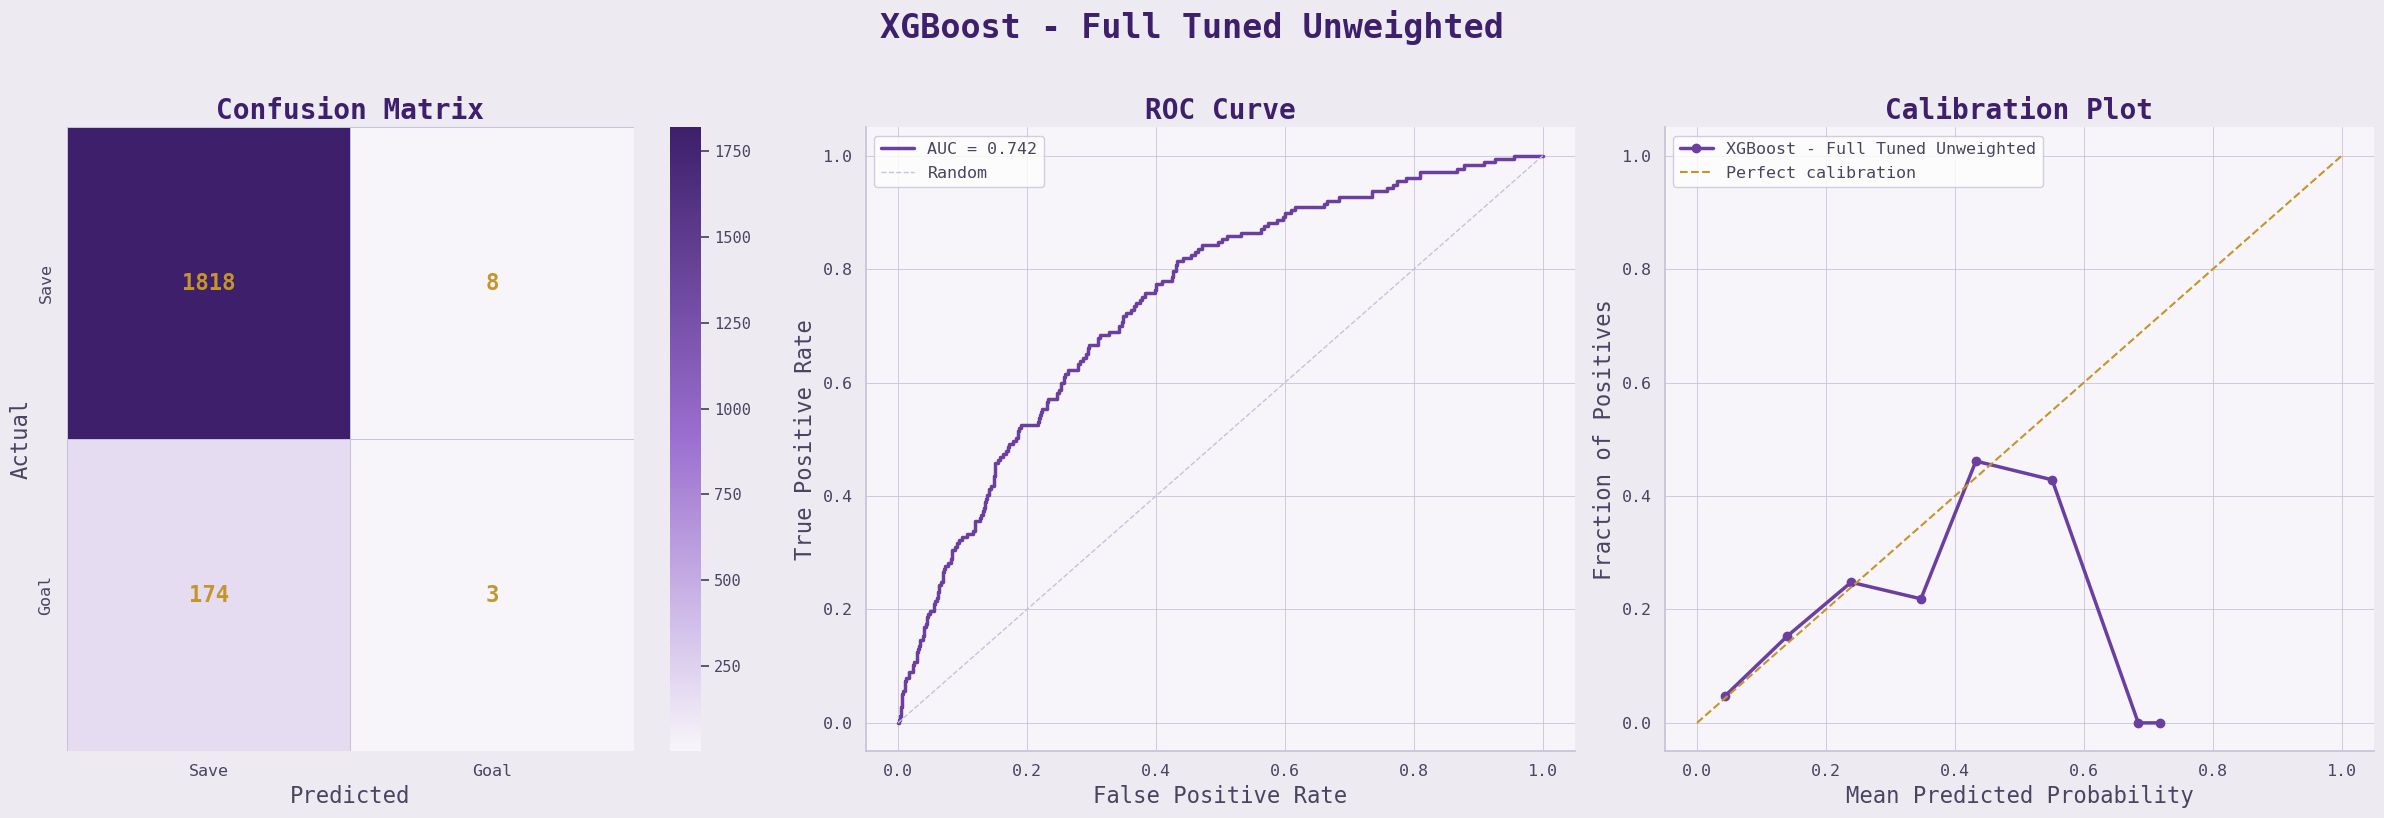

In [88]:
# Re-running the best XGBoost model in order to look closer at the Importance of the features
xgb = XGBClassifier(random_state=29,
                    eval_metric='logloss',
                    n_estimators = 200,
                    max_depth = 3,
                    learning_rate = 0.05,
                    subsample = 0.7)

xgb.fit(X_train, y_train)
model_eval(xgb, X_test, y_test, "XGBoost - Full Tuned Unweighted")

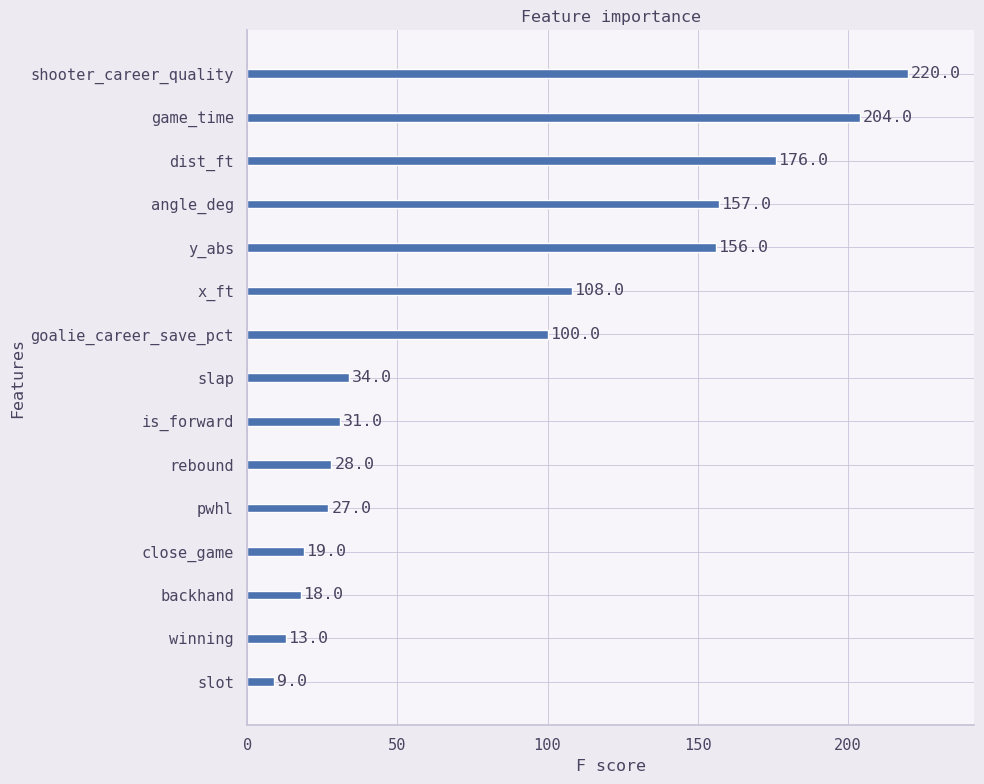

In [89]:
fig, ax = plt.subplots(figsize=(10, 8), facecolor=PWHL["bg"])
plot_importance(xgb, ax=ax, max_num_features=15)
plt.tight_layout()
display(fig)
plt.close(fig)

`shooter_career_quality` ranks high on the importance.  It's clear that the level of the shooter plays a role in the model, which aligns with what we know in hockey, even if the method that it was attained here may have overemphasized the role.  

It was shown in the EDA that the end of the game had a higher shooting percentage than the rest of the game, likely as a result of pulling the goaltender when trailing.  Unfortunately, the 'losing' goalie was not reliably recorded in this data, likely affecting the importance of `game_time` here.  This would be a good future improvement on this model.

Beyond that, all of the location data was important, which decreased the importance of `slot`.  Perhaps a simpler model could just use `slot` and get a similar result, but here the location data did a lot of work for the model.

<a id = 'summary'></a>

## 4. Even Strength Modelling Summary

Even though the Even Strength model did not outperform the whole dataset, it was clear that there were issues of multi-colinearity and data recording that needed to be overcome.  Therefore, the model finalized here will be the one that we move forward with.  With the xG model developed, we can now use it to evaluate performance on the ice, at least at Even Strength.

While the modelling process explored changing the thresholds of goals scored, it is a good reminder that even *great* scoring chances in hockey are not 100% locks, which can be tricky from a statistical point of view when trying to predict goals.

We will move forward with the the *XGBoost - Full Tuned Unweighted* model which had an **AUC of 0.7421** and a **Log Loss of 0.2701**.

We will apply the results of this model to the Even Strength dataset, and then explore how we can use it for player evaluation.

In [90]:
# Adding the xg stat to it
player_df['xg'] = xgb.predict_proba(X)[:, 1]

/var/folders/sj/6t29hmd16nj9c9trkt4npl6r0000gn/T/ipykernel_89451/1991329225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['xg'] = xgb.predict_proba(X)[:, 1]


In [91]:
player_df.head(5)

game_id              player_name player_team         goalie_name  \
0        1          Hayley Scamurra    Harvey's  Ann-Renée Desbiens   
1        1            Sarah Potomak      Adidas       Maddie Rooney   
2        1  Kendall Coyne Schofield      Adidas       Maddie Rooney   
3        1            Laura Fortino    Harvey's  Ann-Renée Desbiens   
4        1            Lee Stecklein    Harvey's  Ann-Renée Desbiens   

  goalie_team  home_team_skaters  away_team_skaters  period_1  period_2  \
0      Adidas                  5                  5         1         0   
1    Harvey's                  5                  5         1         0   
2    Harvey's                  5                  5         1         0   
3      Adidas                  5                  5         1         0   
4      Adidas                  5                  5         1         0   

   period_3   game_time       x_ft       y_ft      y_abs  dist_ft  angle_deg  \
0         0   30.266666  75.142281  15.844118  15.844118     21.0       48.8   
1         0   57.900000  81.272430  -0.252941   0.252941      7.7        1.9   
2         0  134.866670  85.295959 -36.464706  36.464706     36.7       84.2   
3         0  298.133330  67.598160   0.252941   0.252941     21.4        0.7   
4         0  301.500000  43.458725 -32.444130  32.444130     55.9       35.5   

   arclength  shooter_quality  shooter_career_quality  goalie_save_pct  \
0  17.886134         0.081256                0.061335         0.918744   
1   0.255342         0.081256                0.071575         0.918744   
2  53.933117         0.081256                0.111090         0.920337   
3   0.261450         0.081256                0.099041         0.920337   
4  34.635186         0.081256                0.085613         0.921869   

   goalie_career_save_pct  home_score  away_score  goal_diff  losing  tied  \
0                0.926386           0           0          0       0     1   
1                0.911145           0           0          0       0     1   
2                0.911145           0           0          0       0     1   
3                0.926386           0           0          0       0     1   
4                0.926386           0           0          0       0     1   

   winning  skater_diff  es  pp  sh  rebound  backhand  other  slap  snap  \
0        0            0   1   0   0        0         0      0     0     1   
1        0            0   1   0   0        0         0      0     0     1   
2        0            0   1   0   0        0         0      0     0     1   
3        0            0   1   0   0        0         0      0     0     0   
4        0            0   1   0   0        0         0      0     0     0   

   tip  wrist  slot  close_game  late_game  is_forward  pwhl  is_goal  \
0    0      0     0           1          0           1     0        0   
1    0      0     1           1          0           1     0        0   
2    0      0     0           1          0           1     0        0   
3    0      1     1           1          0           0     0        0   
4    0      1     0           1          0           0     0        0   

         xg  
0  0.016541  
1  0.168451  
2  0.008544  
3  0.165150  
4  0.013606

In [92]:
player_df.to_csv('xg_model.csv', index=False)